# Making the 95th efficiency plots 

In [9]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_gamma5.h5'

# First we need to reproduce the efficiency plots but with corrected pT

In [20]:
def plot_pt_eff_puppi(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))[0]

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

In [21]:
def plot_pt_eff_puppi_no_nn(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig > corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

1828/1828 [==============================] - 1s 608us/step


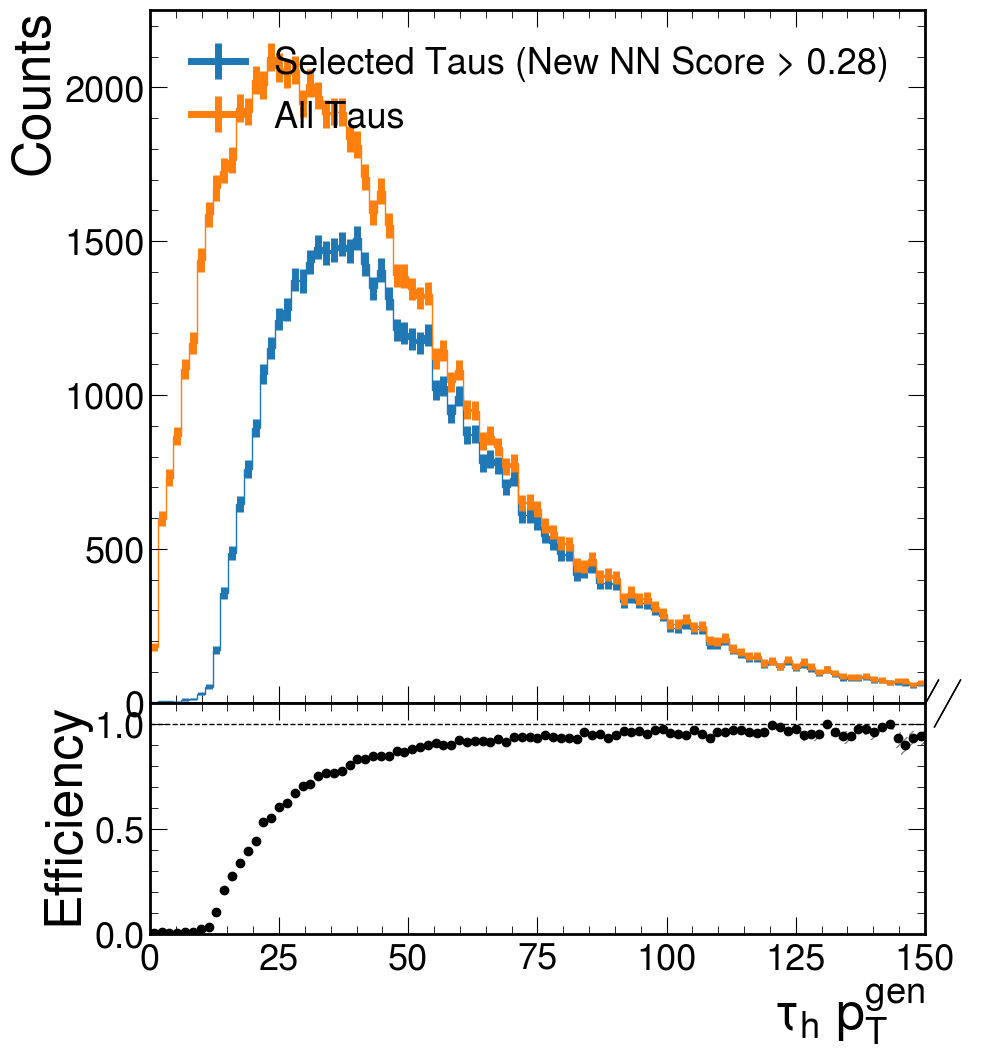

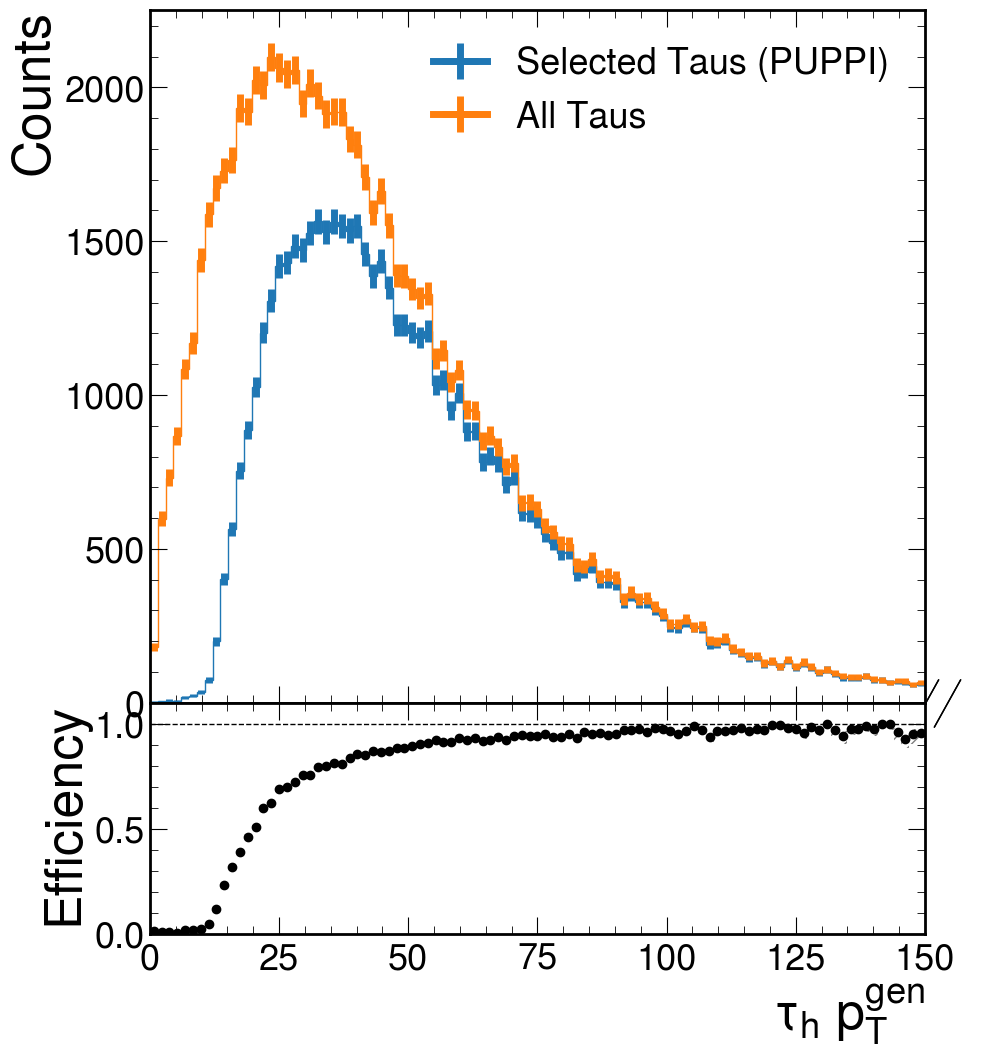

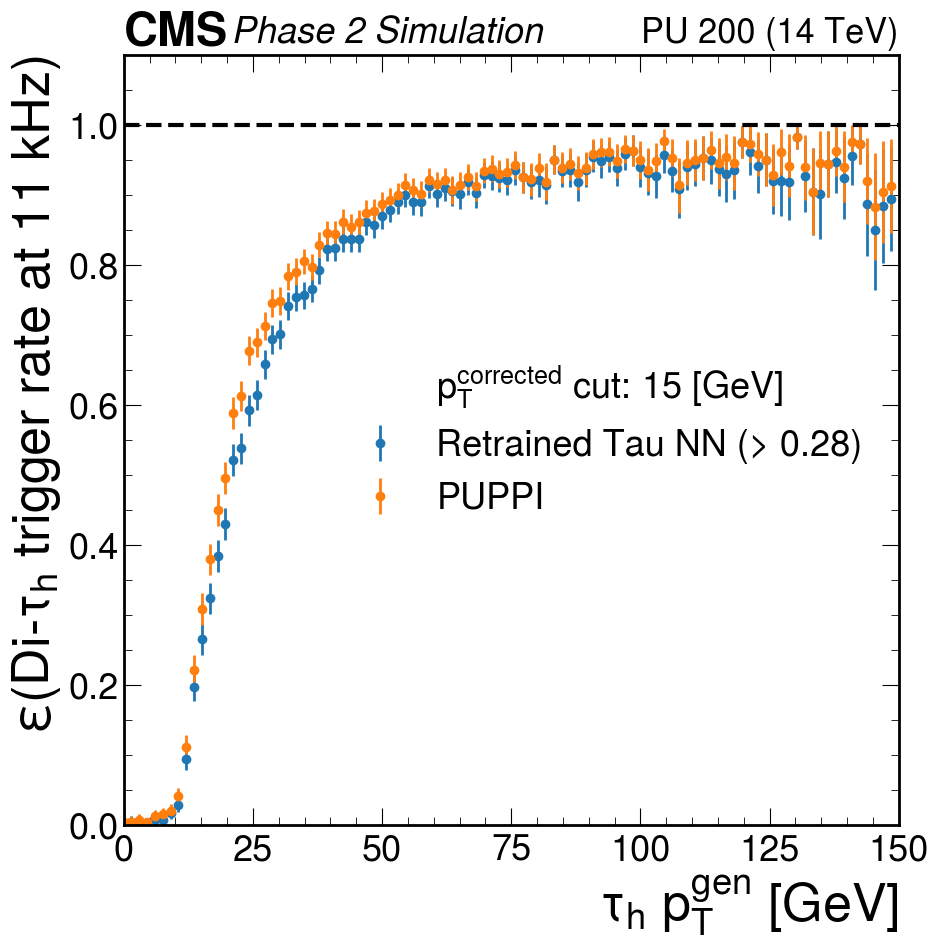

In [22]:
results = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=15.,
                            cut_point = 0.28)

1905/1905 [==============================] - 2s 956us/step


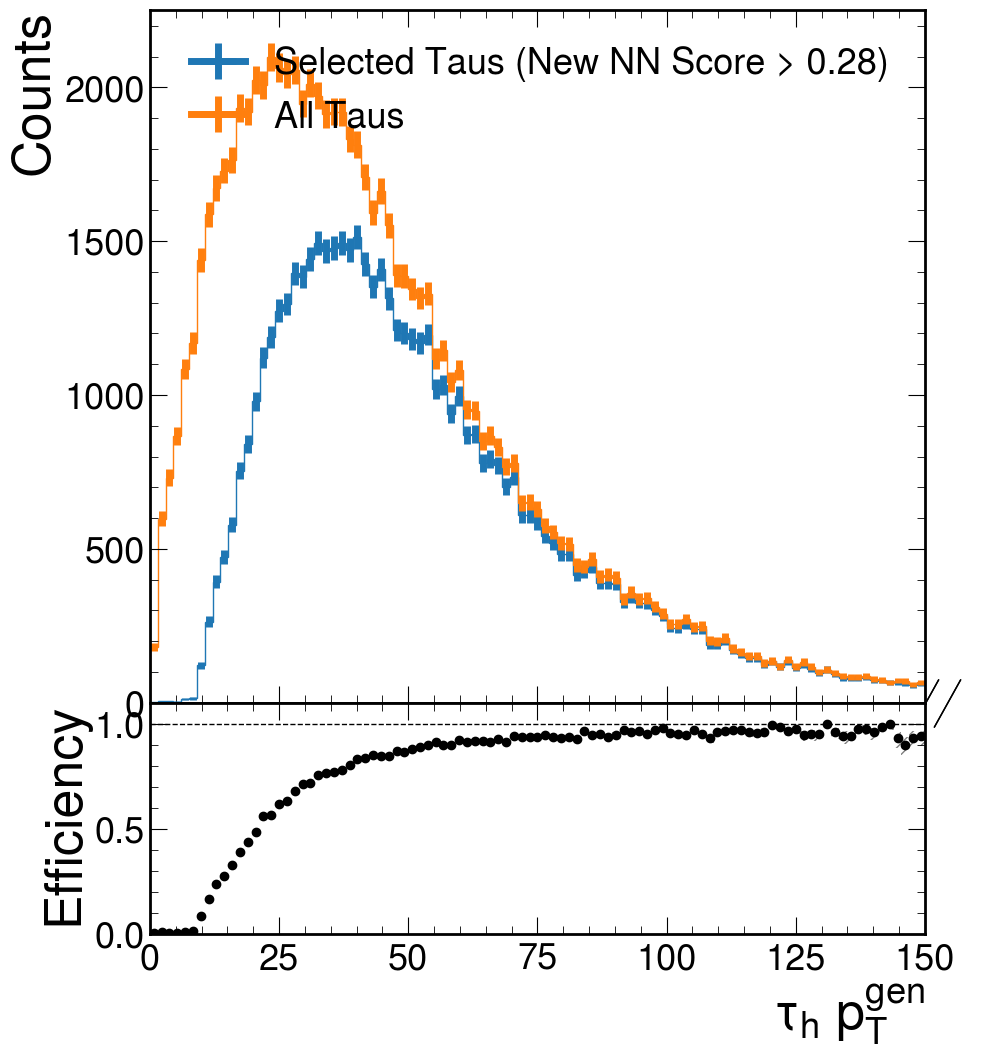

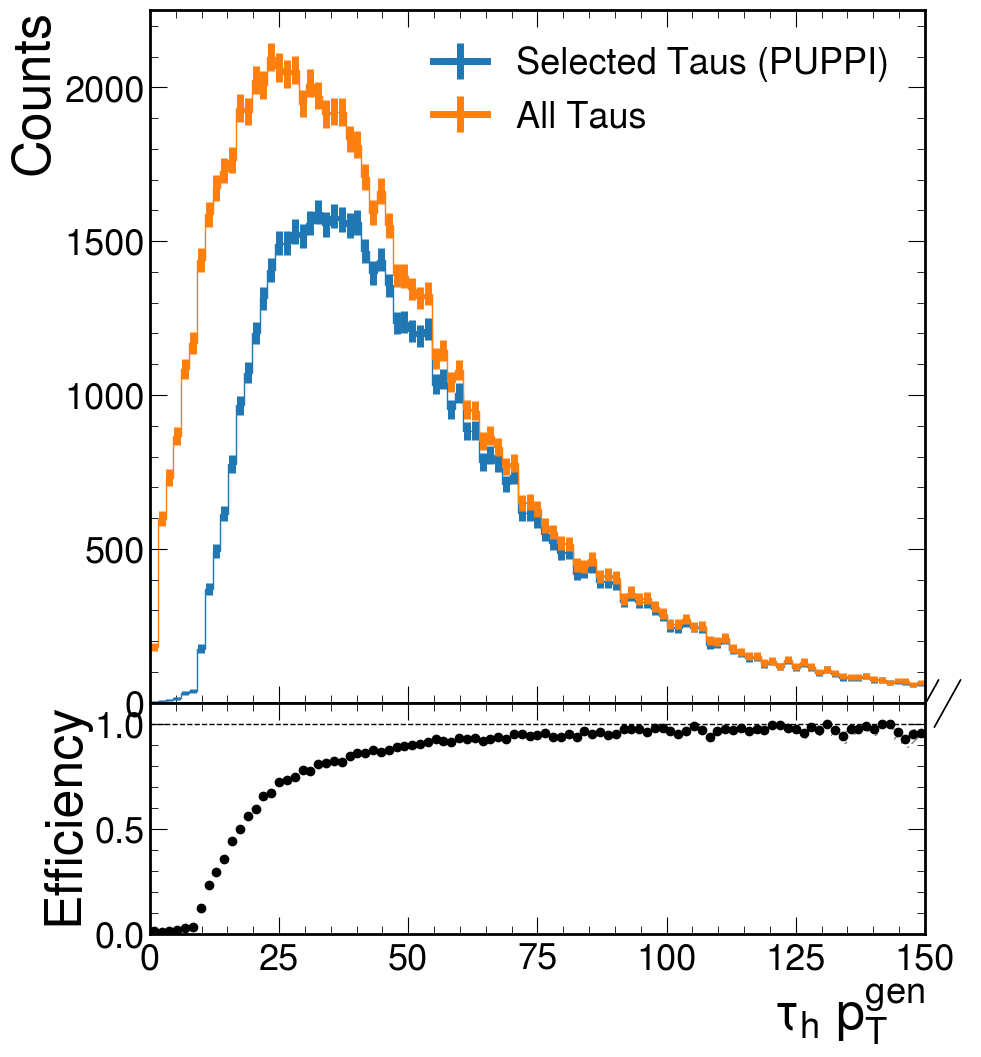

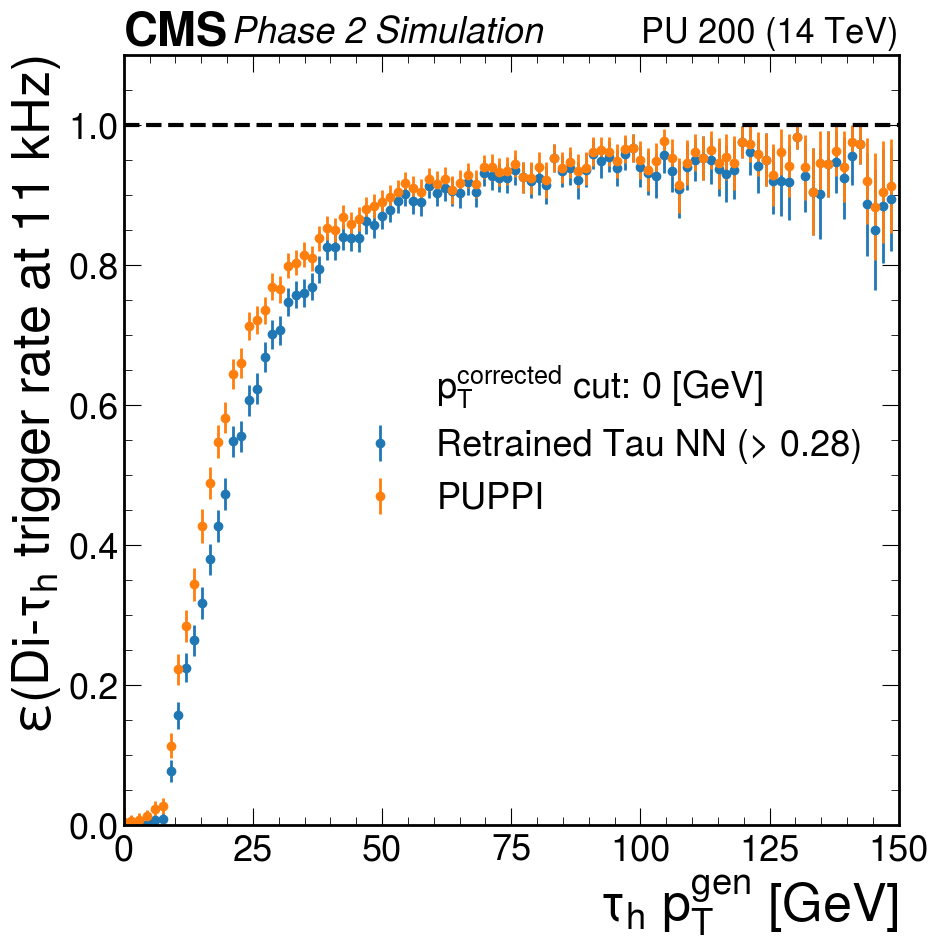

1828/1828 [==============================] - 2s 874us/step


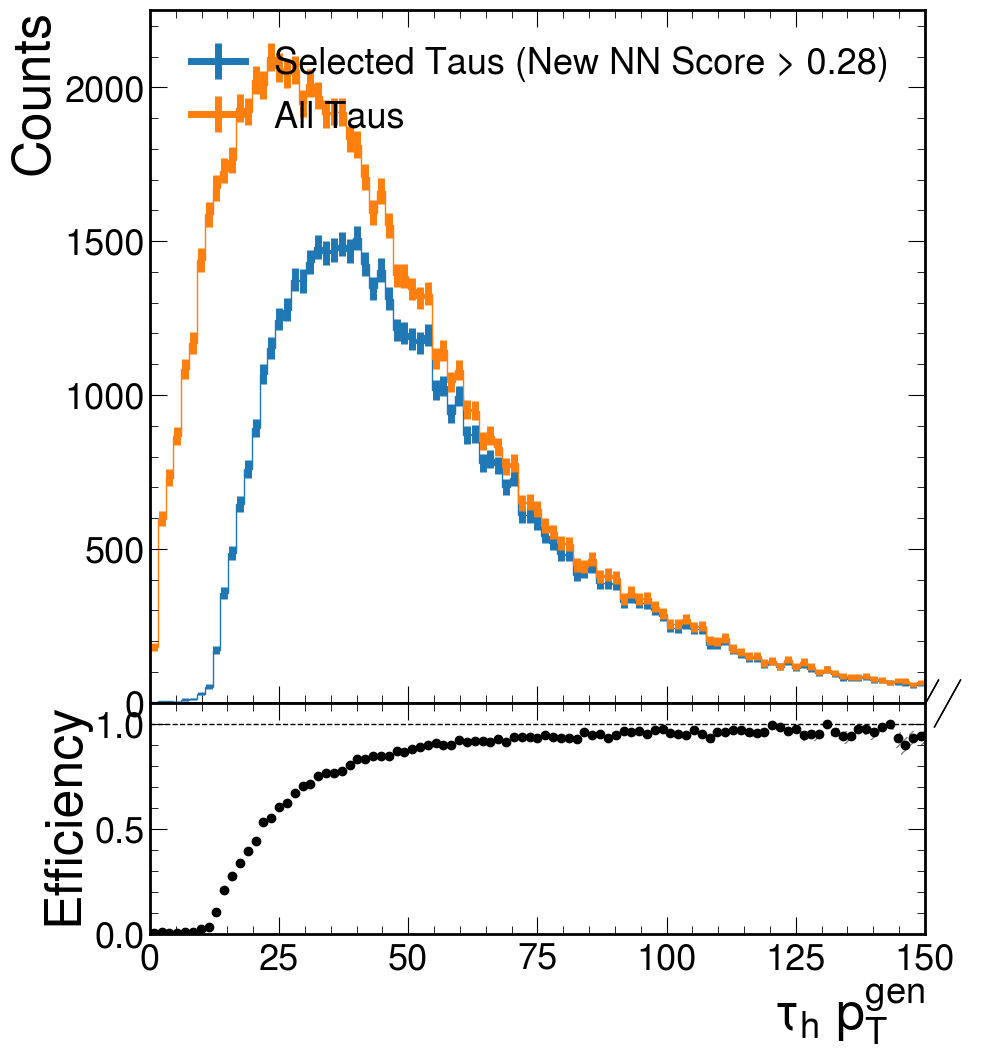

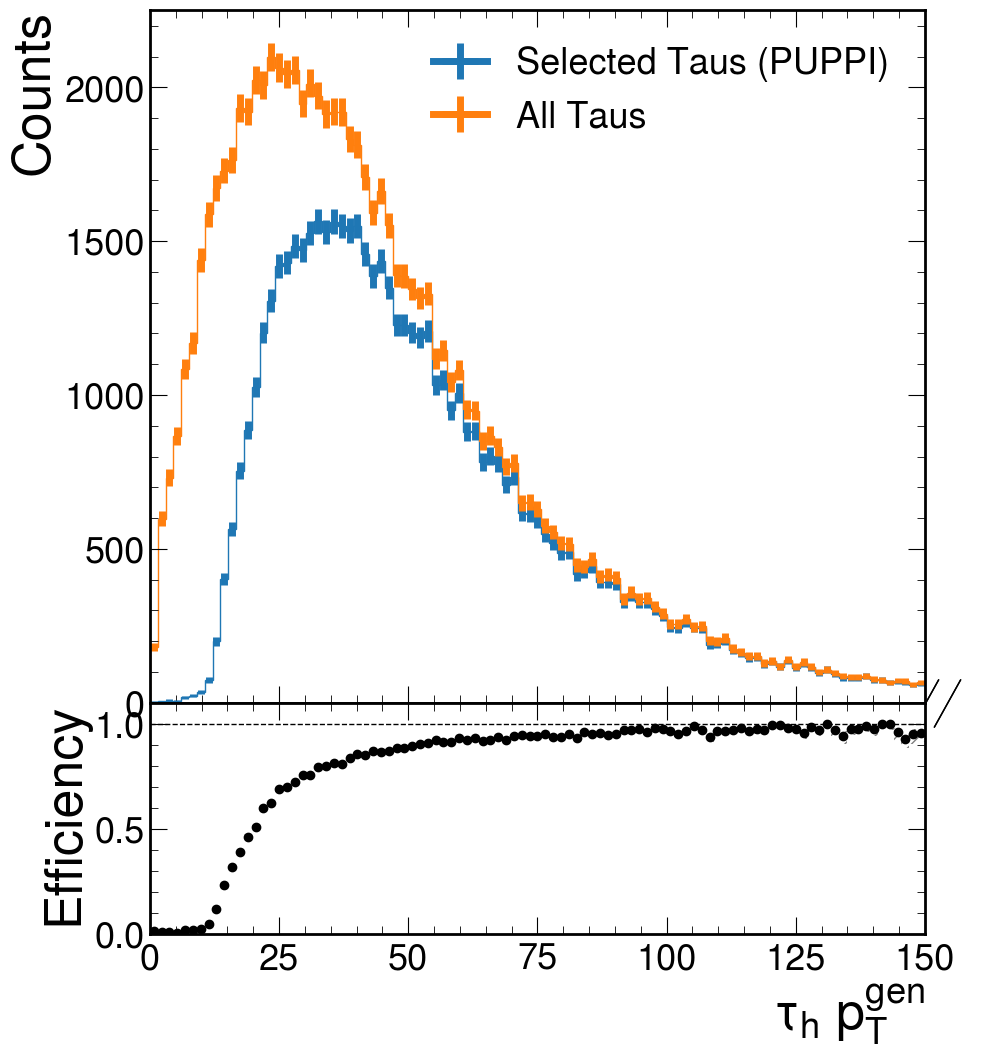

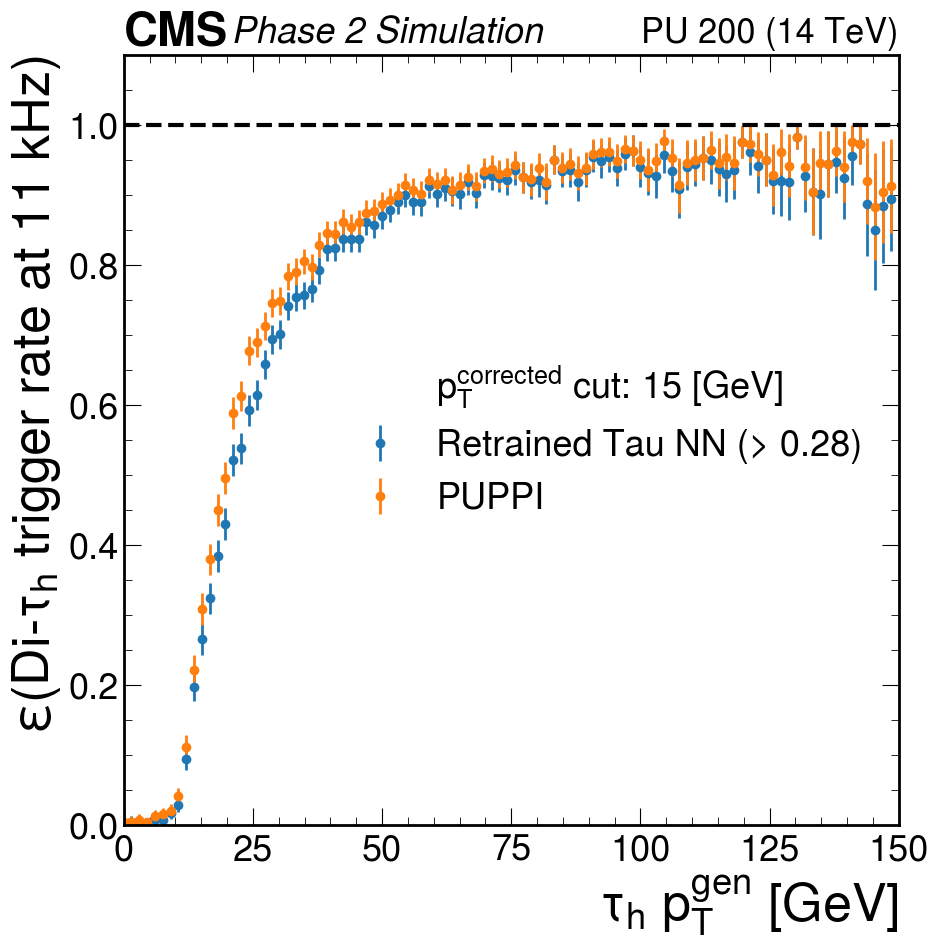

[1.         1.         1.         1.         0.89092692 0.75052006
 0.2144986  0.18102441 0.41965973 0.74688815 0.83542851 0.85353525
 0.90029686 0.90919897 0.95166542 0.96902849 0.97672042 0.98500066
 0.98458963 0.98963002 0.99218166 0.99106928 0.99510167 0.99513459
 0.99656055 0.9979001  0.99795283 0.99927572 0.9961718  0.99853078
 0.99921188 0.99914085 1.         1.         1.         0.9982511
 0.99896601 0.99898196 1.         1.         0.99878432 1.
 1.         0.99866131 1.         0.99848291 0.9970659  1.
 1.         0.99815922 1.         1.         0.99775374 0.99773959
 1.         0.99736109 1.         0.99714667 0.99717534 1.
 0.99647239 1.         1.         1.         1.         0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.99418423 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.     

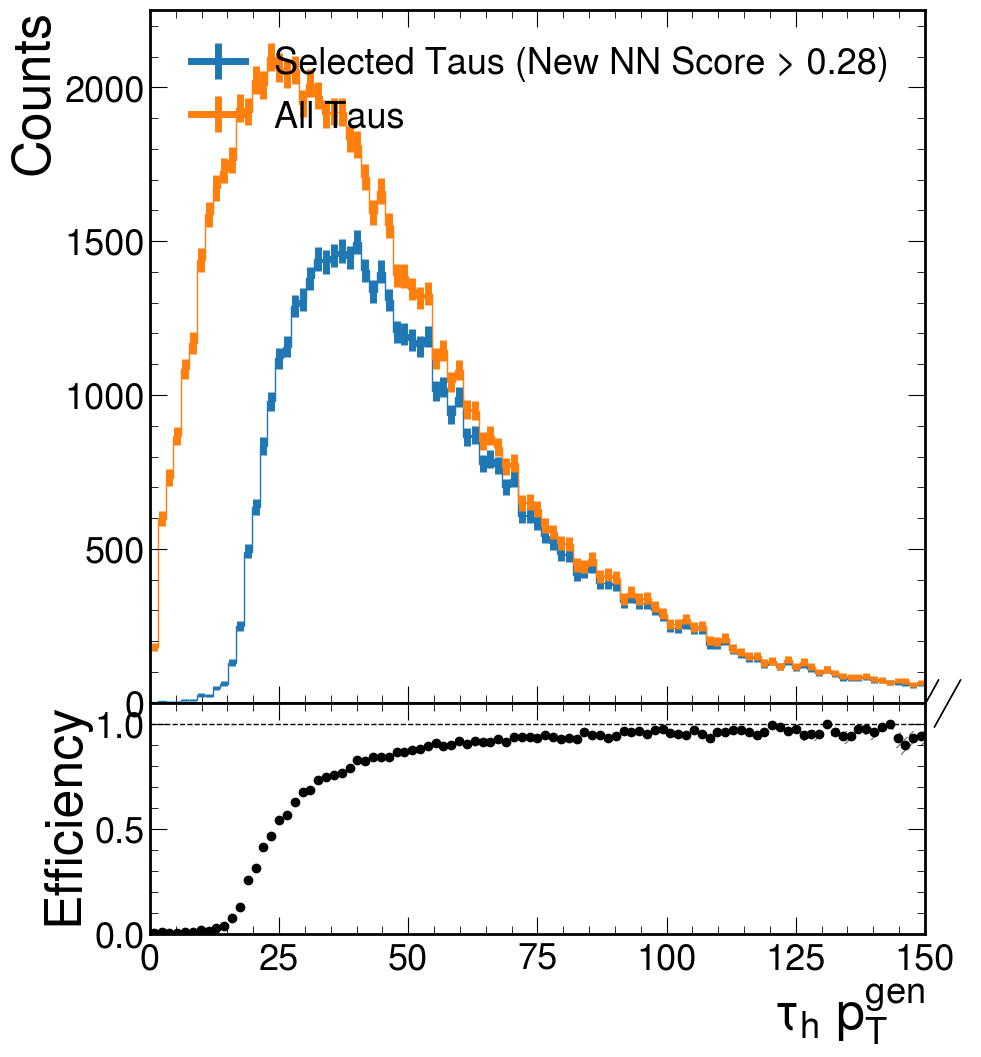

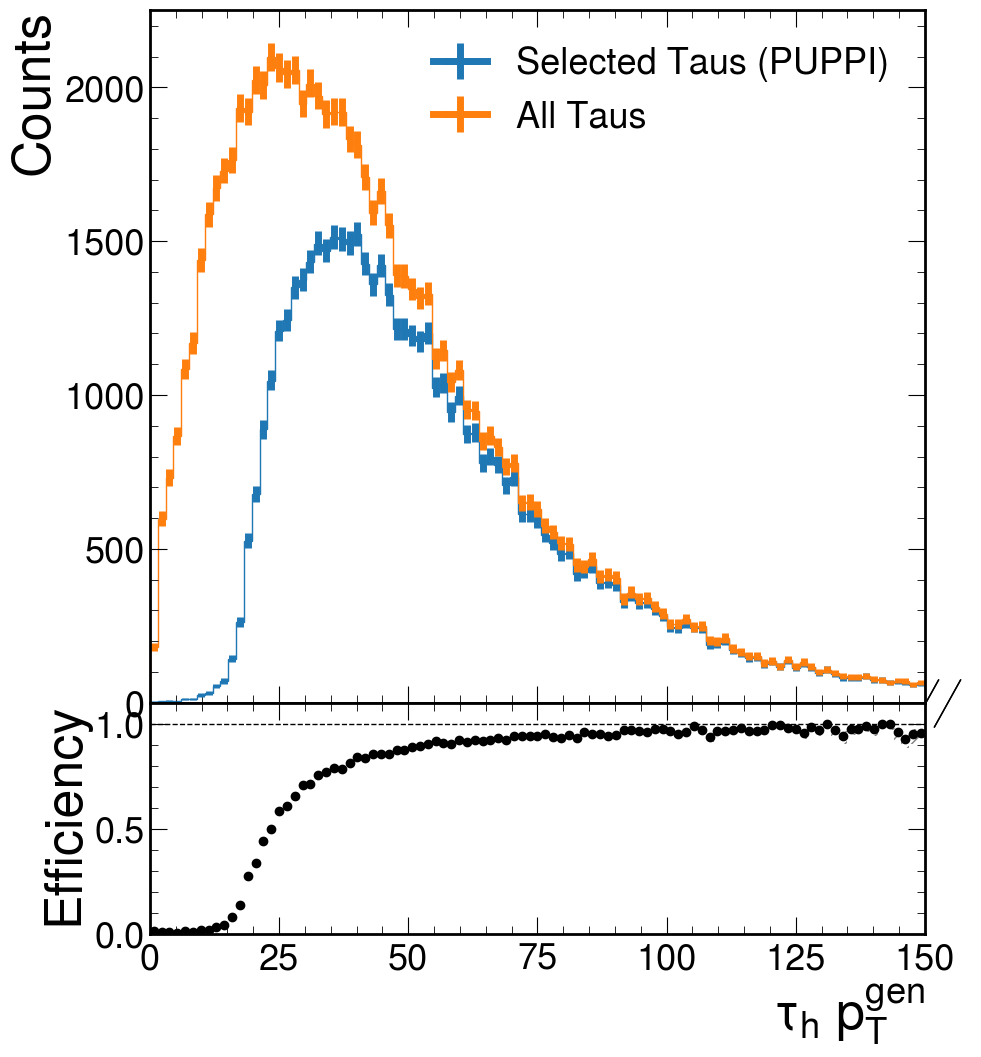

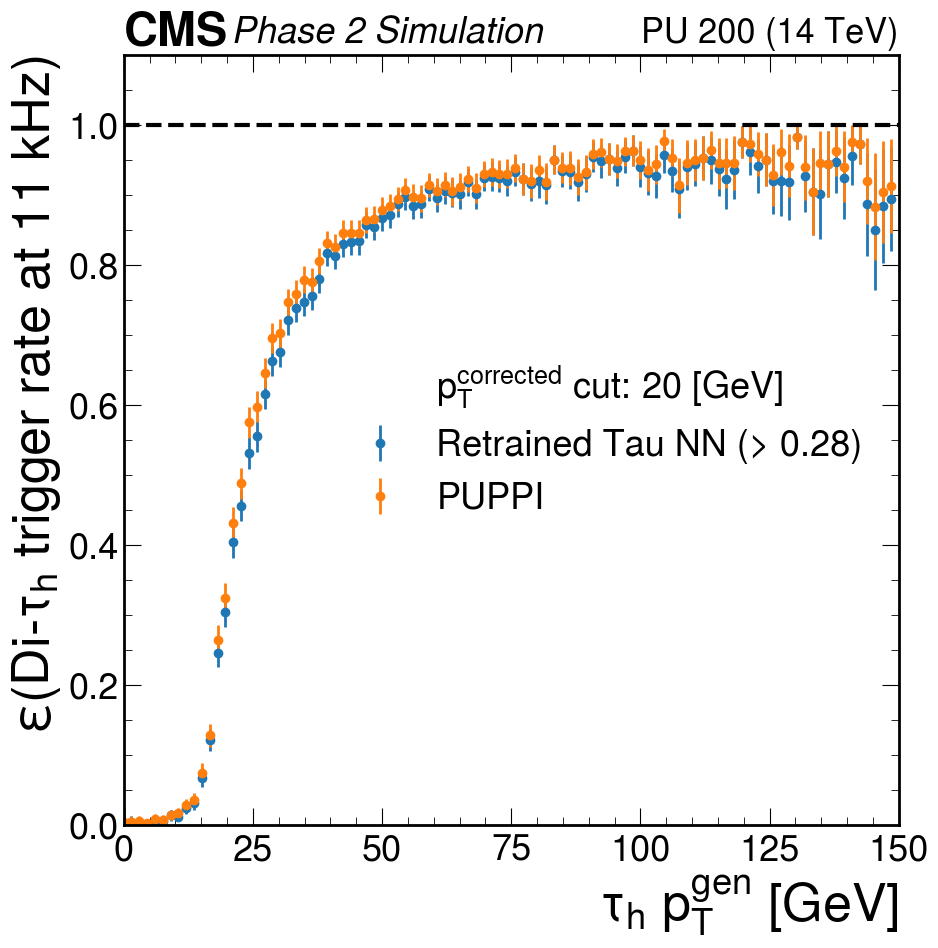

[1.         1.         0.65544255 0.51784426 0.78294596 0.58762301
 0.17355133 0.0736226  0.10718013 0.11713149 0.21284173 0.31847862
 0.57599107 0.64308065 0.73804132 0.82051838 0.87574922 0.8904204
 0.92156465 0.94523596 0.95525582 0.96430092 0.97482238 0.98262953
 0.98212234 0.98251019 0.99044971 0.98479995 0.98775519 0.99412445
 0.99527228 0.99398816 0.99653751 0.99647392 0.99106769 0.99475518
 0.99483279 0.99287846 0.99663714 0.99575859 0.99149903 0.9951463
 0.99727462 0.99866131 0.99861536 0.99696658 0.99267305 0.99822445
 1.         0.99632015 0.99798966 0.99790575 0.99551012 0.99548203
 1.         0.99736109 1.         0.99430032 0.99717534 0.99423811
 0.99647239 1.         0.99646955 1.         0.99615597 0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.99418423 1.         1.         1.         0.99184219
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.       

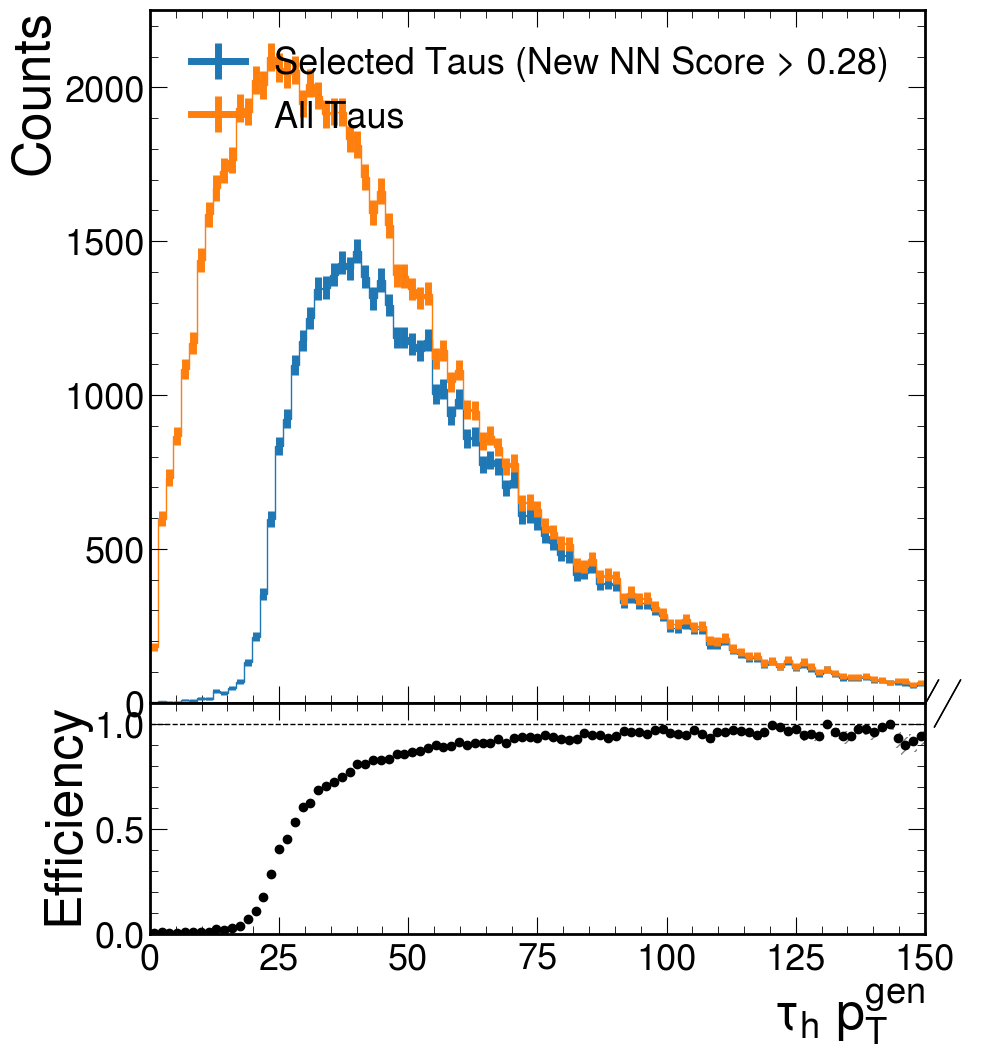

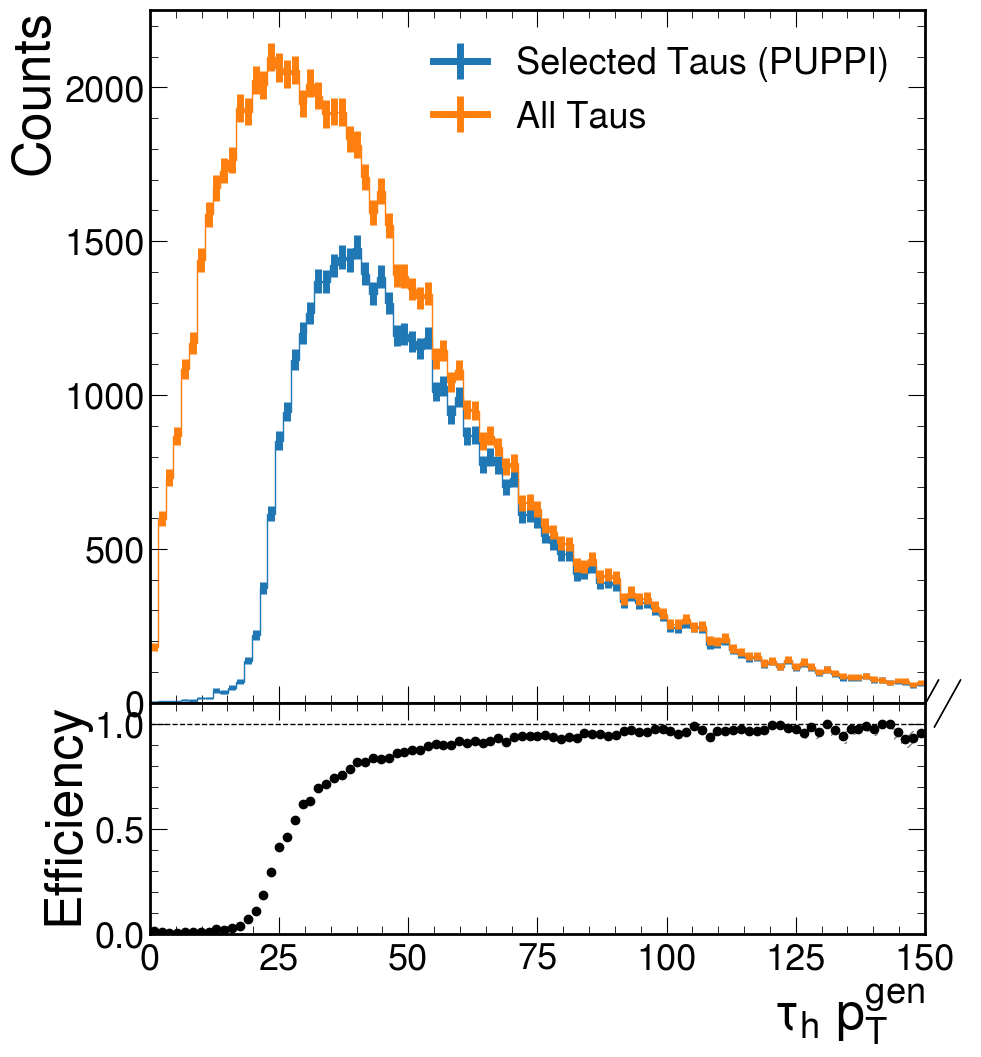

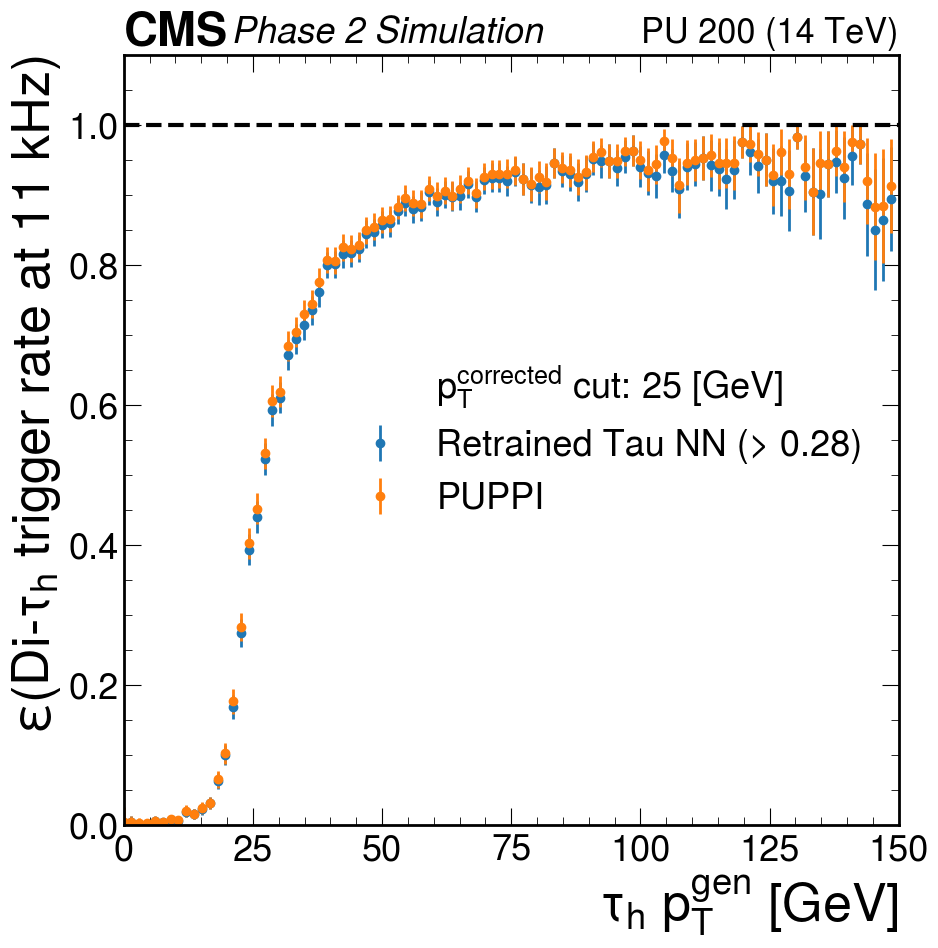

[1.         1.         0.3394046  0.51784426 0.67625066 0.42863184
 0.09341089 0.03809528 0.08254883 0.05801641 0.07198336 0.08179329
 0.14642925 0.21028994 0.30664634 0.4937326  0.64837195 0.70592462
 0.78203778 0.84635156 0.86316495 0.89854891 0.91619805 0.93892556
 0.95602528 0.95805817 0.96932978 0.97034209 0.97094312 0.97431956
 0.98267633 0.97855163 0.98788824 0.98502725 0.97769374 0.98428156
 0.98554824 0.98678275 0.9932768  0.99046443 0.98543876 0.98908939
 0.9918307  0.99598552 0.99584838 0.992422   0.98828945 0.99645059
 1.         0.99632015 0.99798966 0.99790575 0.99326903 0.98647826
 1.         0.99210809 1.         0.99146051 0.99717534 0.99423811
 0.99296522 1.         0.99295738 1.         0.99615597 0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.99418423 1.         0.99235507 1.         0.99184219
 1.         1.         1.         1.         1.         1.
 1.         0.98723858 1.         1.         1.         1.
 1.         1.     

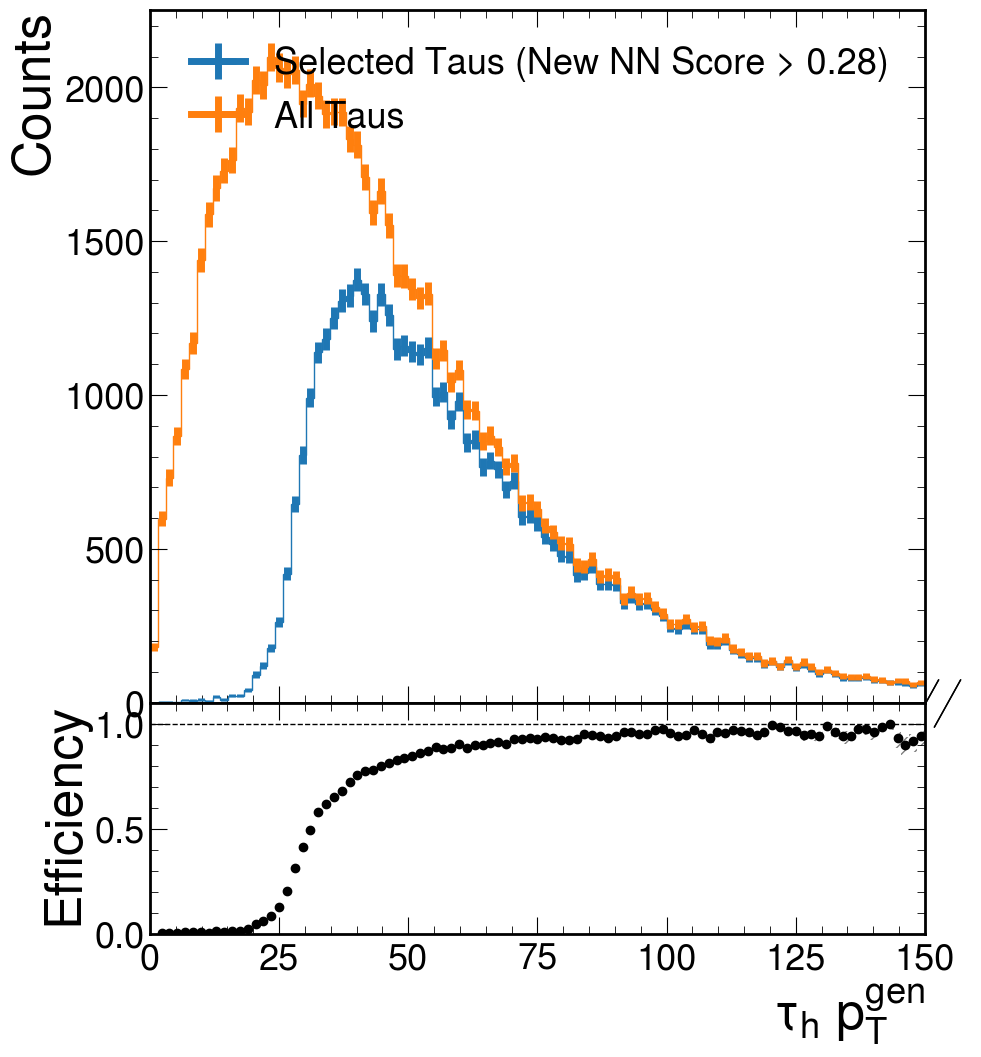

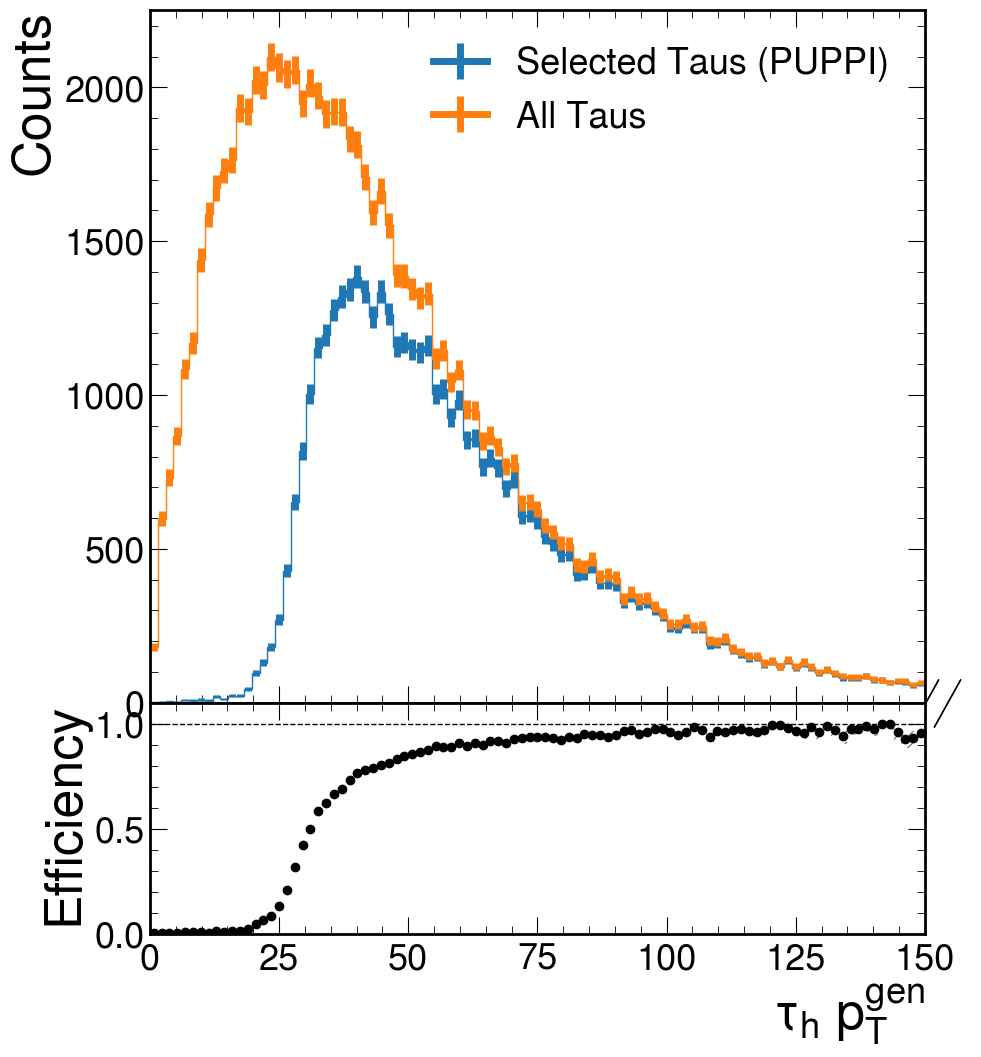

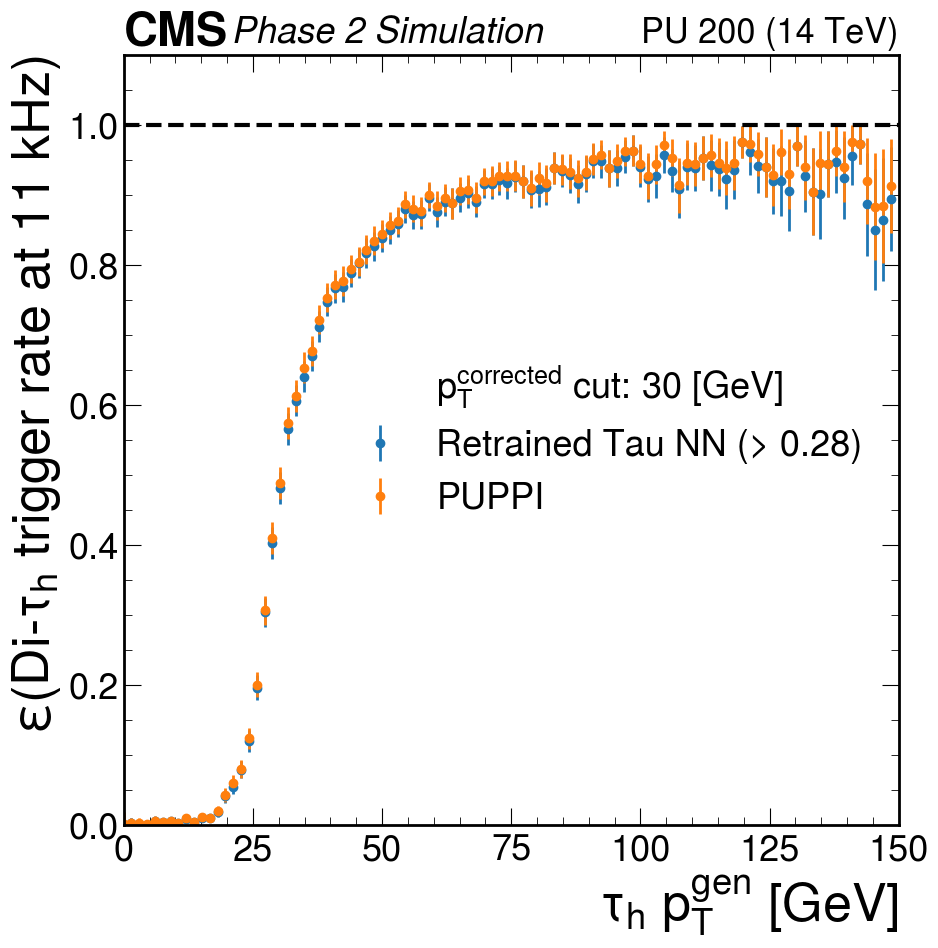

[0.         0.65541447 0.3394046  0.12628835 0.67625066 0.42863184
 0.06246332 0.01460133 0.03913938 0.01514873 0.03106404 0.02493539
 0.04121593 0.08540652 0.09955854 0.14180612 0.19720392 0.31450836
 0.45418095 0.57351678 0.68123866 0.75735189 0.80008802 0.8421178
 0.87109903 0.89673239 0.9061636  0.92922491 0.91533227 0.94065759
 0.9575299  0.94691057 0.96458074 0.96306541 0.96701382 0.9633911
 0.97628296 0.97765273 0.98097579 0.98200998 0.96972317 0.97821293
 0.98096813 0.99331181 0.9820557  0.98486154 0.98245786 0.98760506
 0.99646211 0.99264695 0.98997441 0.99372445 0.98656007 0.98423346
 0.99737016 0.98428207 1.         0.98862687 0.9943554  0.99423811
 0.98947621 1.         0.98251311 1.         0.99615597 0.99579297
 1.         0.9906106  1.         1.         1.         1.
 1.         0.98842066 1.         0.99235507 1.         0.99184219
 1.         1.         1.         1.         0.98901063 1.
 1.         0.98723858 0.98631808 1.         1.         1.
 1.         1.       

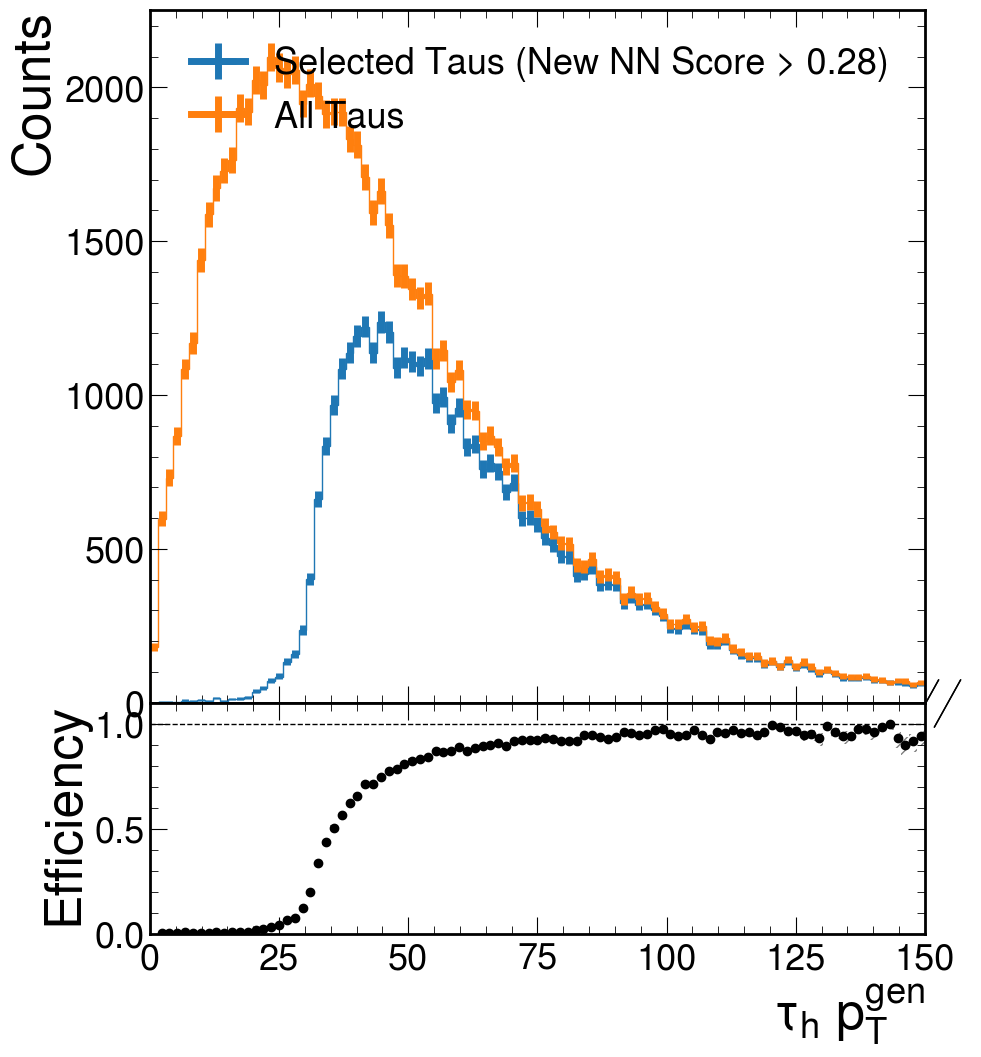

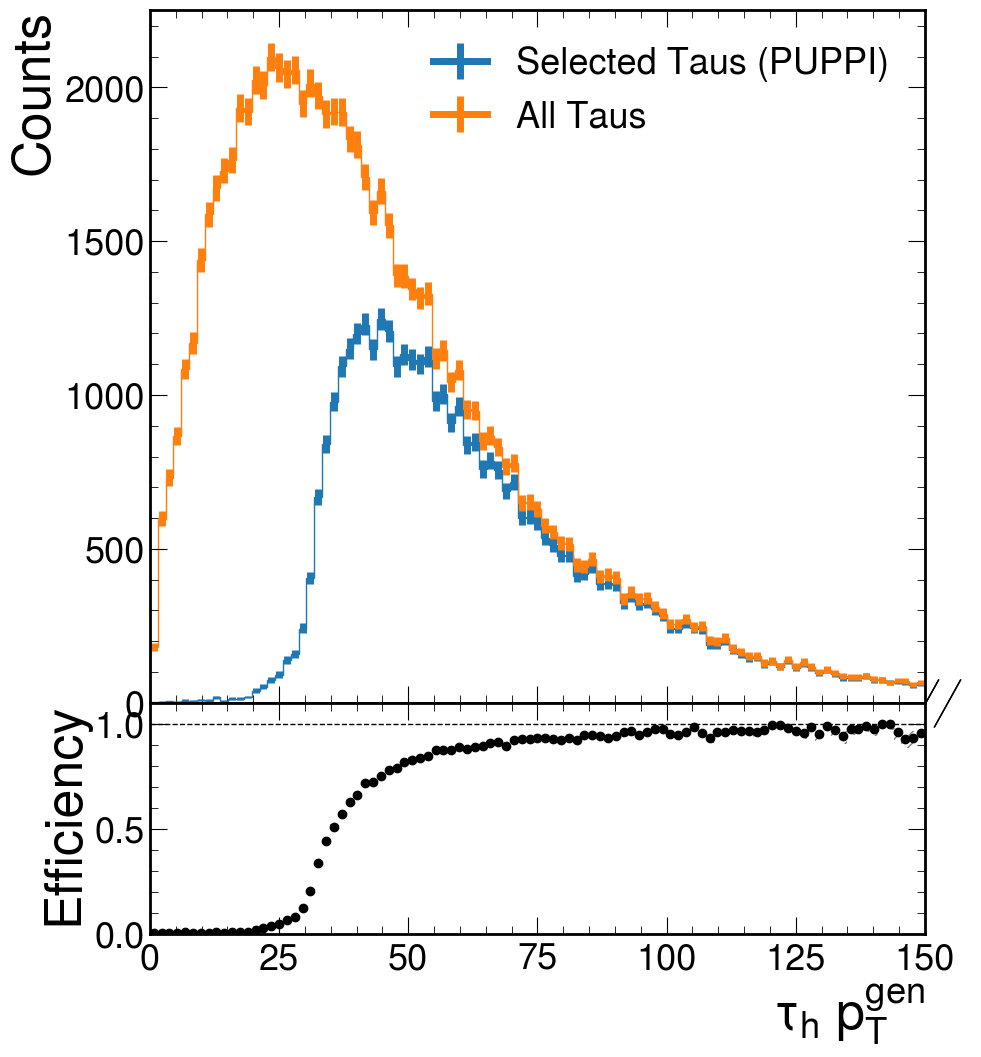

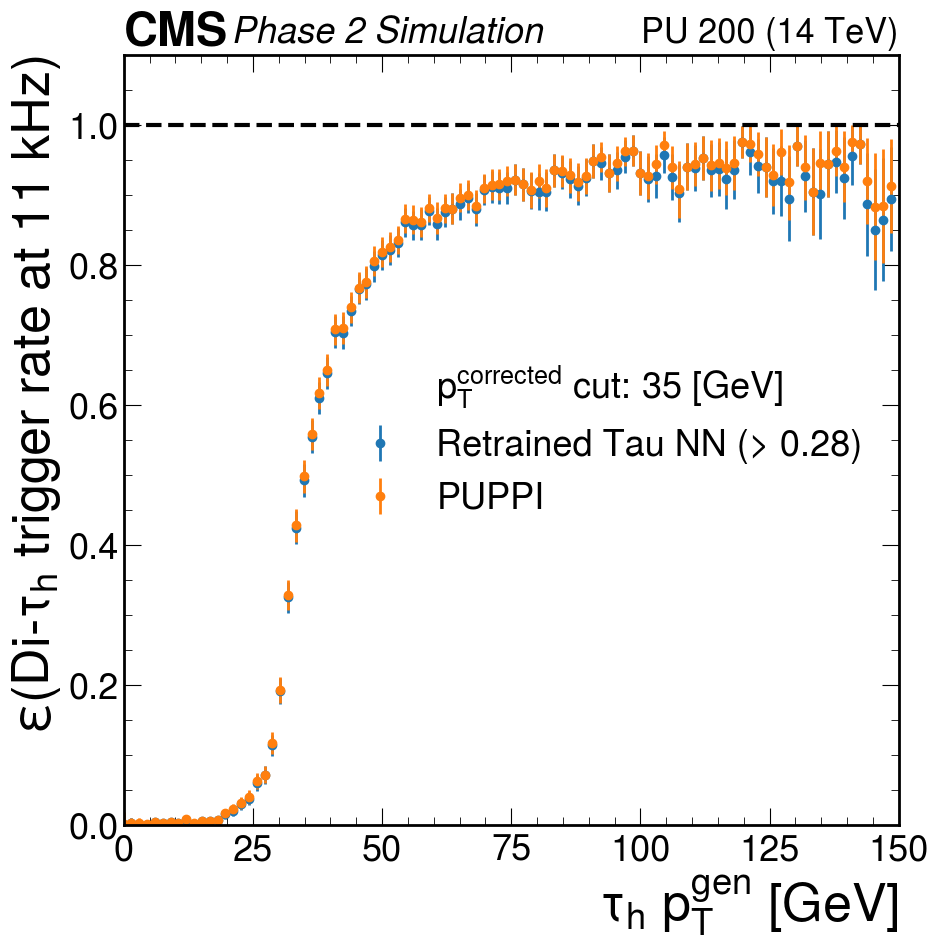

[0.         0.65541447 0.3394046  0.12628835 0.5711     0.27548221
 0.04741411 0.01460133 0.02977882 0.00624196 0.01536896 0.01290345
 0.01578866 0.03144753 0.0366303  0.05383647 0.06069761 0.09563562
 0.10622453 0.16175404 0.27013159 0.43461017 0.5604021  0.64752281
 0.72115702 0.76840051 0.7832053  0.85305122 0.83723522 0.87576584
 0.9136504  0.89581119 0.93101644 0.93503876 0.9341772  0.9330394
 0.95472919 0.96145798 0.9642478  0.96094947 0.9504517  0.96135205
 0.97284129 0.98263639 0.97381006 0.97279755 0.97373597 0.98231507
 0.98412585 0.98531895 0.98598105 0.98955219 0.98432826 0.97975066
 0.98950121 0.98168582 0.99750185 0.98297671 0.99153997 0.98850125
 0.98947621 0.99670776 0.97561413 0.99651613 0.99615597 0.99579297
 0.99060893 0.9906106  1.         1.         0.99041382 0.99395768
 1.         0.98842066 1.         0.98480971 1.         0.99184219
 1.         1.         1.         1.         0.98901063 1.
 1.         0.97465157 0.98631808 1.         1.         1.
 1.         

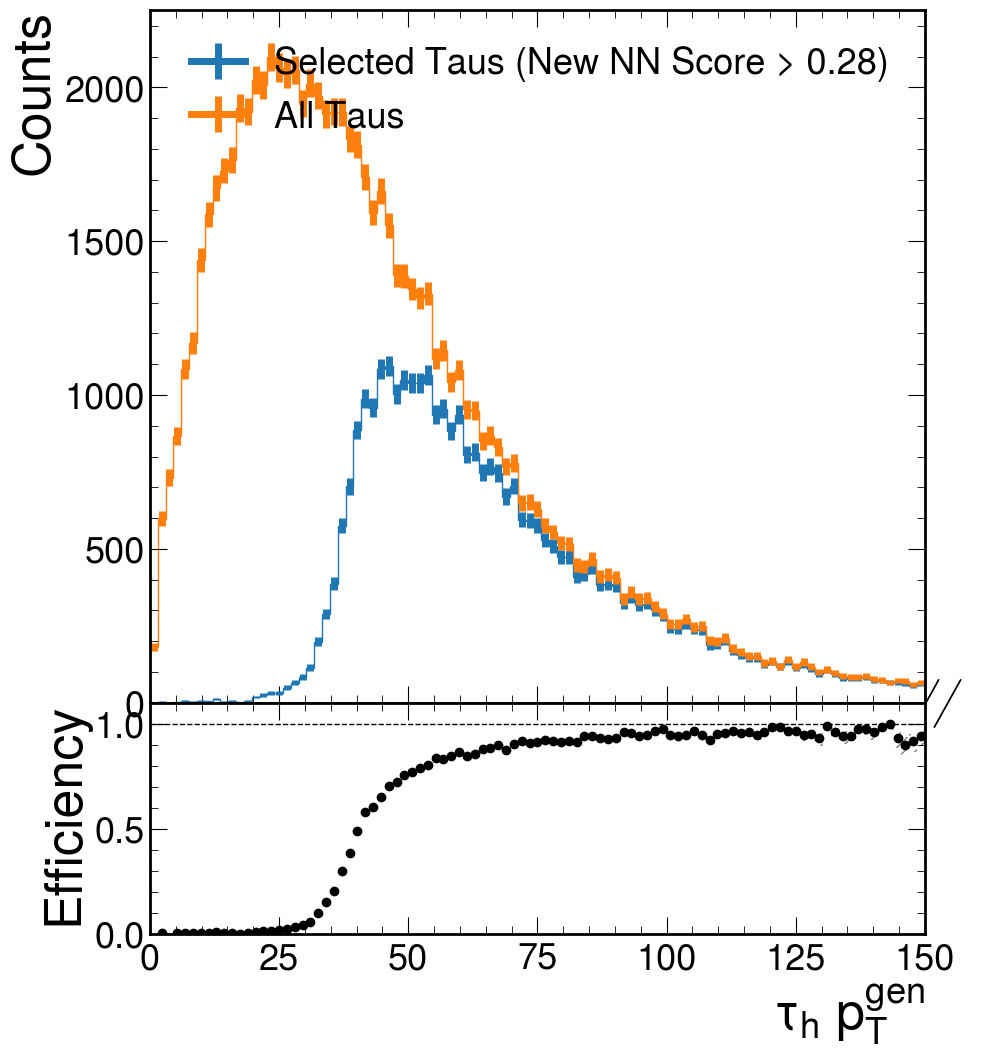

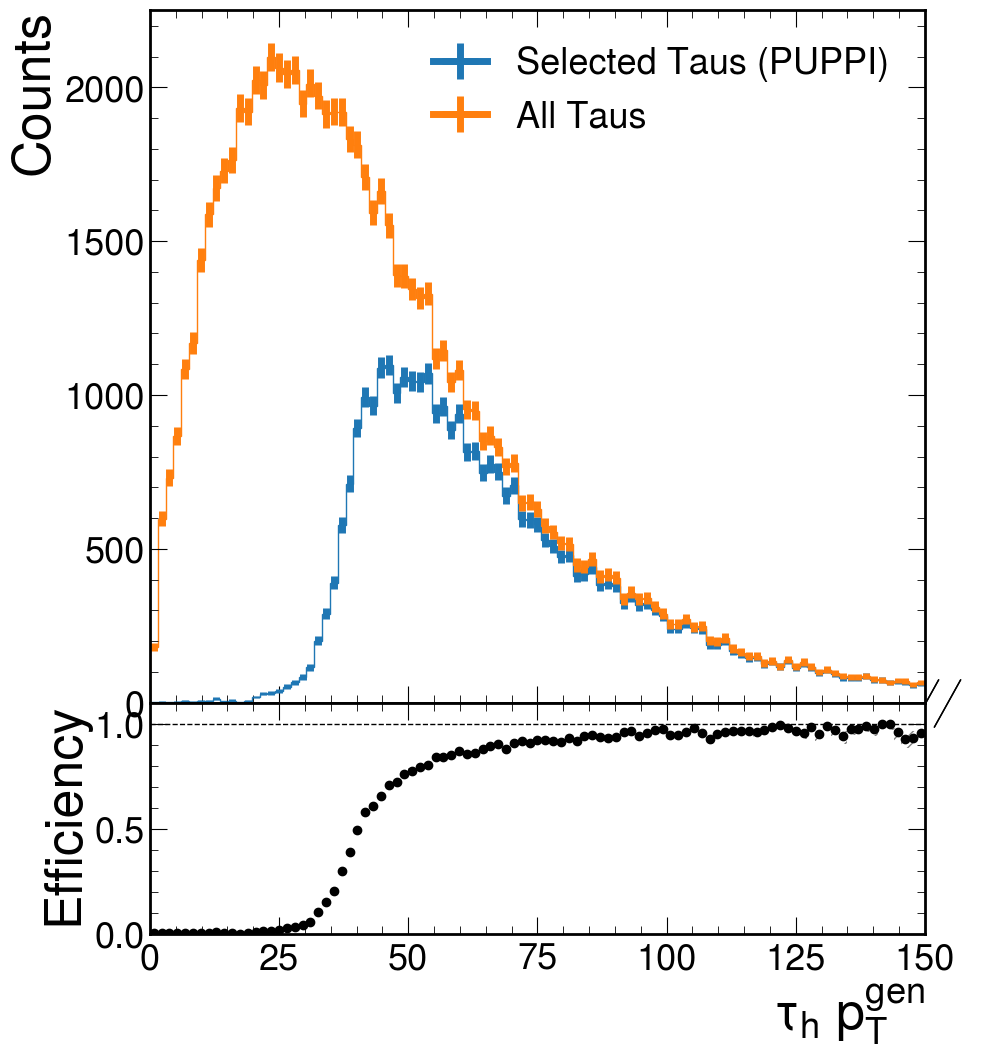

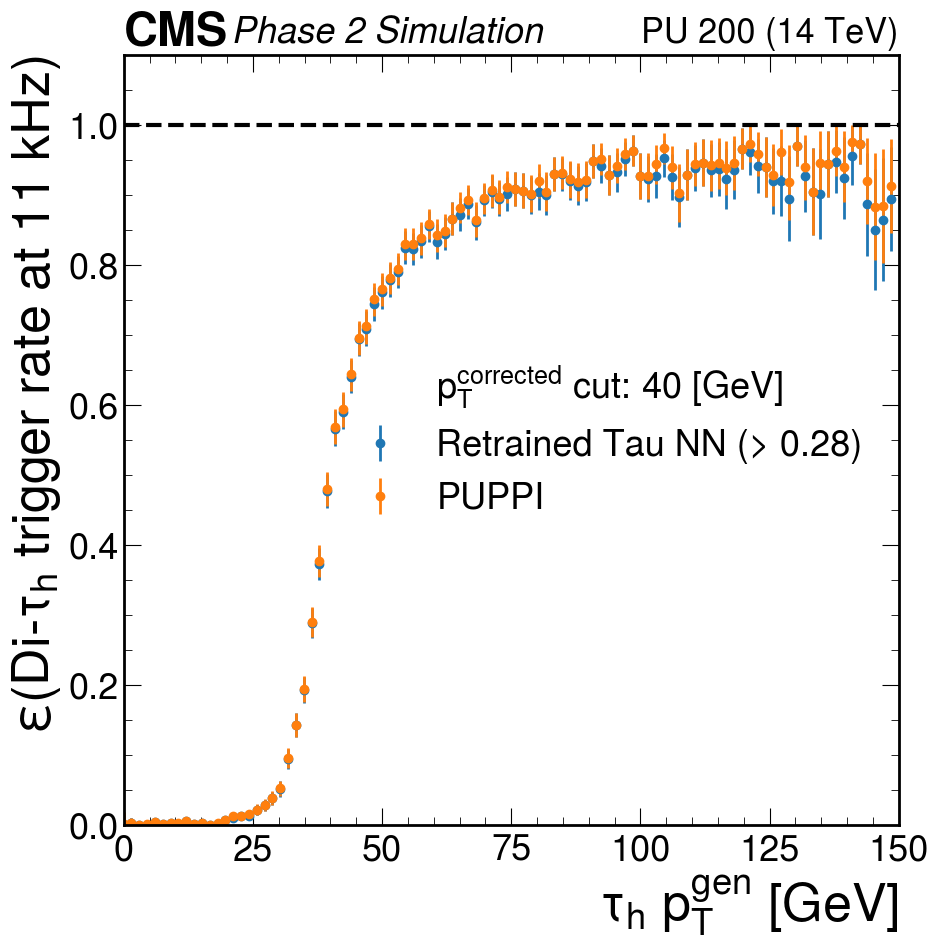

[0.00000000e+00 6.55414473e-01 0.00000000e+00 1.26288353e-01
 4.67854345e-01 1.32584311e-01 3.28042374e-02 8.41115257e-03
 2.06150471e-02 3.00435418e-03 6.47897797e-03 2.35935024e-04
 3.46979211e-03 1.44429766e-02 1.74410613e-02 2.18848413e-02
 2.11000622e-02 3.30450594e-02 4.15520910e-02 5.36315949e-02
 7.22232747e-02 1.25198922e-01 1.87900770e-01 2.53109783e-01
 3.75350980e-01 4.69185981e-01 5.77961185e-01 6.85924605e-01
 7.02295861e-01 7.64059859e-01 8.27838961e-01 8.22079219e-01
 8.68454233e-01 8.73996871e-01 8.84698406e-01 8.86420535e-01
 9.14897725e-01 9.23152253e-01 9.37577420e-01 9.36840068e-01
 9.22862417e-01 9.27802477e-01 9.56633110e-01 9.66675531e-01
 9.65584066e-01 9.51769510e-01 9.57814258e-01 9.75279803e-01
 9.66607911e-01 9.76190064e-01 9.72068370e-01 9.79157270e-01
 9.77645385e-01 9.79750664e-01 9.84271089e-01 9.76509787e-01
 9.95008253e-01 9.80159582e-01 9.91539975e-01 9.82786729e-01
 9.89476212e-01 9.93428200e-01 9.72180827e-01 9.93043709e-01
 9.92337253e-01 9.957929

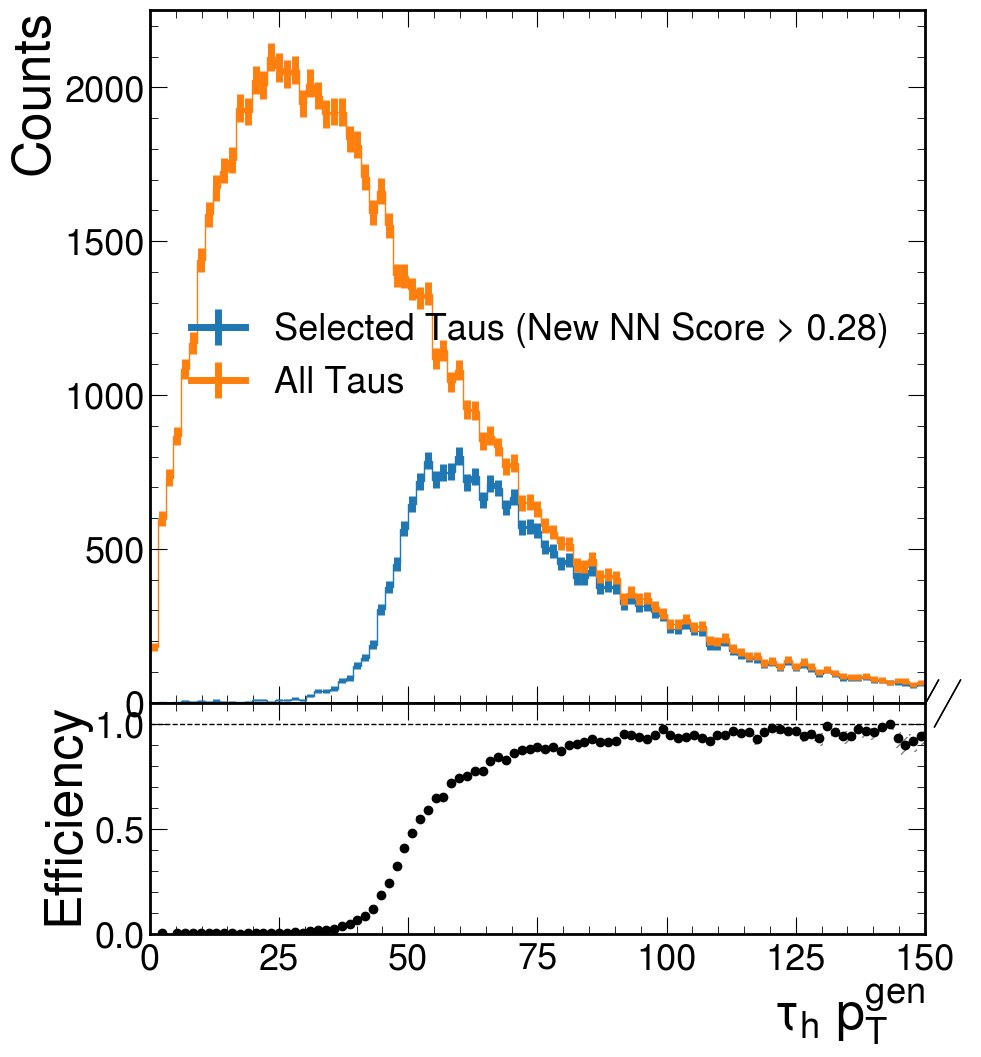

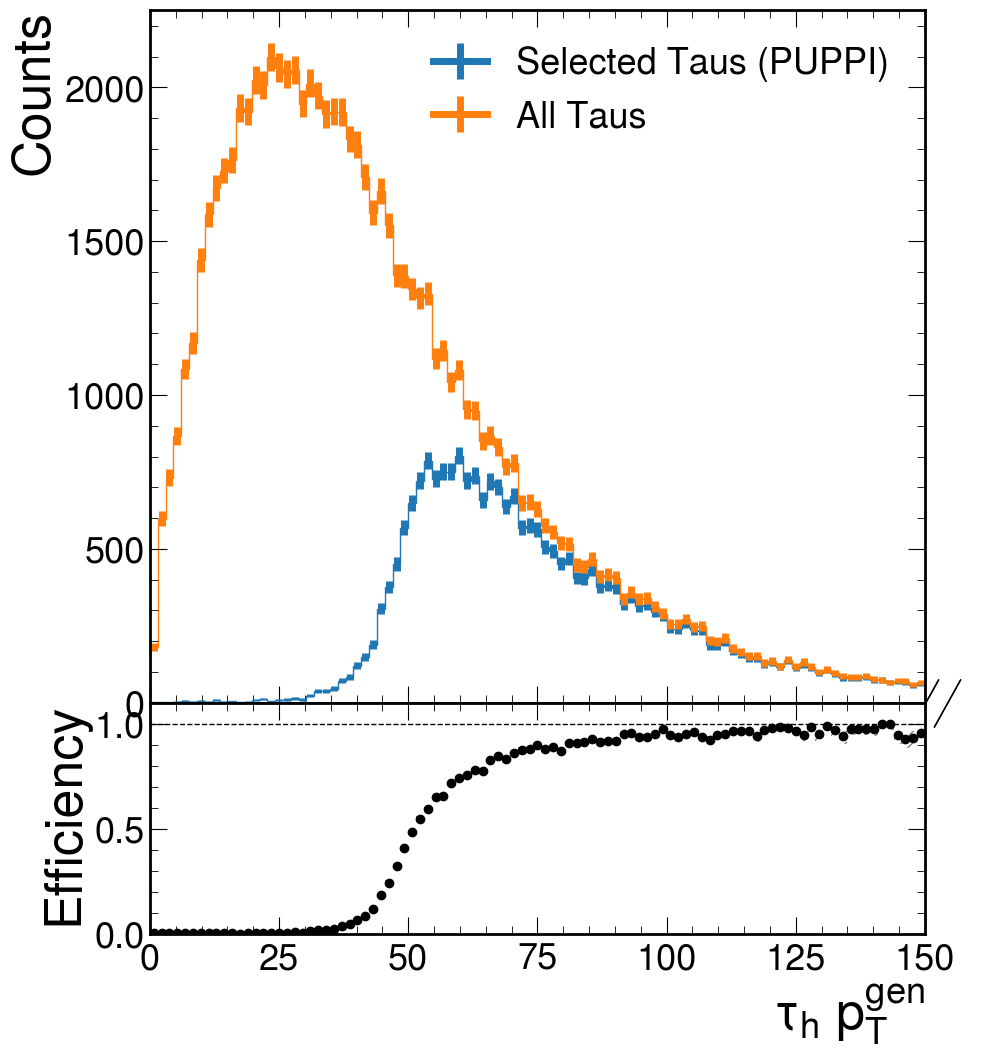

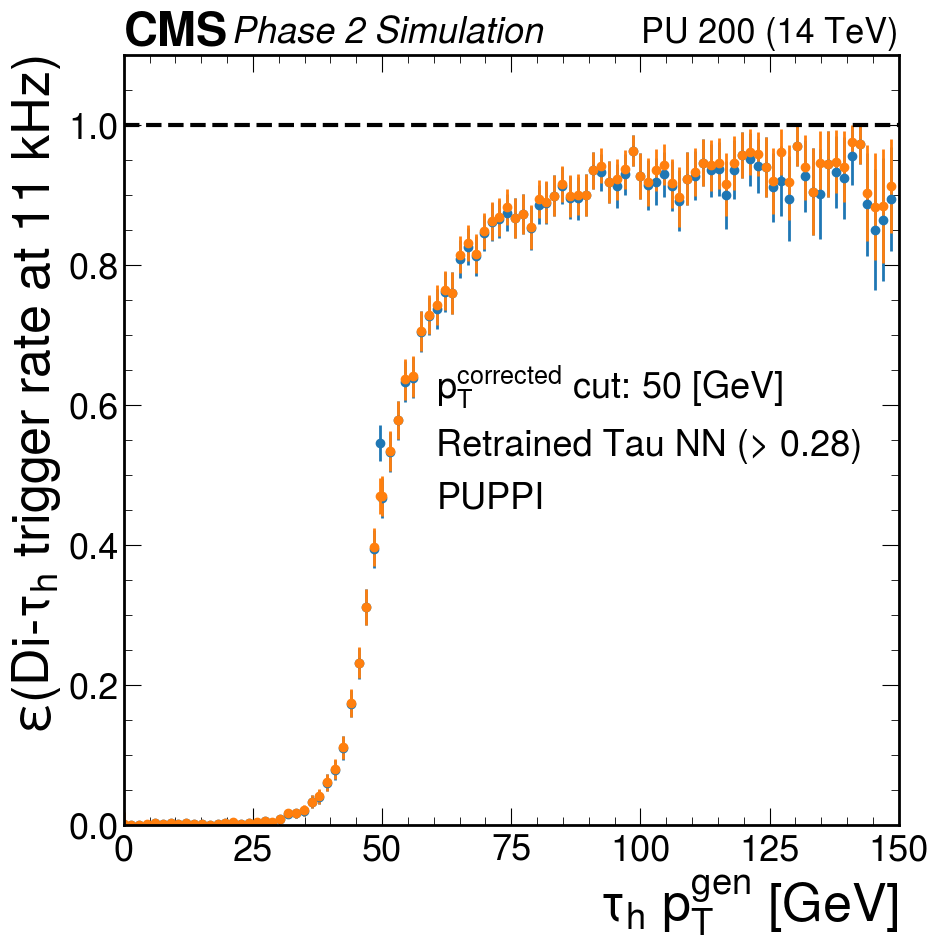

[0.00000000e+00 8.27538798e-02 0.00000000e+00 1.26288353e-01
 3.67041498e-01 1.32584311e-01 2.57362576e-02 2.85544340e-03
 1.17745722e-02 1.55594039e-03 2.44658270e-03 2.35935024e-04
 8.64941283e-04 5.47456477e-03 4.76588081e-03 1.17408529e-03
 4.18272574e-03 4.10954737e-03 6.87999311e-03 4.44479348e-03
 1.22170624e-02 2.10180736e-02 2.13880934e-02 2.63054943e-02
 4.25184695e-02 4.96686530e-02 7.24981140e-02 9.53160881e-02
 1.30918993e-01 2.06172735e-01 2.75531582e-01 3.60909145e-01
 4.60064098e-01 5.36458163e-01 6.06062258e-01 6.48142736e-01
 7.02098567e-01 7.16943106e-01 7.92316515e-01 7.96846456e-01
 8.15825278e-01 8.36370750e-01 8.39062016e-01 8.95431483e-01
 8.98960159e-01 8.98078992e-01 9.07593102e-01 9.28210218e-01
 9.35315201e-01 9.47167359e-01 9.26875090e-01 9.44118650e-01
 9.26903846e-01 9.59677253e-01 9.71245089e-01 9.43277285e-01
 9.77663392e-01 9.55003303e-01 9.71942945e-01 9.62932788e-01
 9.75668392e-01 9.83655585e-01 9.61936947e-01 9.72408021e-01
 9.69818712e-01 9.957929

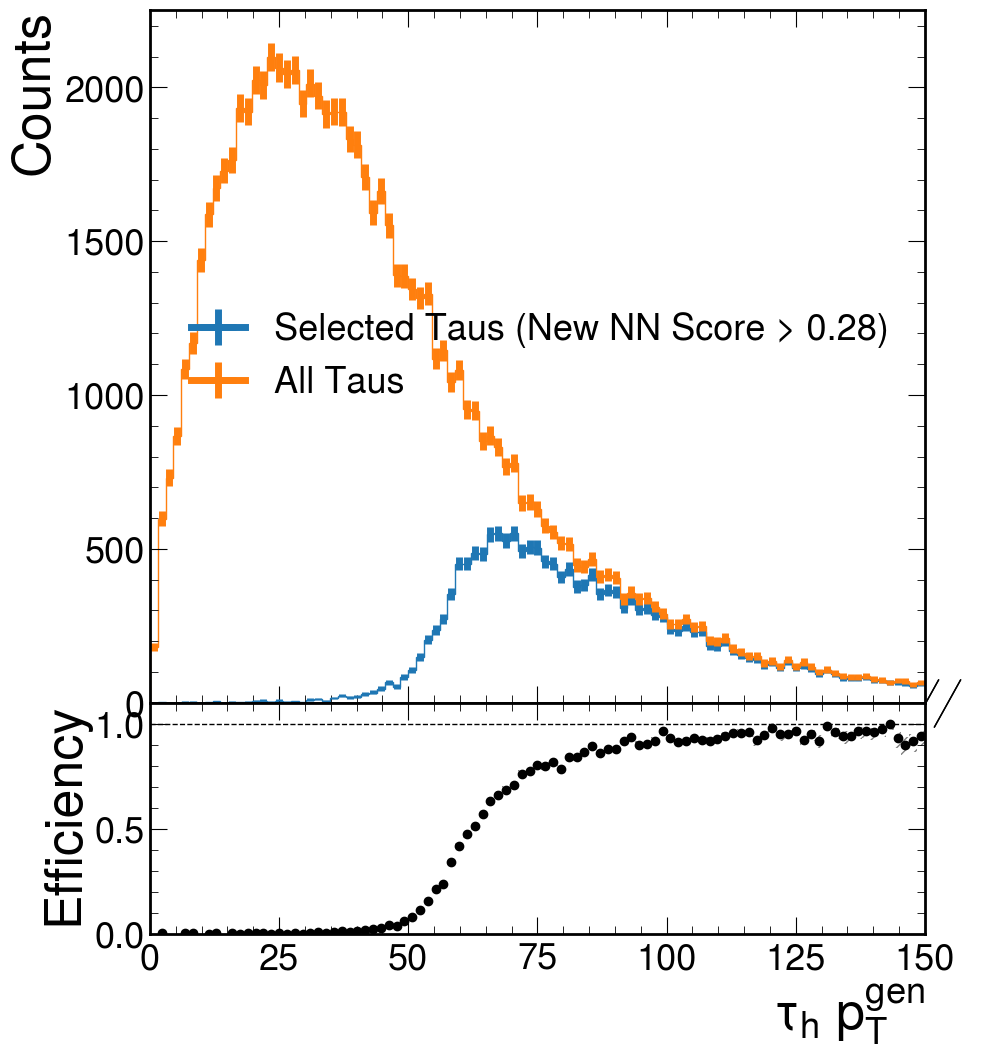

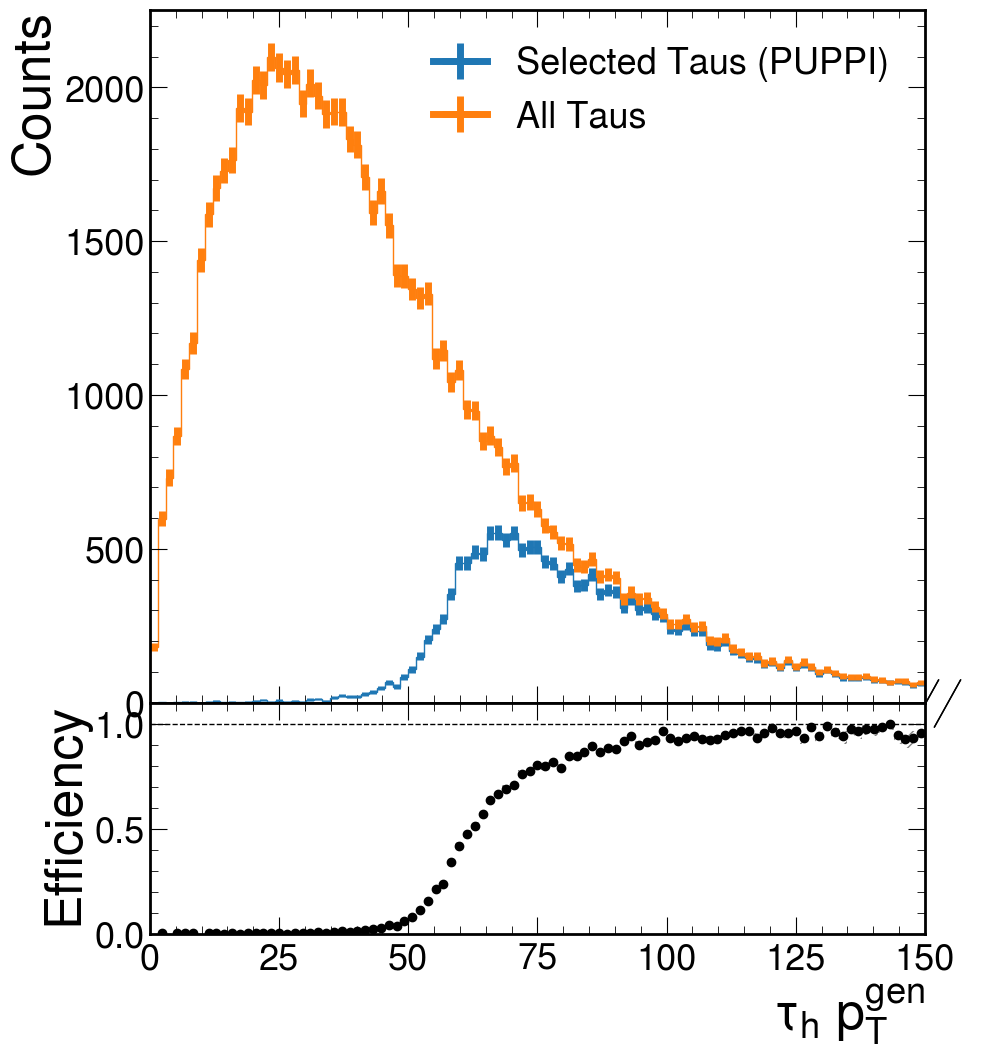

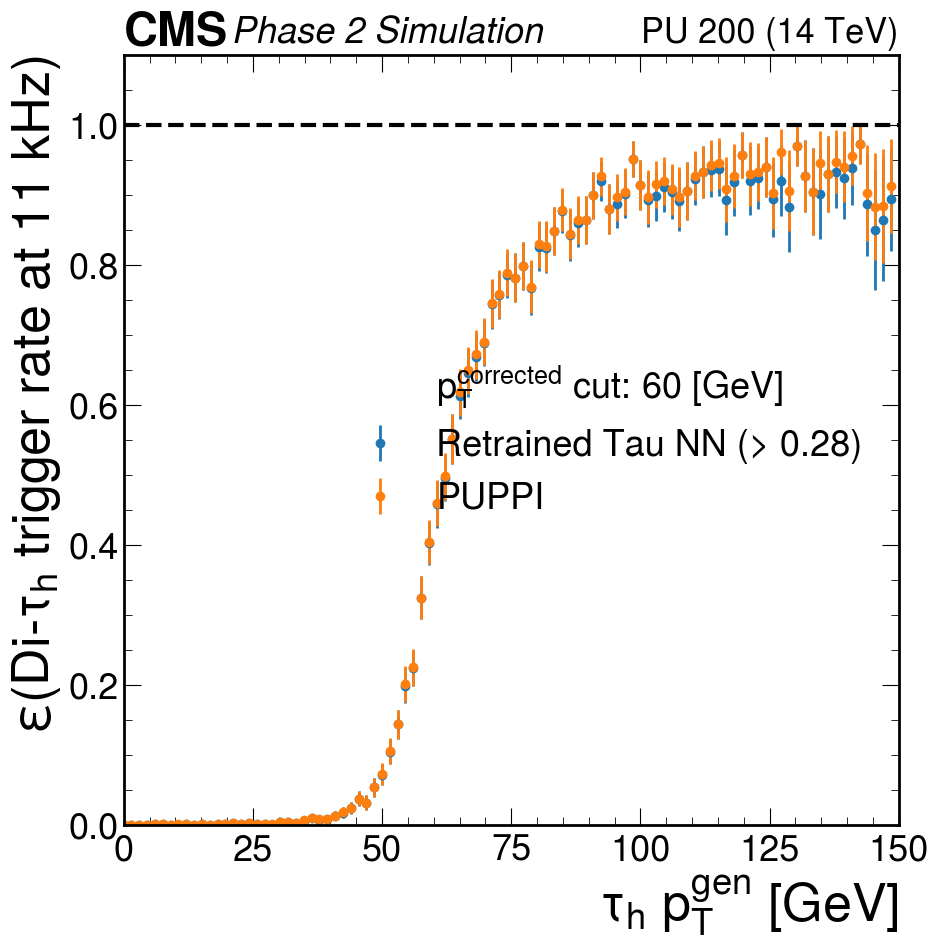

[0.00000000e+00 8.27538798e-02 0.00000000e+00 0.00000000e+00
 9.14792147e-02 6.86615115e-02 0.00000000e+00 6.96450945e-04
 5.55679315e-03 0.00000000e+00 2.44658270e-03 2.35935024e-04
 8.64941283e-04 2.97176207e-03 4.02499150e-03 6.08063606e-04
 3.53249658e-03 5.56093998e-04 1.51923174e-03 1.26712124e-04
 4.85192160e-03 5.82690860e-03 2.49965551e-03 7.66316114e-03
 1.17706809e-02 8.89682212e-03 1.04194506e-02 1.55079569e-02
 2.04399086e-02 2.82310414e-02 4.46744793e-02 3.67215601e-02
 6.24254667e-02 8.21600975e-02 1.18900470e-01 1.61062534e-01
 2.20499790e-01 2.51380308e-01 3.64885155e-01 4.40457644e-01
 5.06905747e-01 5.44288795e-01 6.09126586e-01 6.79861459e-01
 7.02455925e-01 7.39113371e-01 7.39657158e-01 8.01422689e-01
 8.18819140e-01 8.50607421e-01 8.36020745e-01 8.62882969e-01
 8.33551439e-01 8.93611600e-01 9.01799361e-01 8.90562589e-01
 9.38550207e-01 8.97263388e-01 9.33198065e-01 9.23731909e-01
 9.38511523e-01 9.70751916e-01 9.21583672e-01 9.45289197e-01
 9.40476723e-01 9.834076

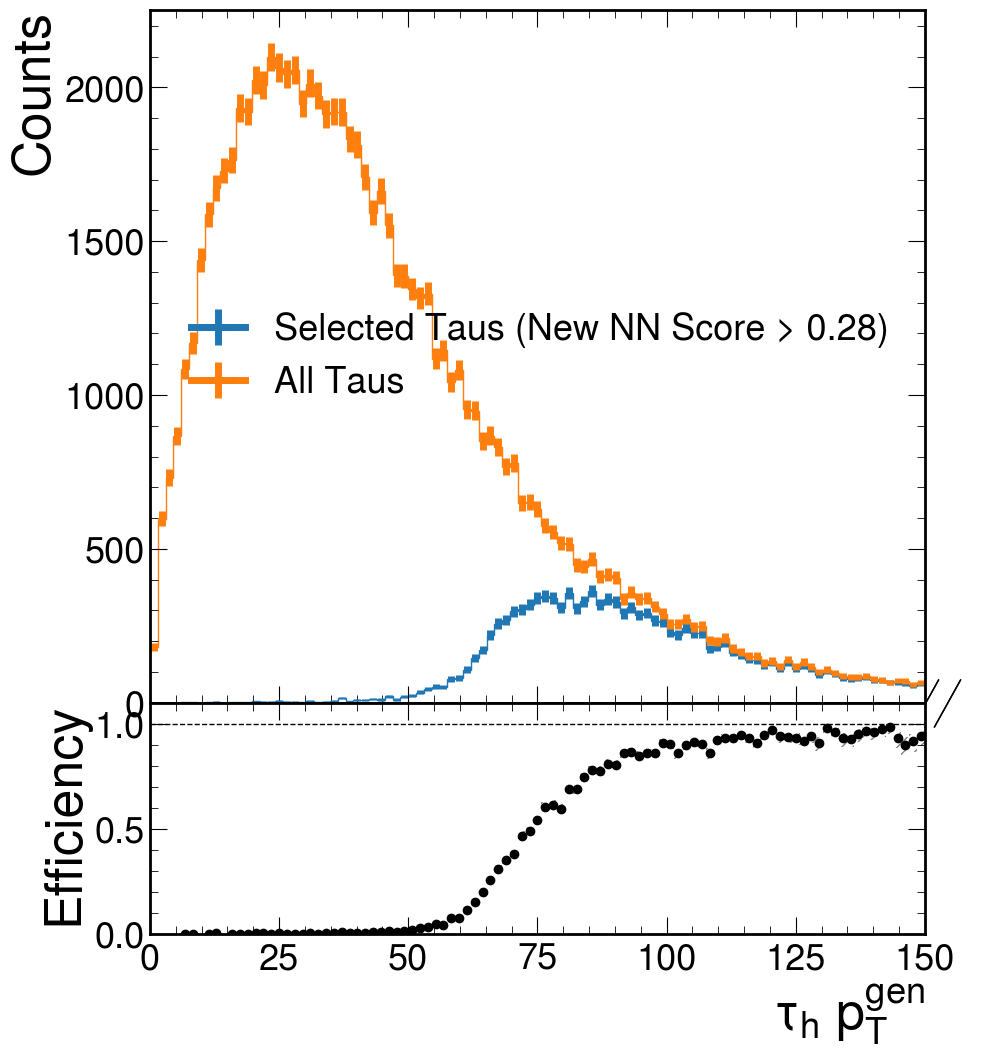

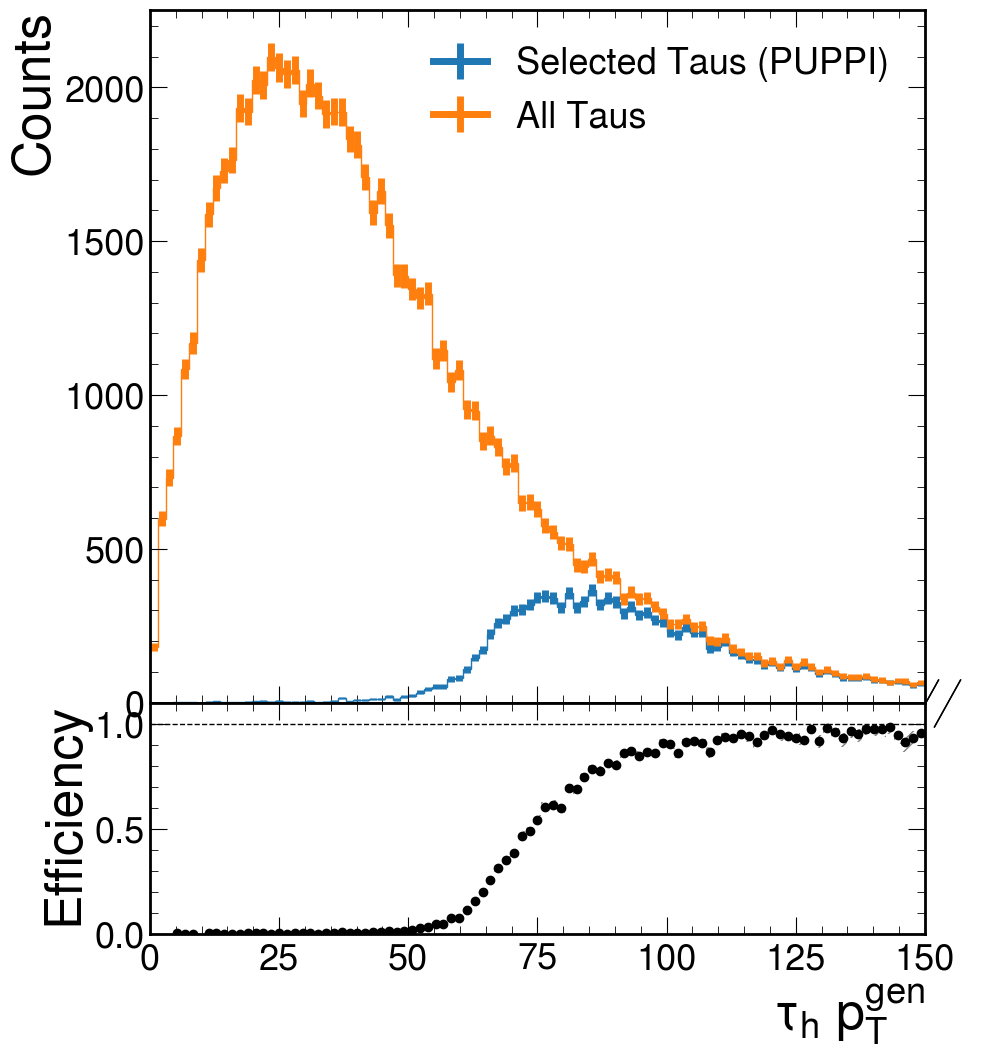

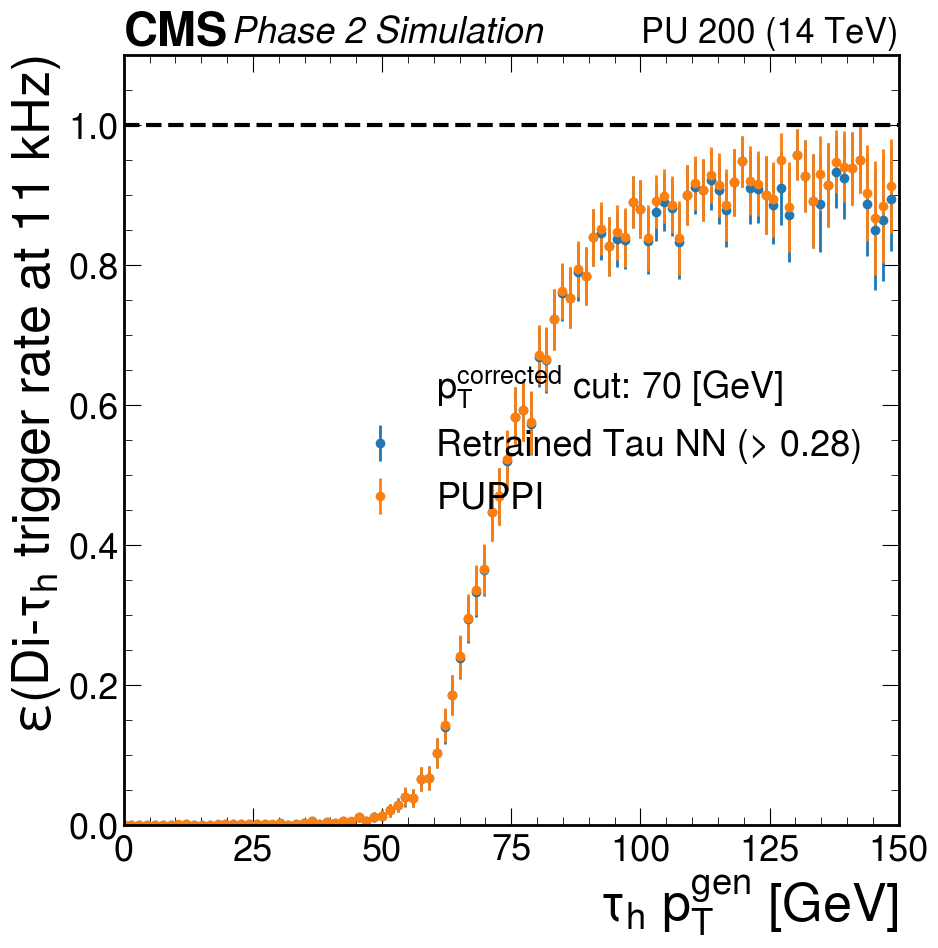

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.23105298e-02 1.67458622e-02 0.00000000e+00 6.96450945e-04
 3.64255614e-03 0.00000000e+00 3.09047996e-04 2.35935024e-04
 2.10967051e-04 2.18205549e-03 1.24522167e-03 6.08063606e-04
 2.27051877e-03 5.56093998e-04 5.15776483e-04 1.26712124e-04
 2.54829797e-03 1.17180024e-04 9.43932075e-04 2.48246397e-03
 7.57875876e-03 1.43559339e-03 4.05252065e-03 3.71283931e-03
 5.78962210e-03 4.95211172e-03 1.26816260e-02 5.75836834e-03
 1.23772211e-02 1.48560262e-02 2.36521243e-02 3.16446943e-02
 4.36752379e-02 4.22253615e-02 7.38694215e-02 7.33020318e-02
 1.12931888e-01 1.53775201e-01 2.05411207e-01 2.64389557e-01
 3.19136550e-01 3.67004910e-01 3.90211767e-01 4.81537902e-01
 5.07264840e-01 5.62192304e-01 6.23728597e-01 6.40124320e-01
 6.22716167e-01 7.23105589e-01 7.25709225e-01 7.57842186e-01
 8.14192001e-01 8.02776491e-01 8.56878482e-01 8.38418414e-01
 8.75885232e-01 8.92028997e-01 8.65503563e-01 8.91924809e-01
 8.72456429e-01 9.202349

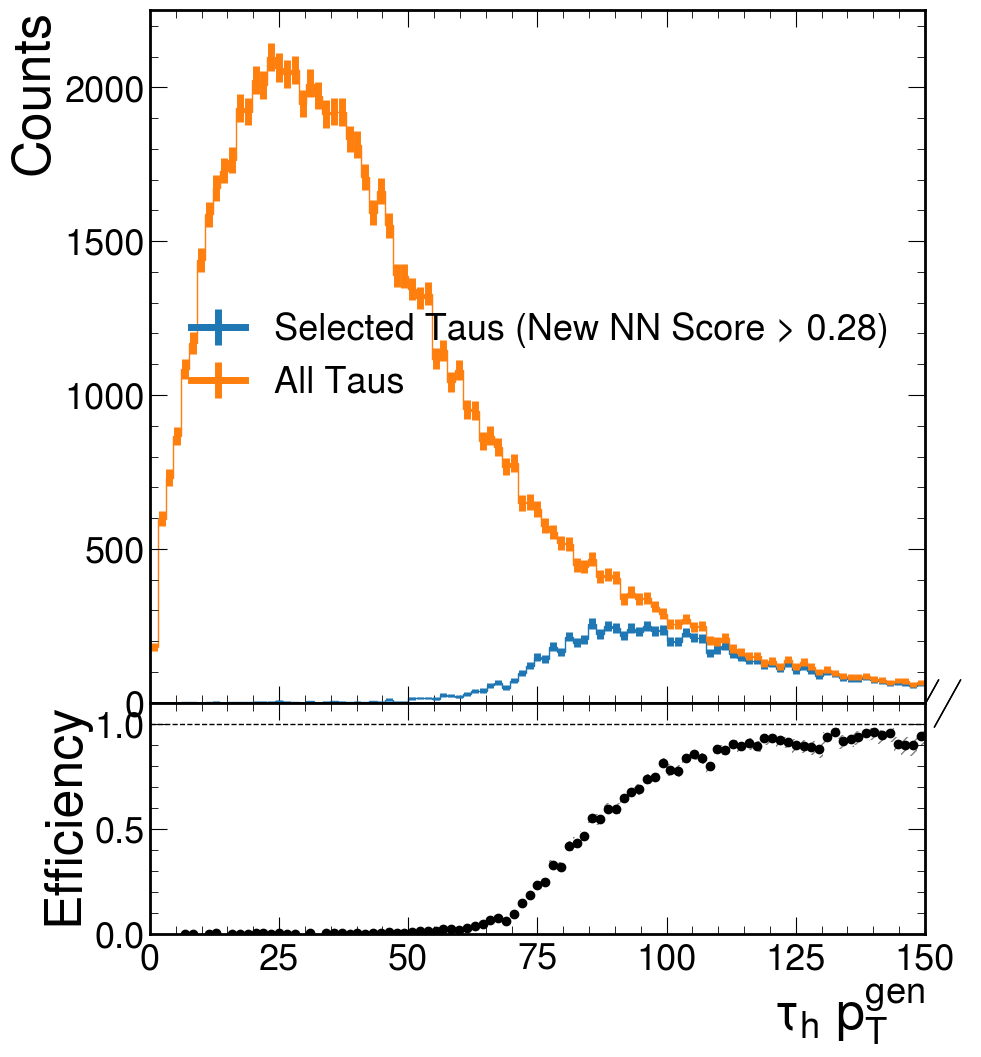

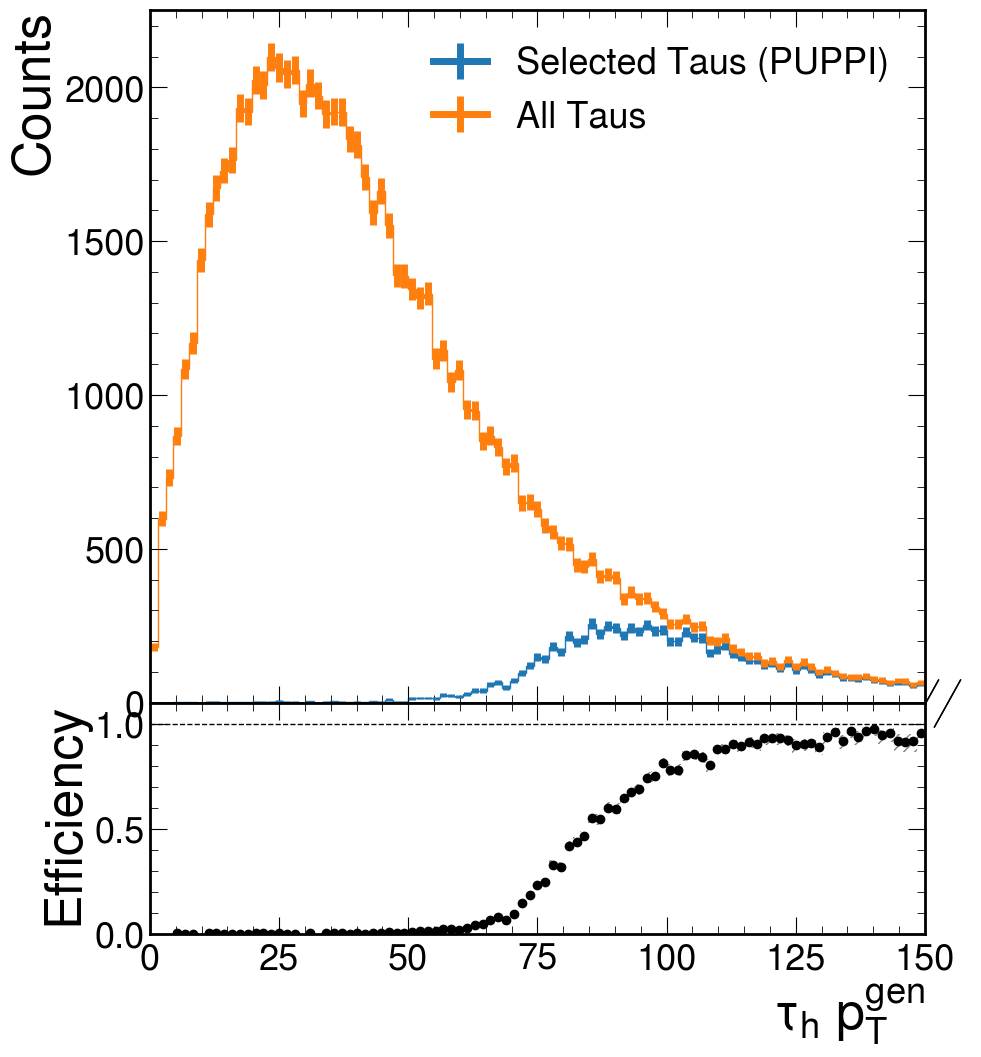

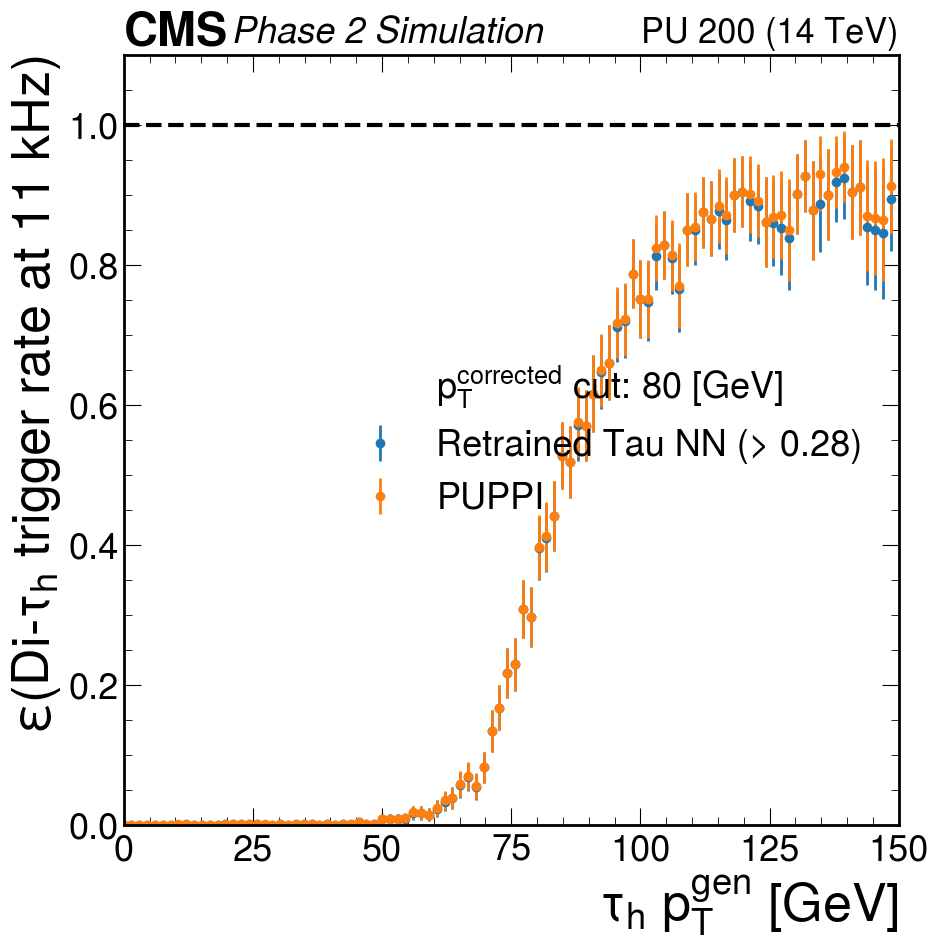

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.23105298e-02 1.67458622e-02 0.00000000e+00 6.96450945e-04
 1.88645572e-03 0.00000000e+00 3.09047996e-04 2.35935024e-04
 2.10967051e-04 1.43038909e-03 1.24522167e-03 6.08063606e-04
 2.27051877e-03 5.56093998e-04 1.25803586e-04 0.00000000e+00
 1.46800238e-03 0.00000000e+00 4.88862463e-04 1.43006932e-03
 9.27115501e-04 1.18873848e-04 9.14546374e-04 1.22532429e-04
 1.56056279e-03 9.82105042e-04 5.30881082e-03 1.14190203e-03
 1.15170906e-03 8.82153951e-03 9.67637667e-03 9.44360102e-03
 9.38159275e-03 1.87930265e-02 1.87371206e-02 1.58085418e-02
 2.54363832e-02 3.59252338e-02 4.27097454e-02 6.22477858e-02
 7.37734060e-02 5.95049951e-02 8.80123658e-02 1.44261232e-01
 1.80794419e-01 2.34849893e-01 2.44943396e-01 3.33078367e-01
 3.22832295e-01 4.27807300e-01 4.48146651e-01 4.63284811e-01
 5.64701384e-01 5.52176838e-01 6.19867107e-01 6.10028808e-01
 6.42987789e-01 6.82160838e-01 6.91701354e-01 7.58177617e-01
 7.50304428e-01 8.141879

In [24]:
results = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_nn = gen_pT_list


1905/1905 [==============================] - 2s 769us/step


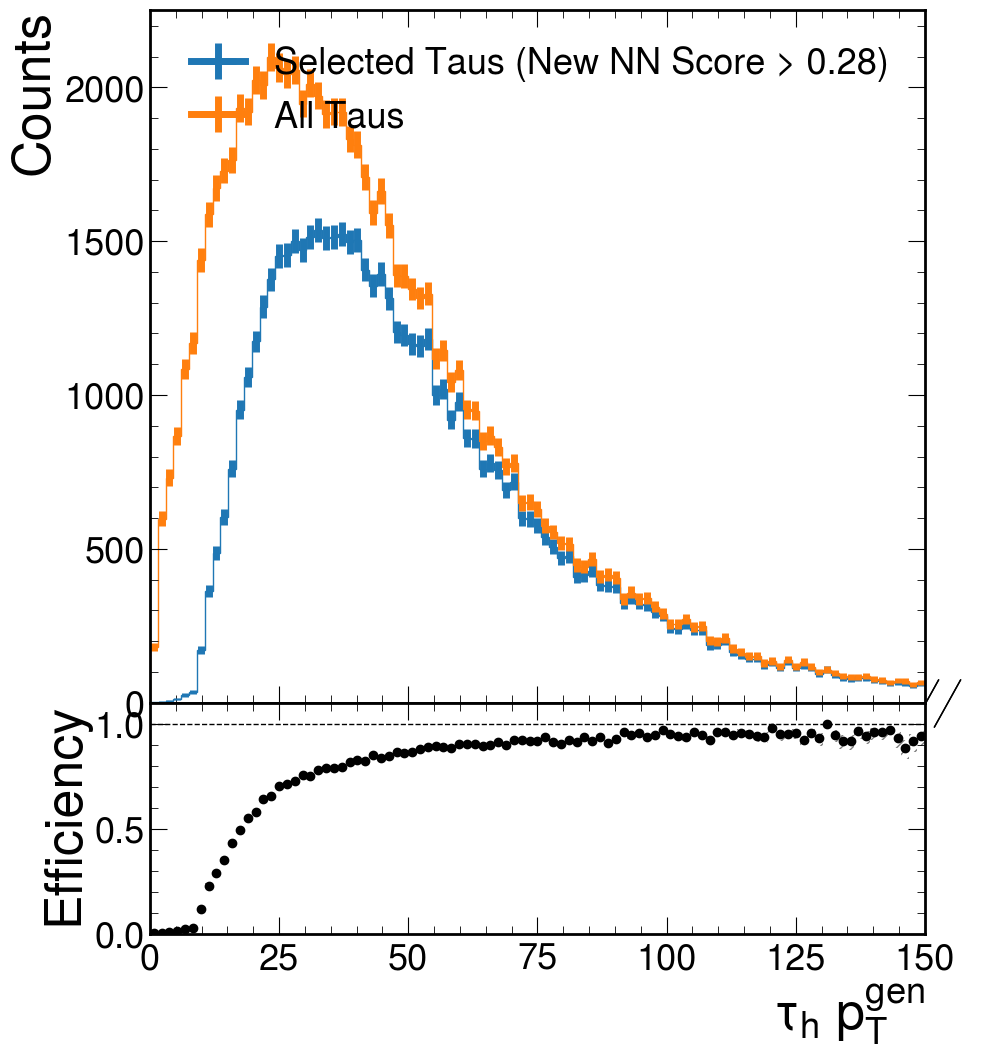

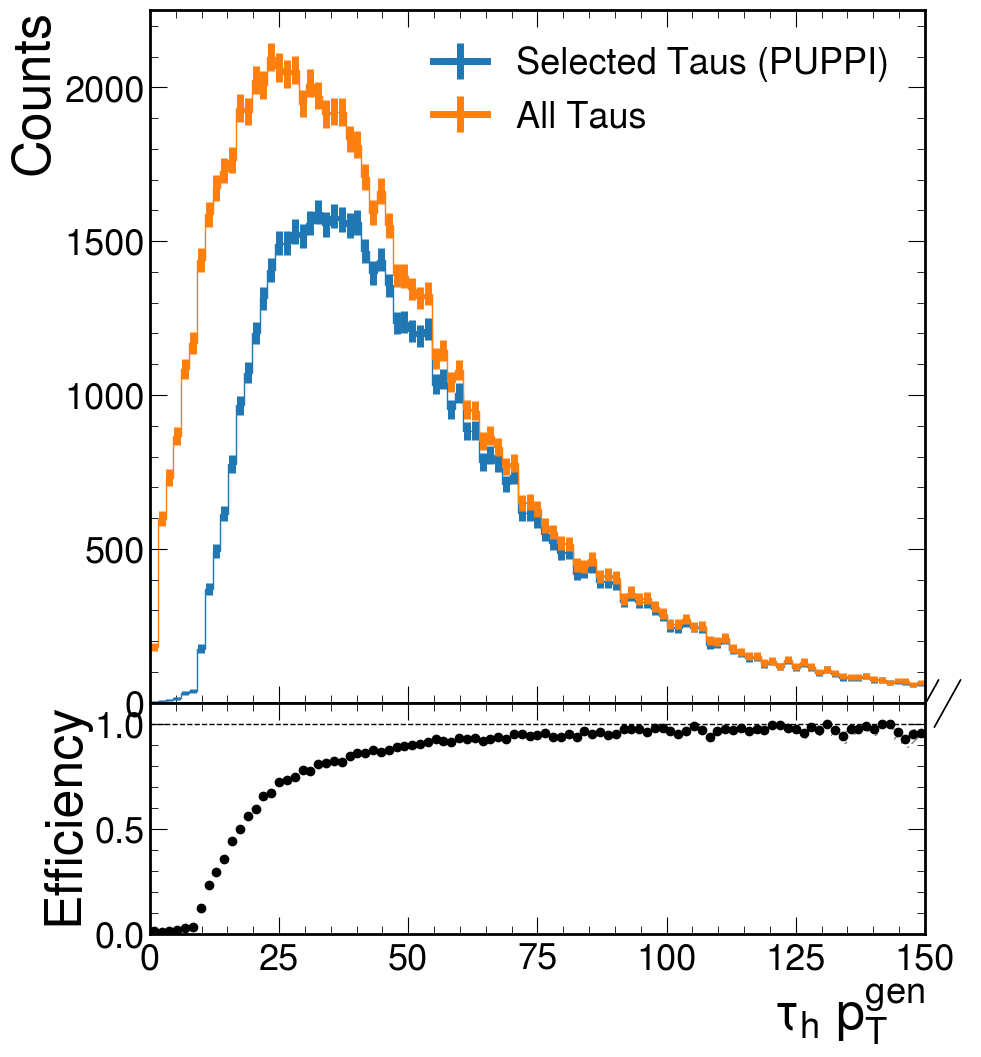

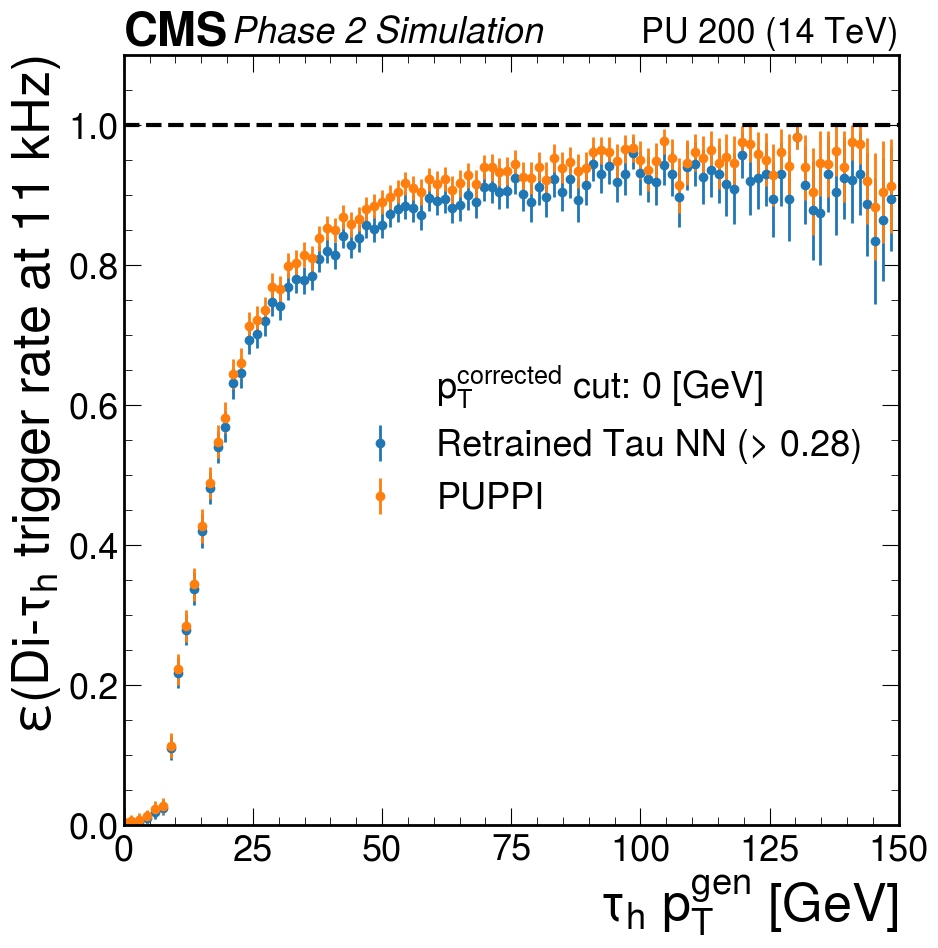

1743/1743 [==============================] - 2s 814us/step


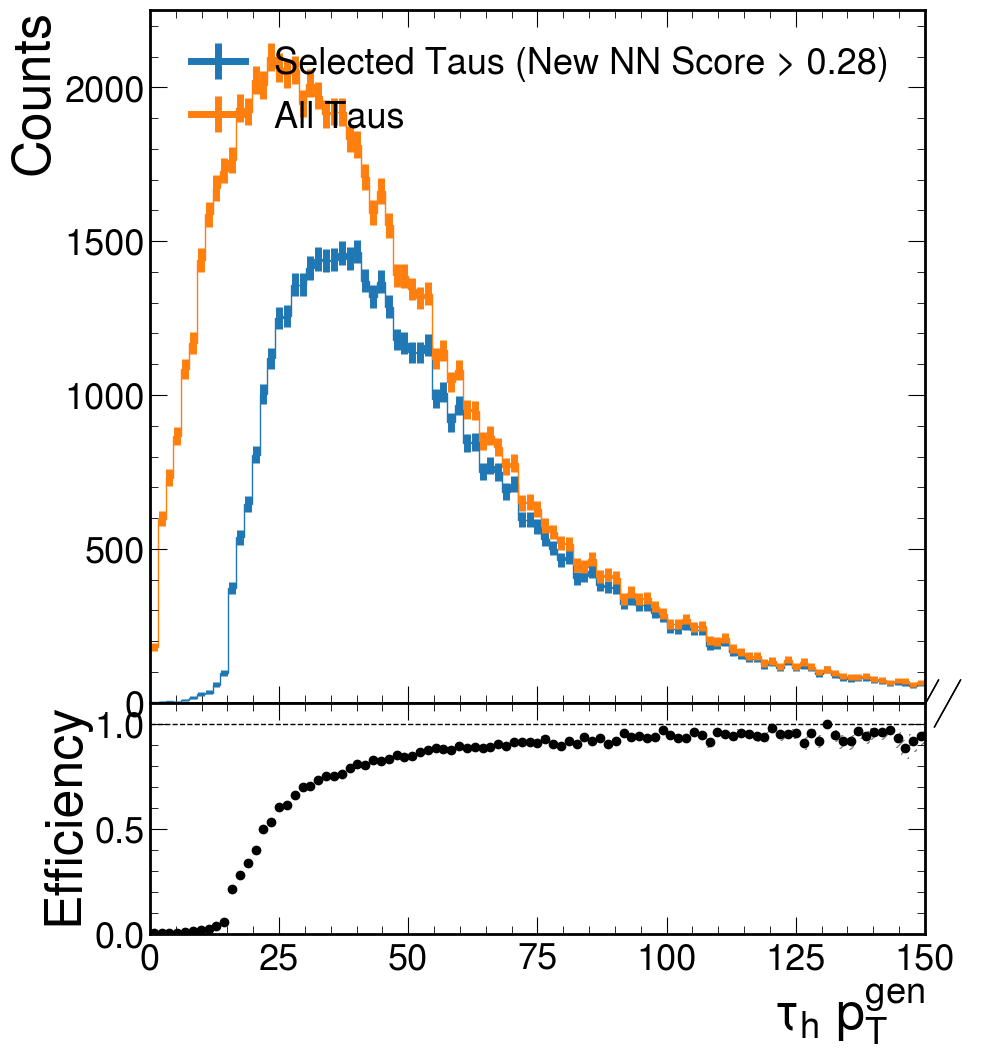

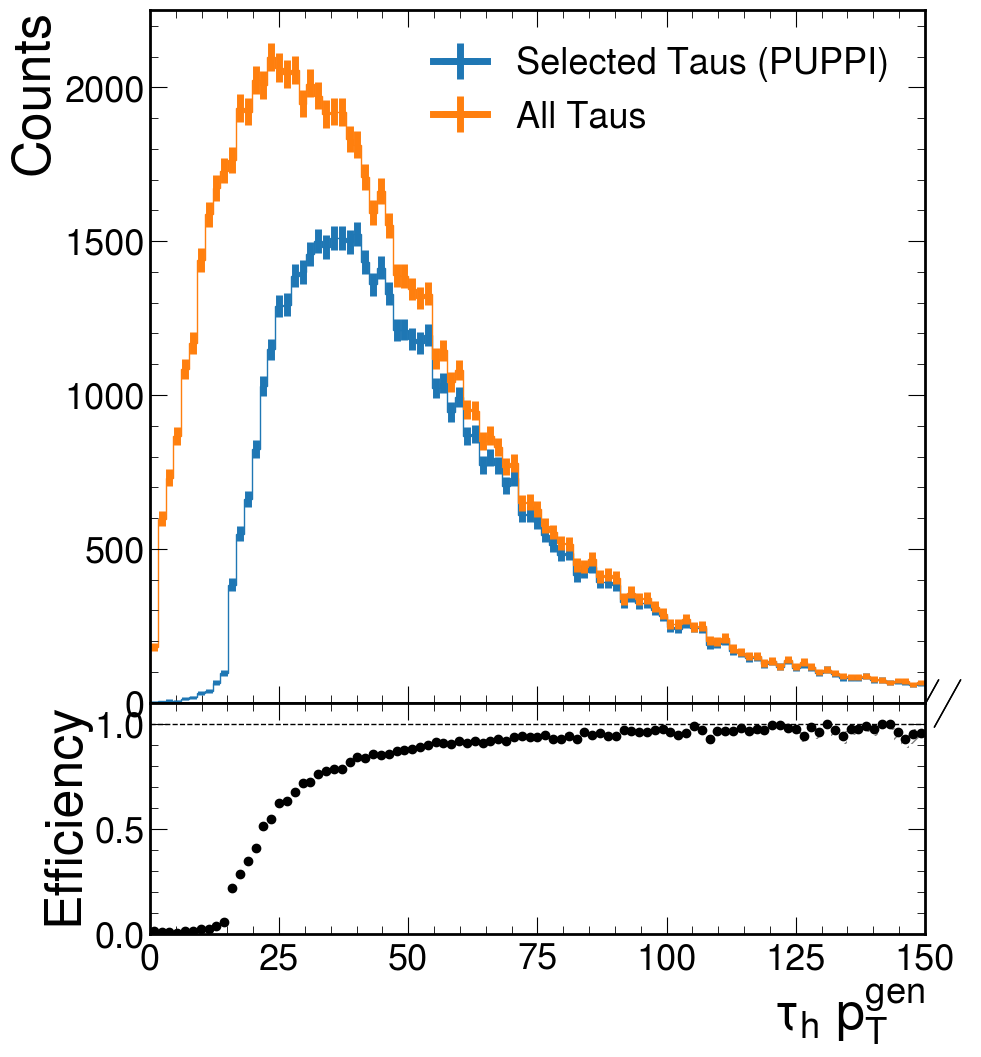

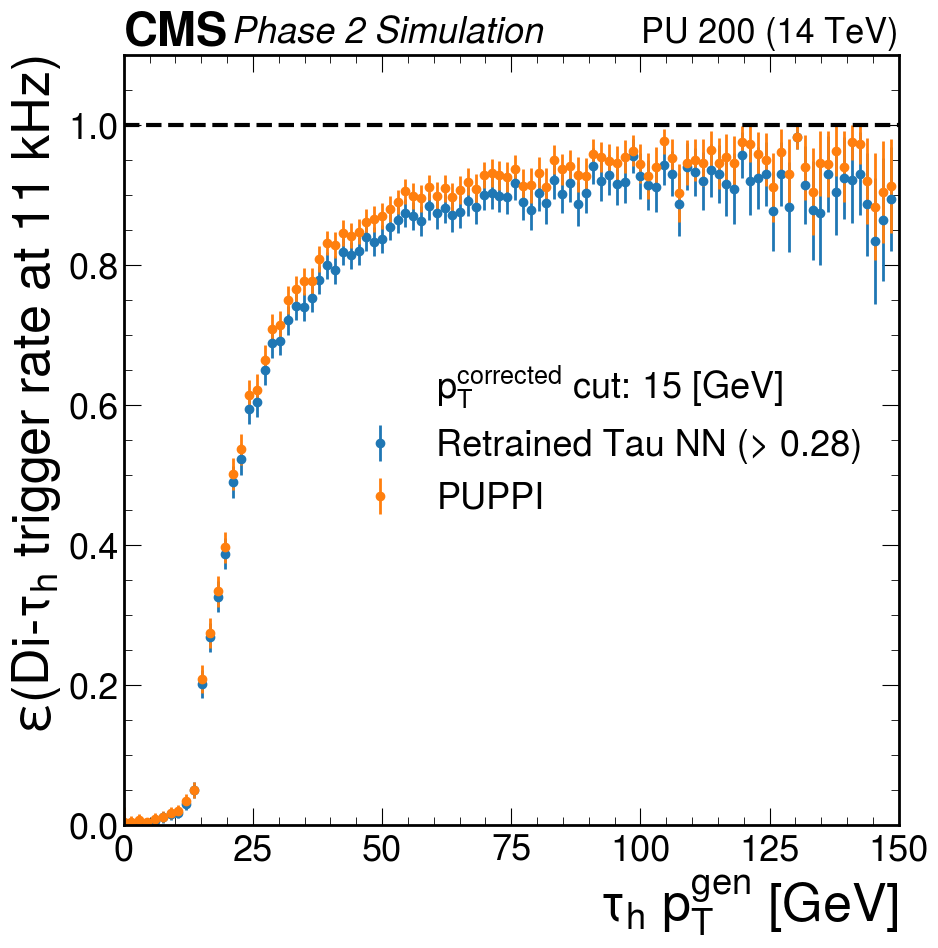

[1.         0.5177983  0.73418389 0.15910602 0.31622655 0.42671831
 0.13870902 0.07918877 0.1083452  0.14667606 0.48075465 0.55623416
 0.60345026 0.68065746 0.77565383 0.80942149 0.85714783 0.86091398
 0.90444505 0.92133143 0.93224309 0.93723179 0.95100642 0.95110827
 0.95950562 0.96287633 0.97396526 0.97362209 0.97252711 0.98146564
 0.97874334 0.97930024 0.97826957 0.9768138  0.98023251 0.98322902
 0.9874272  0.98768769 0.98975291 0.98710939 0.98039848 0.98526373
 0.98751263 0.98915351 0.9901868  0.99233091 0.98813545 0.99105065
 0.99462349 0.99070247 0.99193335 0.98728663 0.98855978 0.99091136
 0.98939006 0.99735037 0.99746589 0.99427322 0.99426126 0.98839861
 0.99649288 0.99014149 0.986004   0.99650123 0.98858055 0.99583853
 0.99529509 0.99059704 0.99116905 1.         1.         0.98788511
 1.         0.98845033 0.9929863  1.         1.         1.
 1.         1.         1.         1.         1.         0.98104266
 1.         0.98723305 1.         1.         1.         1.
 1.        

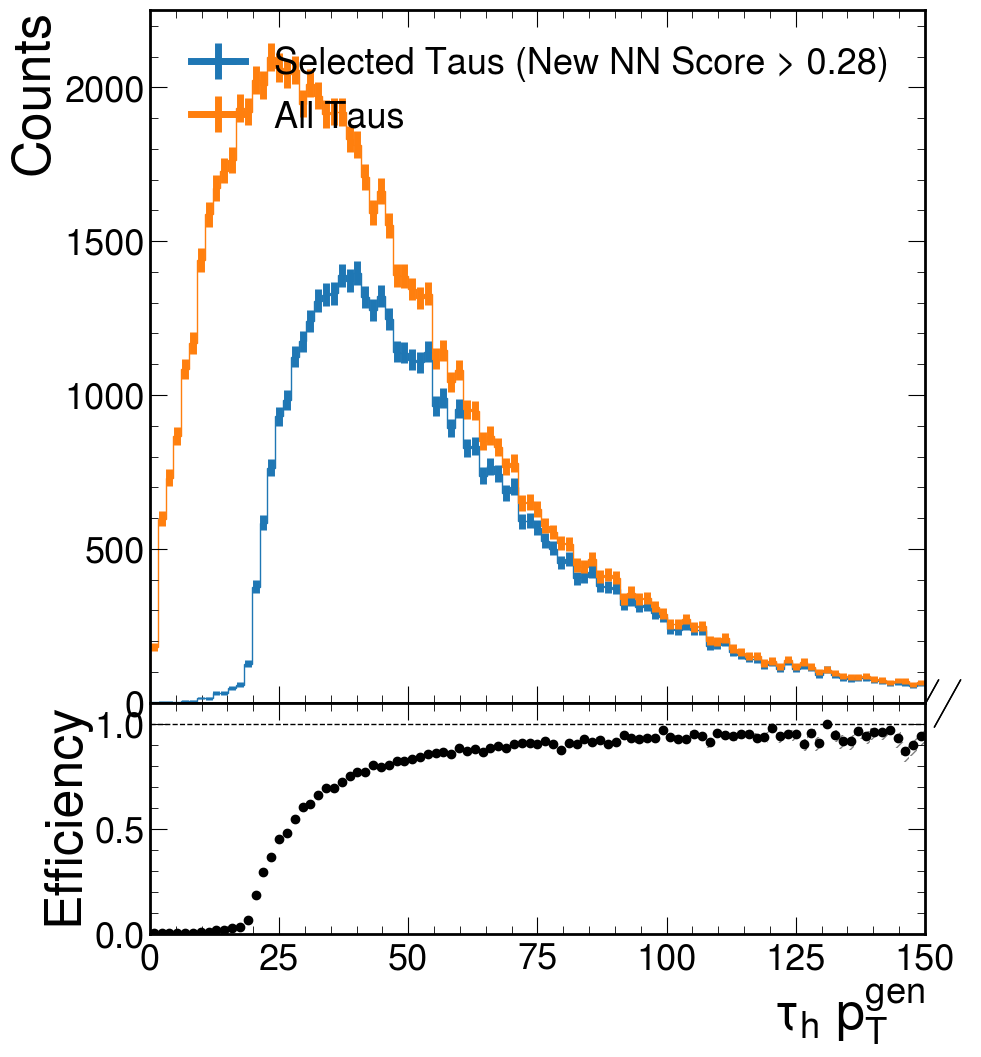

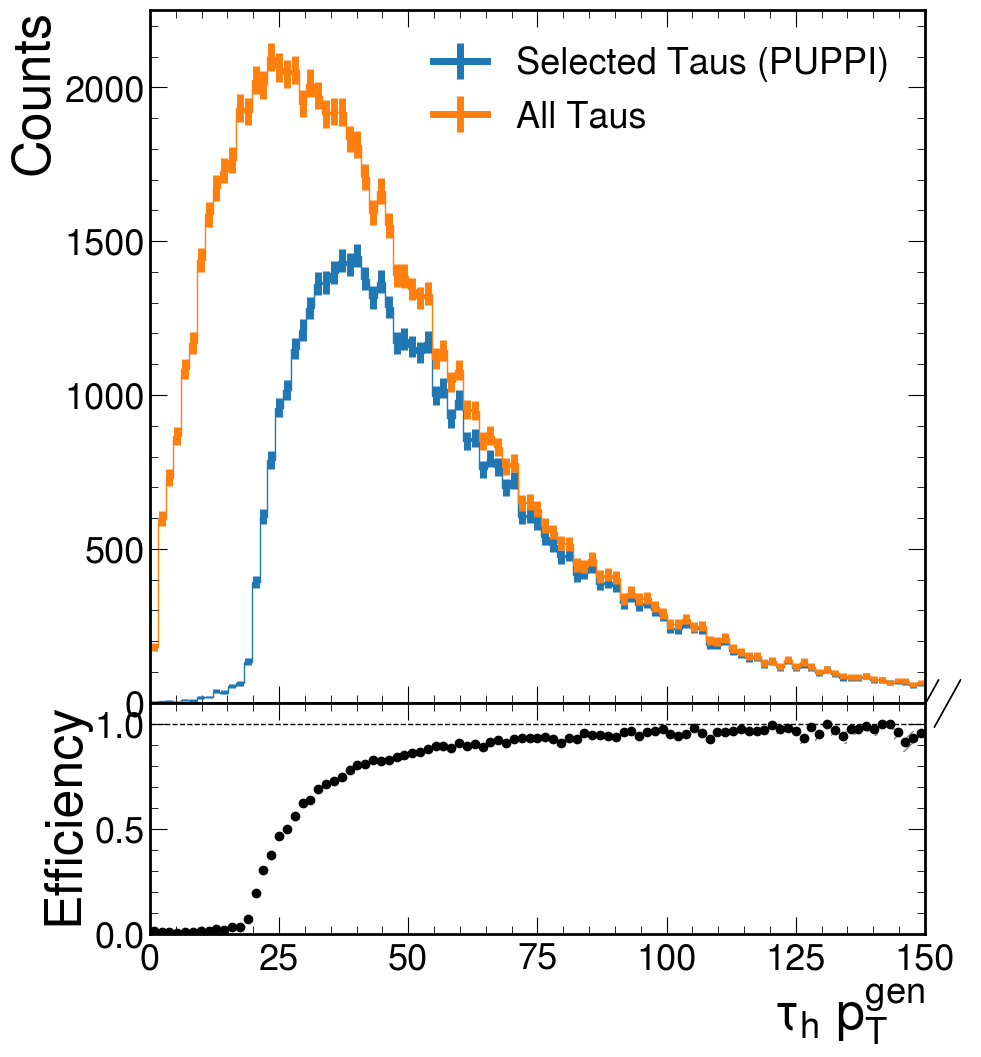

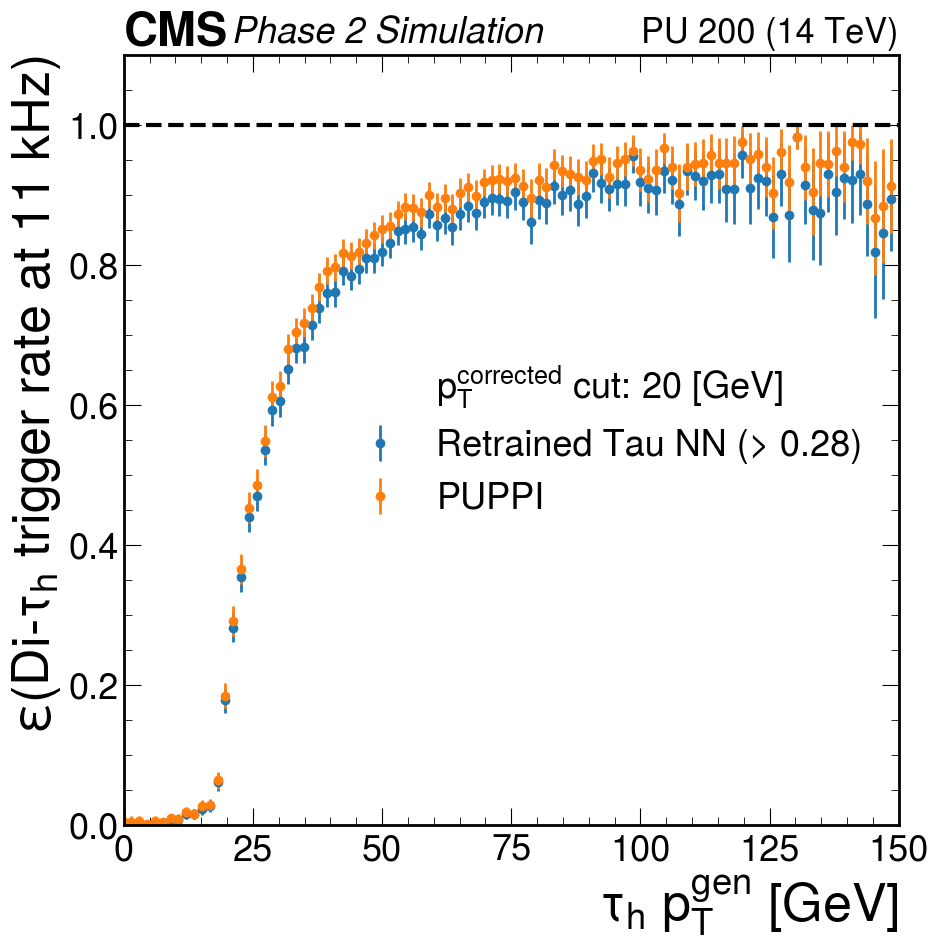

[1.         0.5177983  0.48121536 0.02009324 0.18896319 0.12819086
 0.07092525 0.02988478 0.05665289 0.0453095  0.05438923 0.05532855
 0.11206454 0.3121127  0.44617673 0.54788112 0.63468669 0.67019629
 0.74546643 0.79309687 0.81614391 0.84674992 0.87504441 0.87665306
 0.91036086 0.91351957 0.92613755 0.93488128 0.93980466 0.94670035
 0.94733003 0.94491093 0.95139725 0.95546822 0.95247023 0.96386415
 0.96236668 0.96926864 0.96817719 0.97532432 0.96209343 0.96935337
 0.96815081 0.98644598 0.98179628 0.98314731 0.97631565 0.98213045
 0.98925677 0.9851381  0.97789011 0.98728663 0.96806209 0.9795976
 0.98939006 0.98942597 0.99493449 0.98287552 0.99426126 0.98262216
 0.98604853 0.98687037 0.96529832 0.99650123 0.98479544 0.99583853
 0.98594472 0.98592007 0.98677333 0.99028186 0.99041153 0.98788511
 0.99380179 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 1.         0.98919063 0.97164876
 1.         0.97459075 1.         1.         1.         1.
 1. 

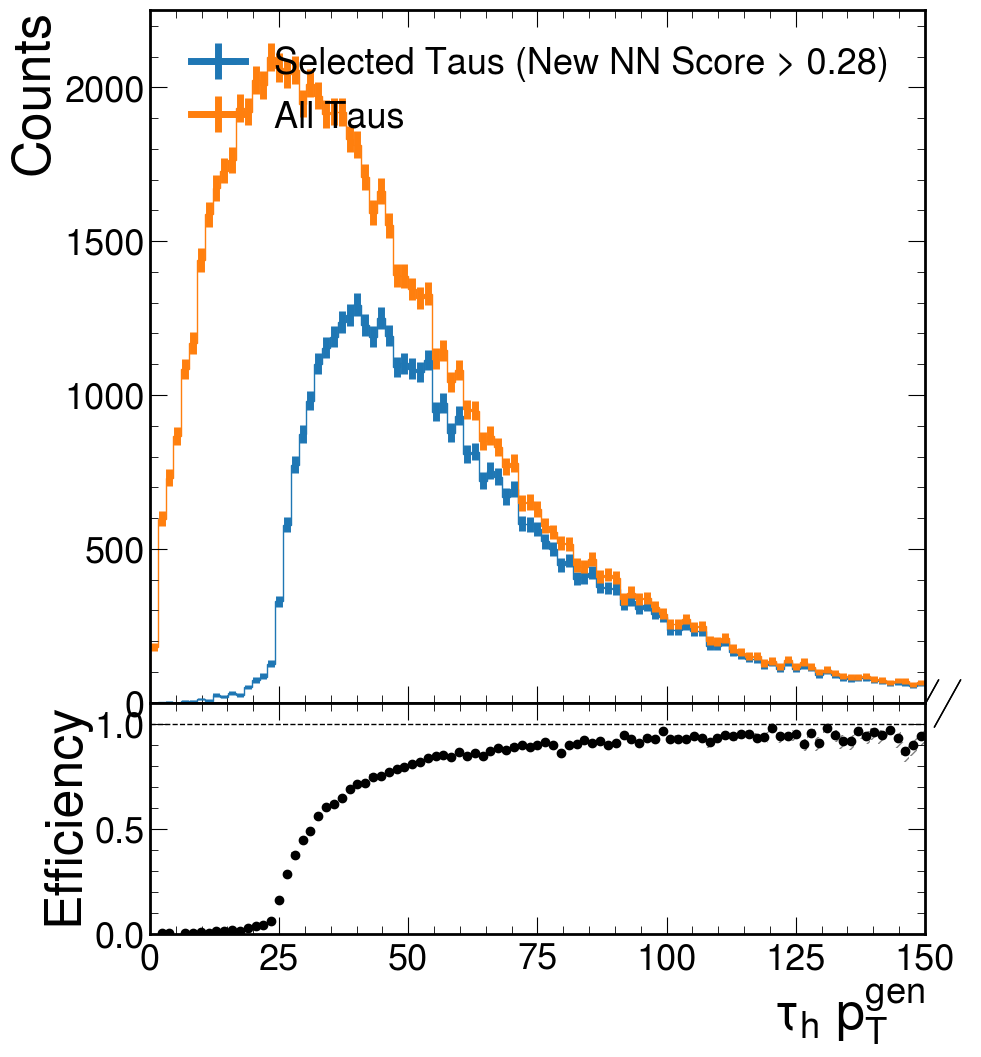

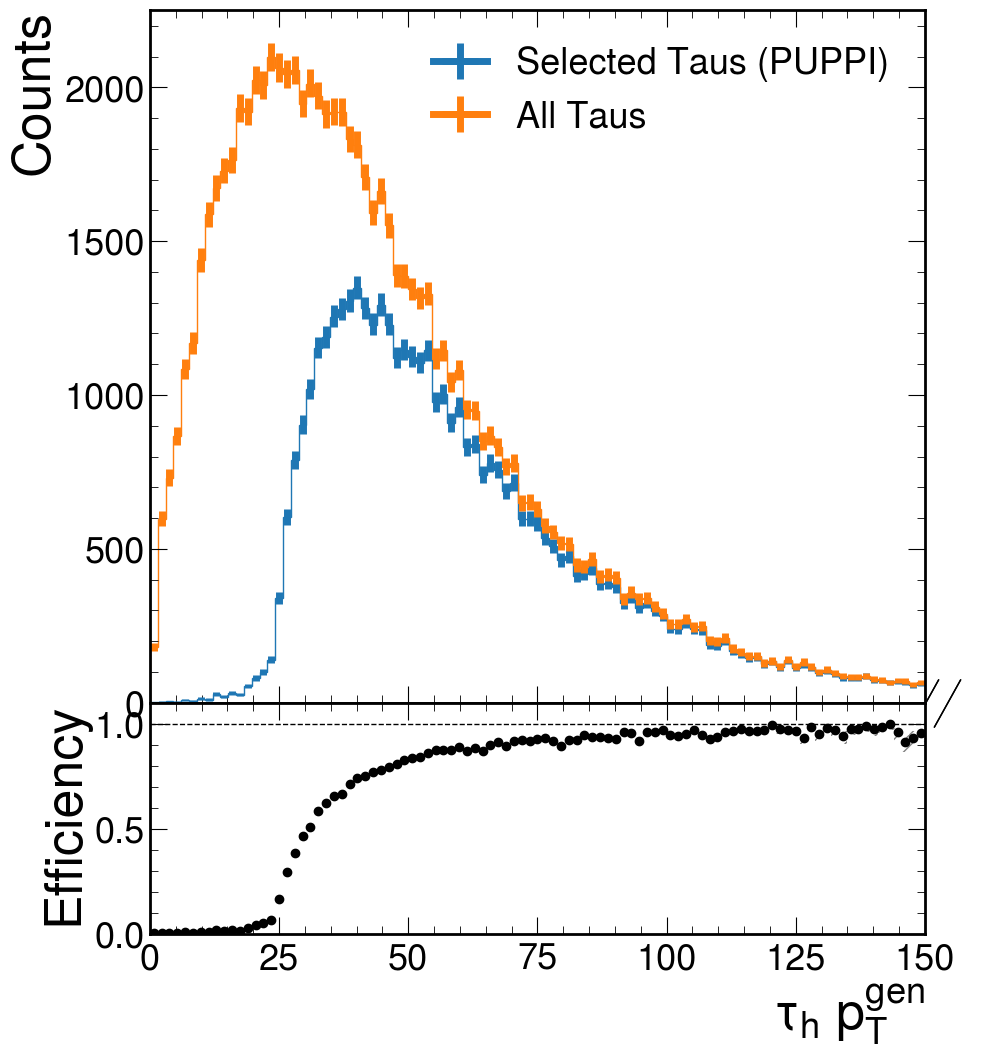

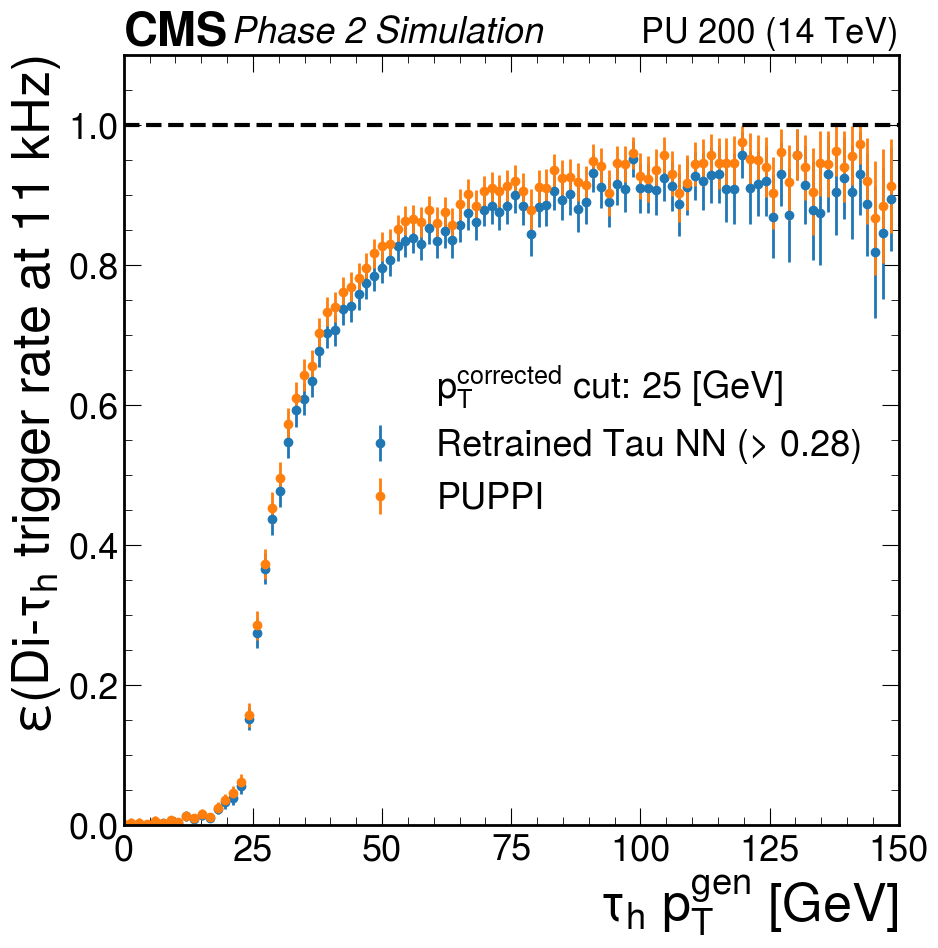

[0.         0.1262619  0.24918539 0.         0.18896319 0.12819086
 0.04909822 0.0128112  0.04302673 0.02521074 0.03323254 0.02060658
 0.04153959 0.05611162 0.0600495  0.08572306 0.21825406 0.38942025
 0.50852721 0.58501554 0.64221612 0.71163556 0.75955223 0.78224428
 0.80906621 0.8370089  0.85669716 0.86785558 0.87460565 0.8936133
 0.90504804 0.9029392  0.92114125 0.92885266 0.92479797 0.94016594
 0.94259547 0.9519204  0.95232307 0.9518309  0.93656254 0.94861933
 0.94747932 0.96753456 0.97063567 0.9678834  0.96453449 0.96968513
 0.96965298 0.97773401 0.97389275 0.98095049 0.94992928 0.96832945
 0.98674407 0.98153473 0.98735568 0.97720145 0.98567562 0.97398436
 0.98604853 0.98034821 0.9448425  0.99650123 0.97725325 0.99170856
 0.97666287 0.98592007 0.98677333 0.98066707 0.98089955 0.98788511
 0.96943491 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 0.99110074 0.98919063 0.97164876
 1.         0.97459075 0.97379898 1.         1.         1.
 1. 

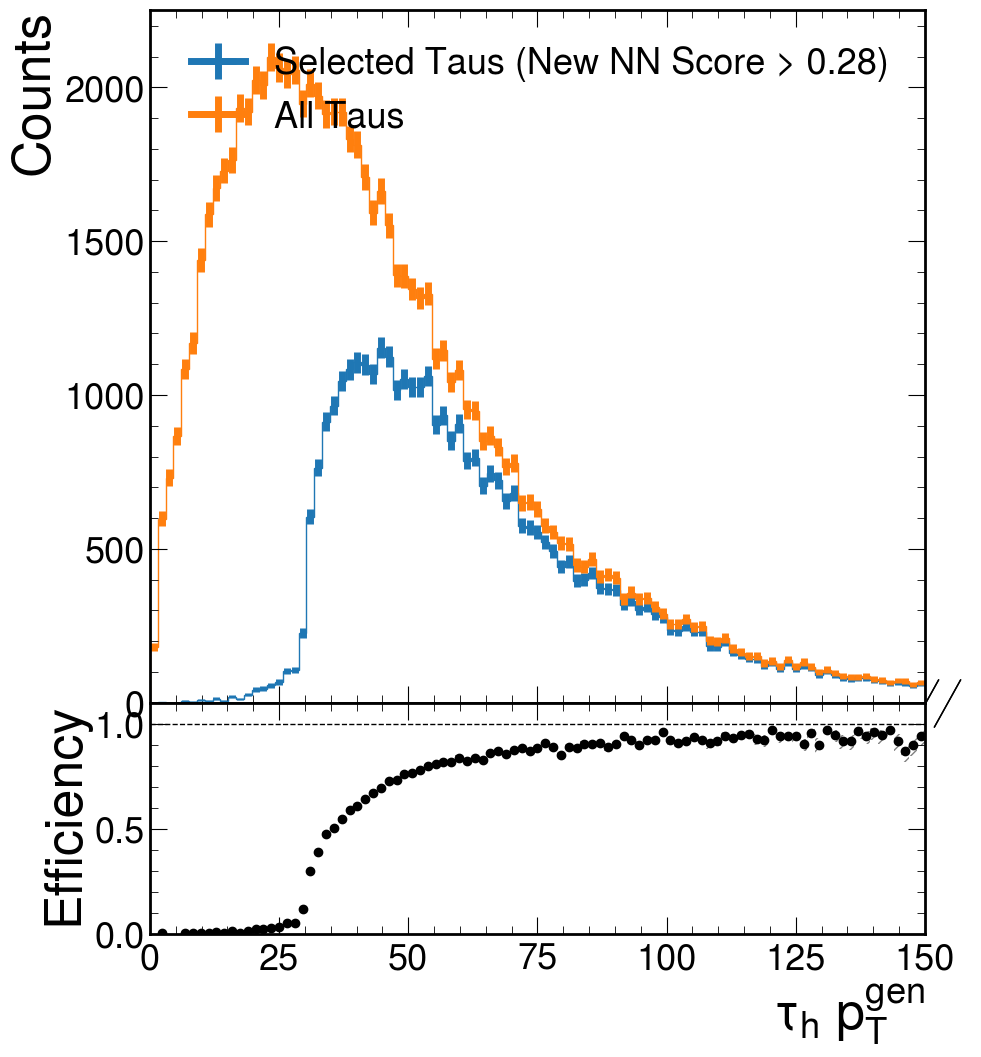

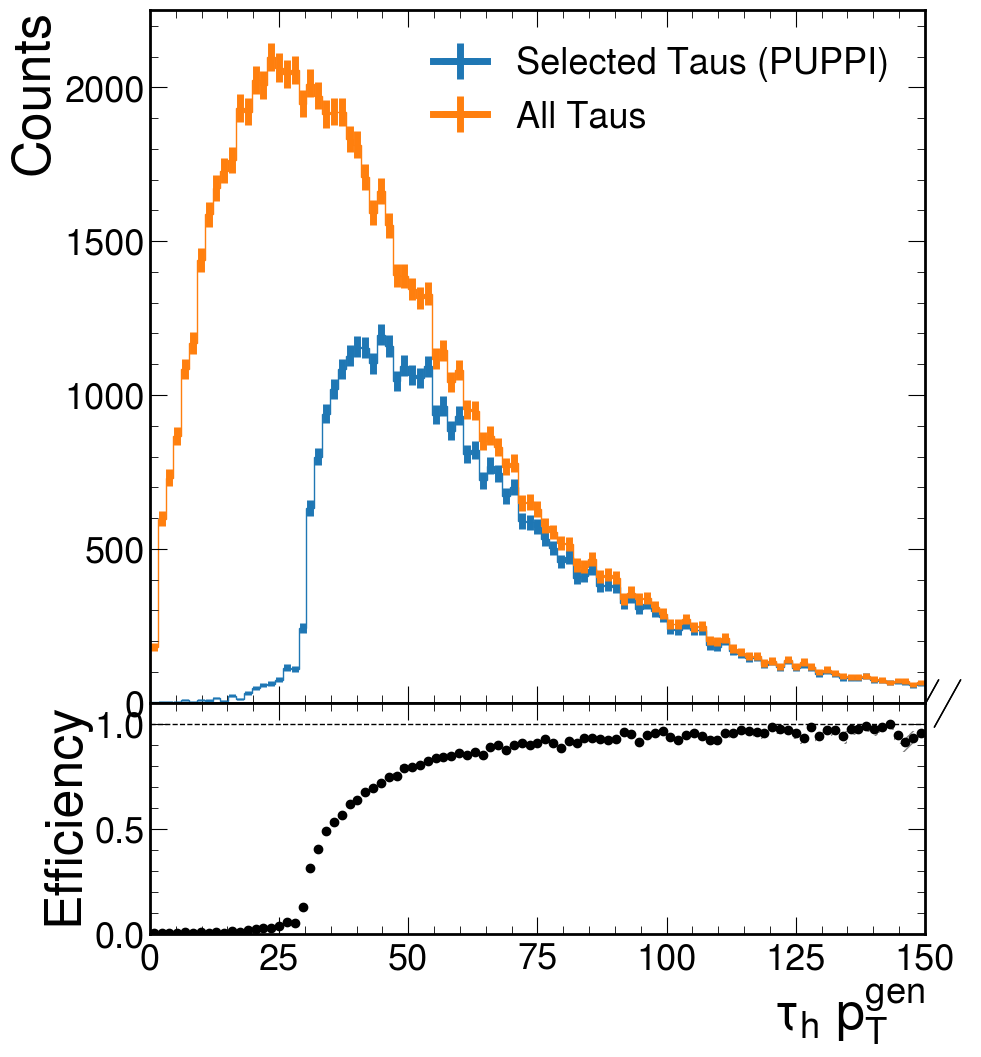

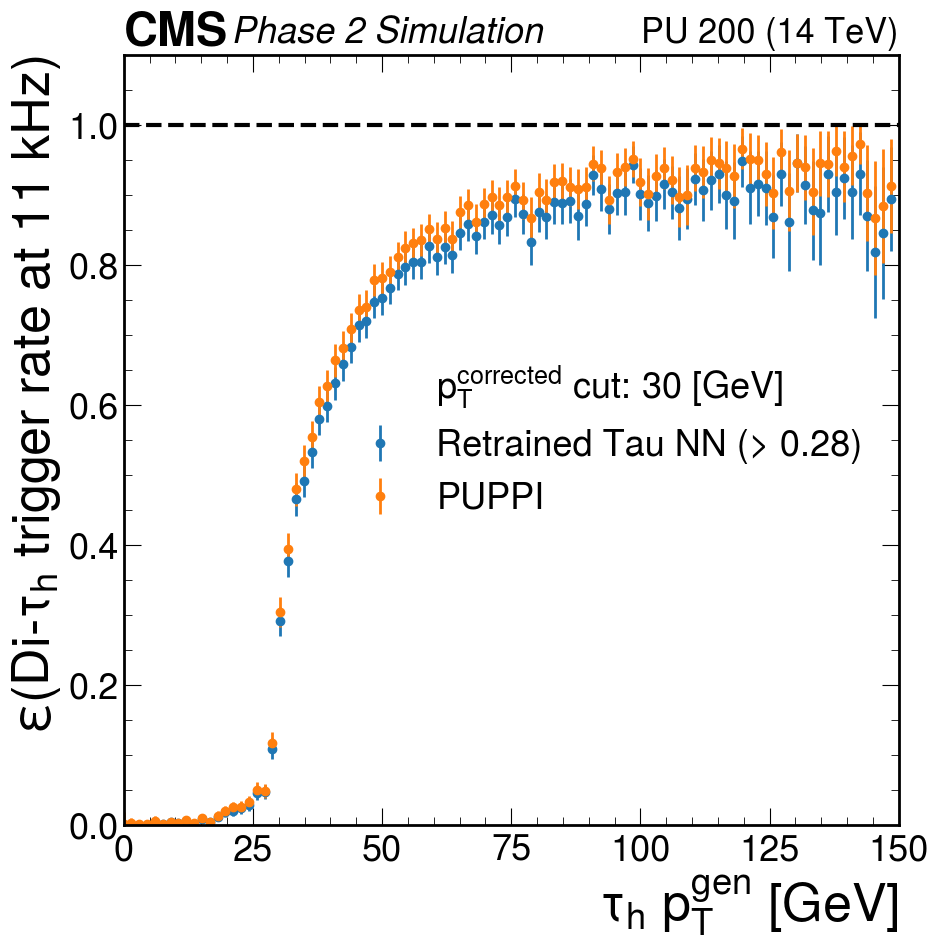

[0.         0.1262619  0.         0.         0.18896319 0.04840201
 0.0332046  0.00823417 0.02026876 0.00487483 0.02106149 0.0083256
 0.0202347  0.03091799 0.0310694  0.03591534 0.04119982 0.06491665
 0.06490688 0.14581252 0.39155093 0.48918593 0.59696149 0.63122303
 0.68019504 0.71731679 0.7293305  0.77498978 0.78180824 0.8238282
 0.8519771  0.83981403 0.87718884 0.87757248 0.88032165 0.89469816
 0.90009878 0.91226717 0.92296442 0.92311489 0.91112603 0.92431451
 0.92413005 0.95541185 0.95394552 0.94659109 0.94546074 0.95551544
 0.94837989 0.95929088 0.96790787 0.96831462 0.93637633 0.96158807
 0.96828676 0.96323088 0.98231517 0.96589655 0.97426629 0.97111176
 0.98258943 0.97709647 0.93468742 0.98257955 0.97349507 0.98352731
 0.96743951 0.96273737 0.97801715 0.97113618 0.97145221 0.981858
 0.9514882  0.97705798 0.97909858 0.98491156 1.         0.98375692
 0.98065738 0.99051765 0.98931622 0.99110074 0.97852634 0.97164876
 1.         0.96205601 0.96184918 1.         1.         1.
 1.    

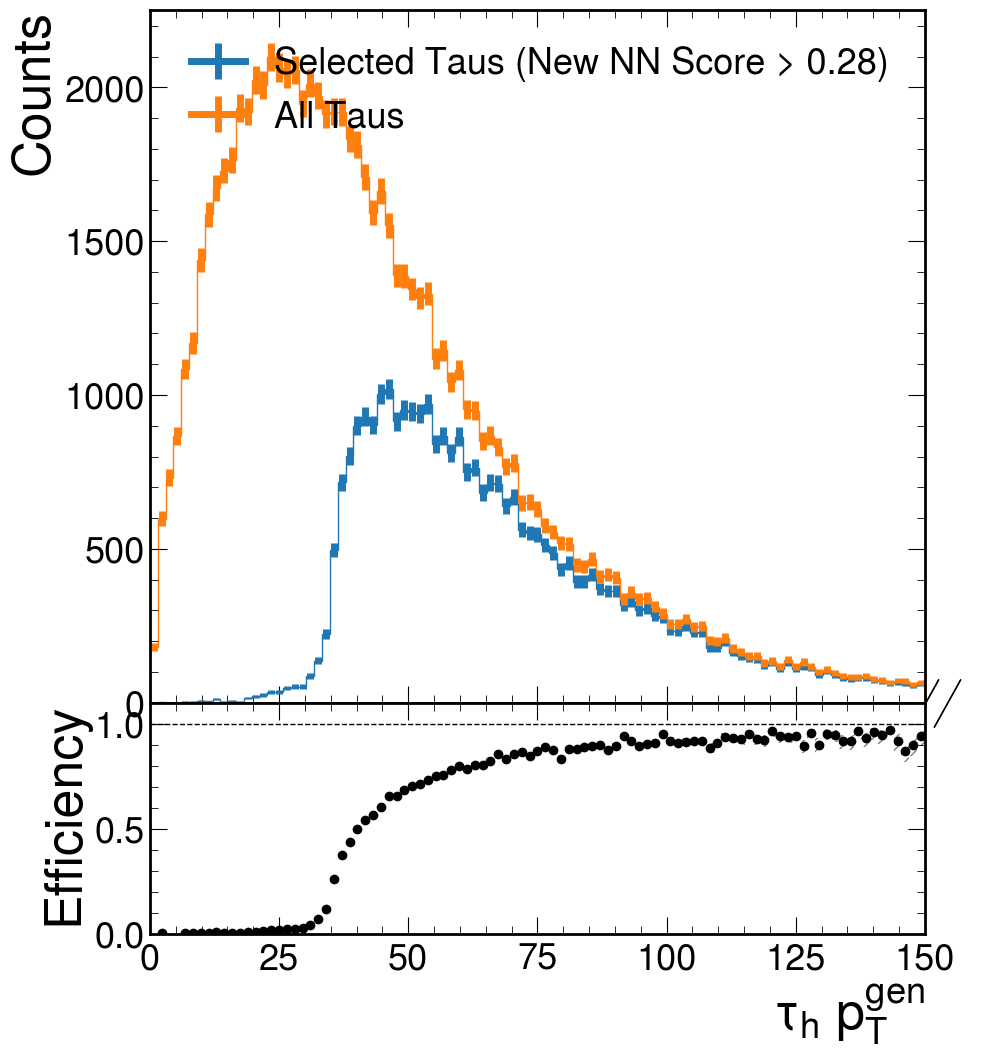

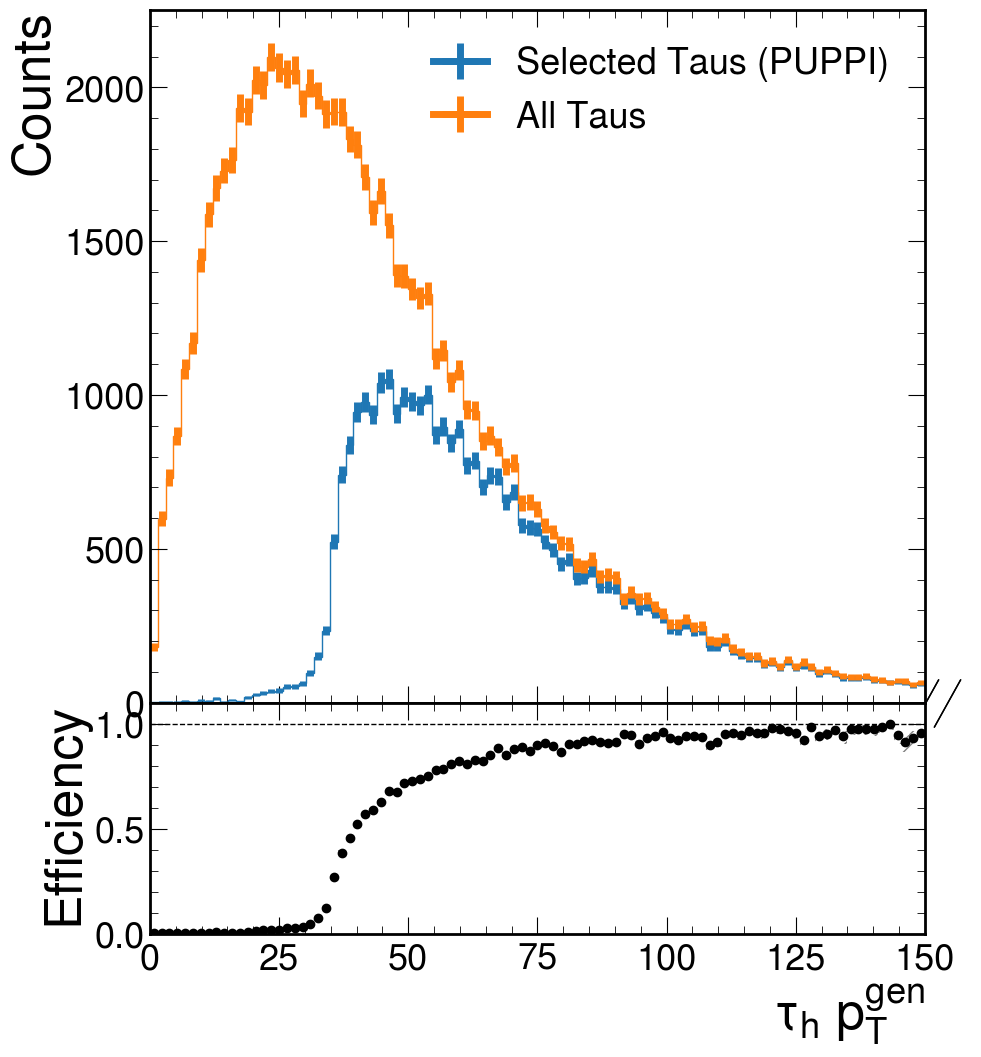

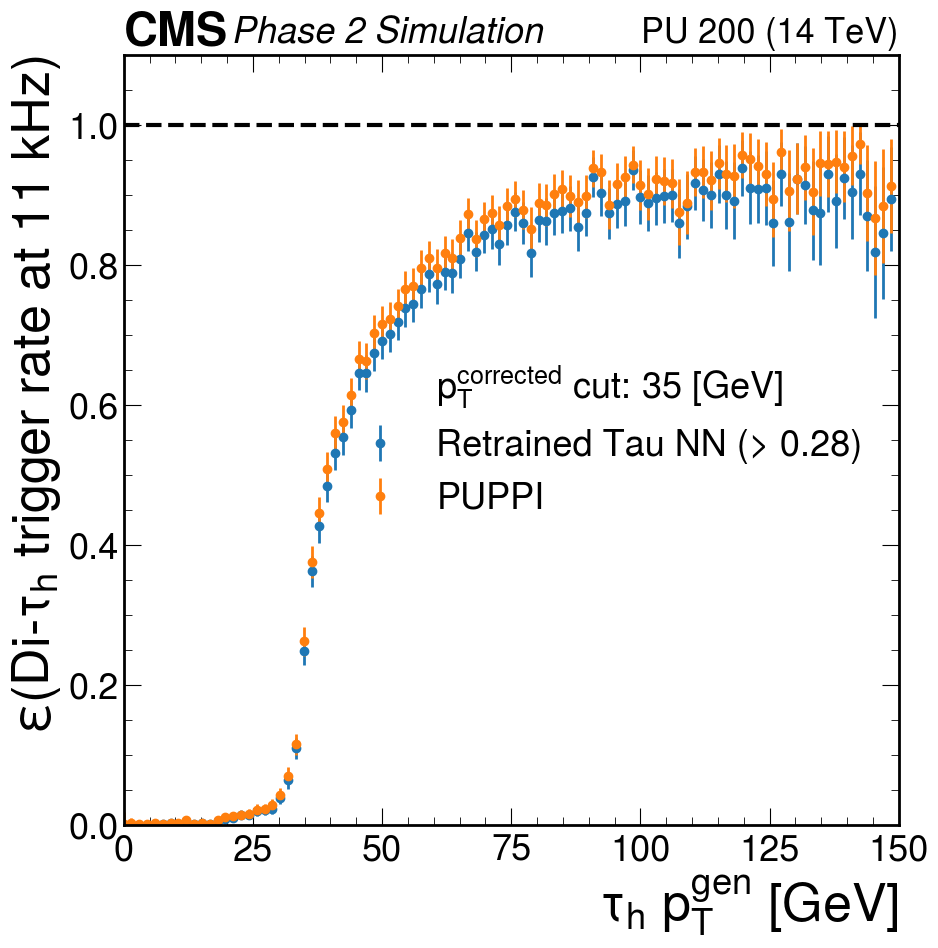

[0.         0.1262619  0.         0.         0.0713465  0.04840201
 0.02297315 0.00604595 0.018429   0.00121515 0.00489539 0.00147118
 0.01079397 0.0143054  0.01514282 0.02085596 0.01973431 0.02805567
 0.02973232 0.03090535 0.05218521 0.08221069 0.14014218 0.31914396
 0.46190149 0.52738081 0.59053854 0.65295567 0.6579912  0.71413505
 0.77034482 0.75237026 0.79053246 0.80627575 0.80418495 0.81642388
 0.83412445 0.84451953 0.87797888 0.87865014 0.86649802 0.88438324
 0.8940192  0.91382883 0.93869318 0.92083907 0.92500301 0.93435196
 0.91840542 0.94643074 0.9480438  0.95362742 0.91836083 0.94814459
 0.96040783 0.94764327 0.96975208 0.95464274 0.95722474 0.95679391
 0.97914017 0.97061015 0.92794044 0.96531682 0.95853808 0.97543192
 0.9628473  0.96273737 0.97365526 0.95227446 0.96674991 0.95792222
 0.93964039 0.97140961 0.97909858 0.96271157 1.         0.98375692
 0.98065738 0.98123713 0.98931622 0.98228443 0.97852634 0.962304
 1.         0.96205601 0.93891269 1.         1.         1.
 1.  

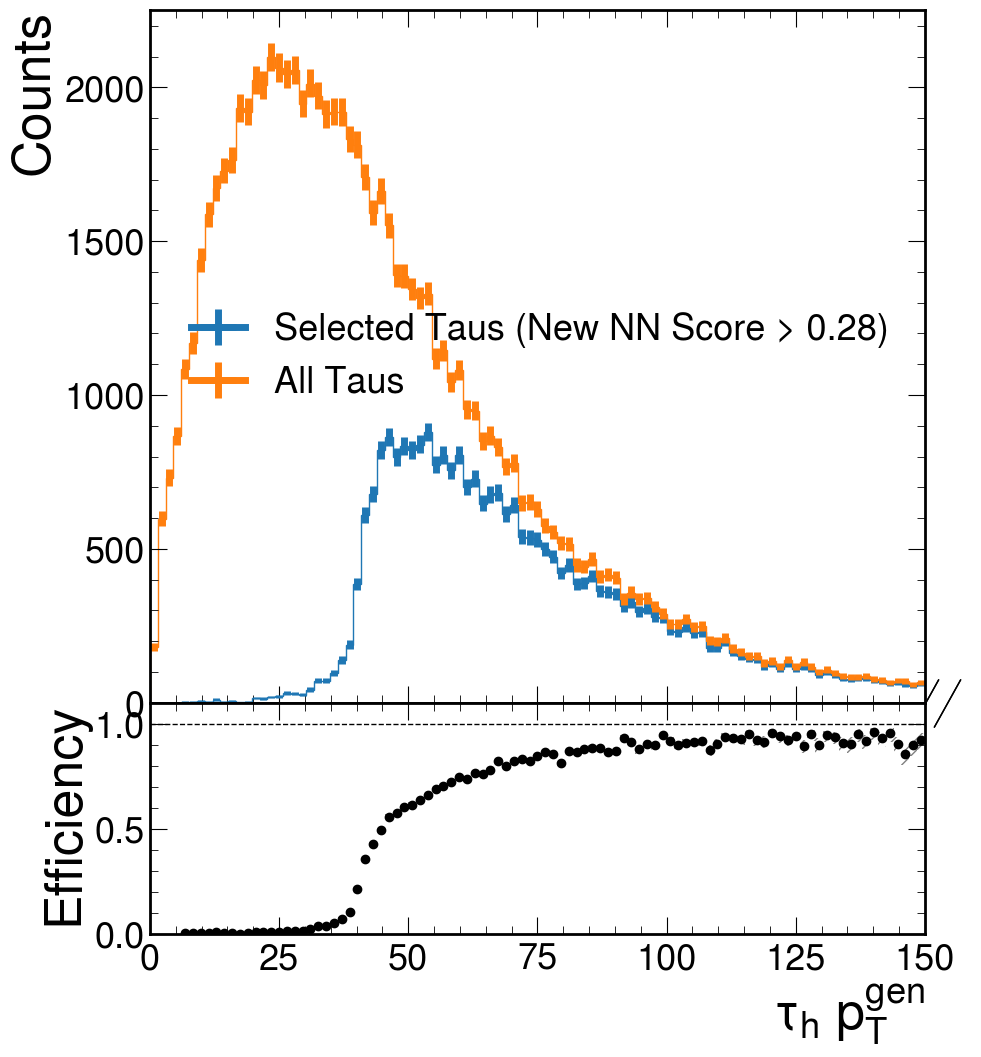

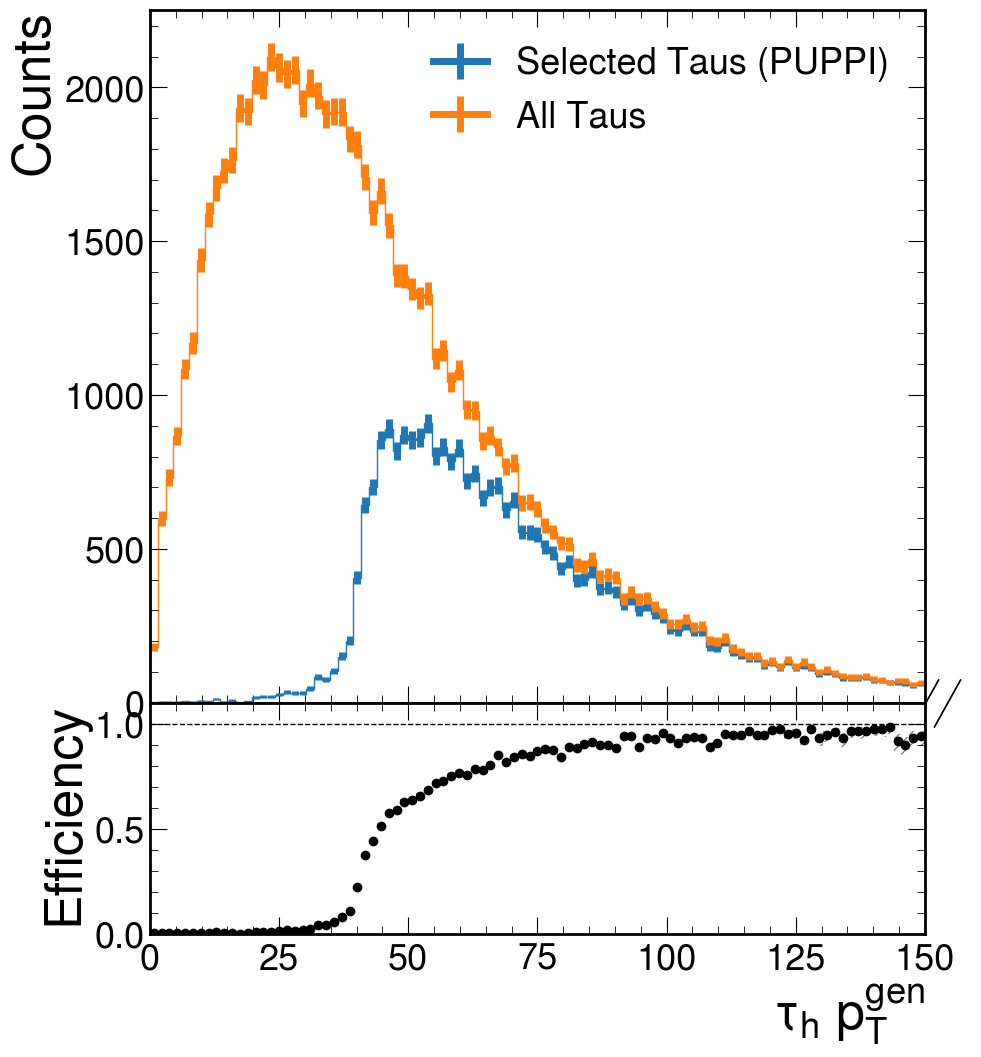

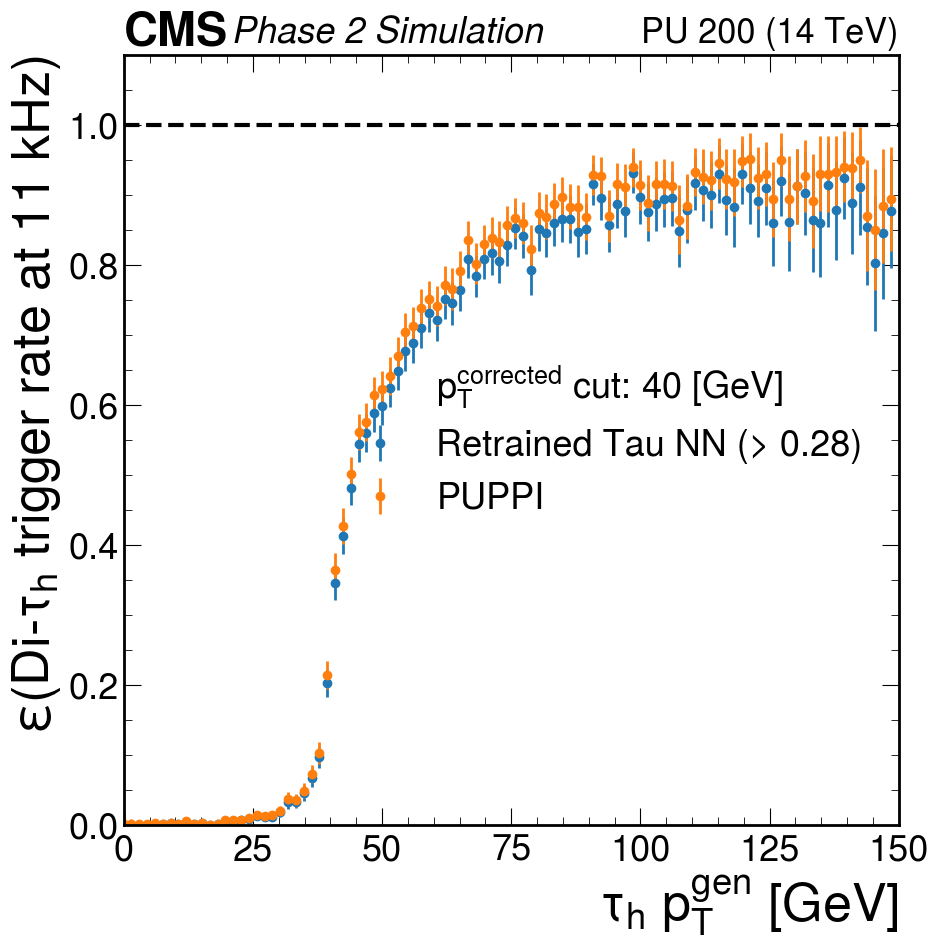

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.13464989e-02 4.84020054e-02 1.80233717e-02 2.05249583e-03
 1.47923228e-02 1.21515405e-03 4.89538983e-03 1.85840687e-04
 1.32043502e-03 9.71009305e-03 7.46897127e-03 1.02008202e-02
 1.15119435e-02 1.71433380e-02 1.60144375e-02 1.44294376e-02
 2.38585591e-02 4.13460279e-02 4.20814519e-02 5.78720058e-02
 8.48639502e-02 1.18874563e-01 2.47039558e-01 4.24227602e-01
 4.90215499e-01 5.81009653e-01 6.48884309e-01 6.53531049e-01
 6.90672755e-01 6.97707395e-01 7.16114694e-01 7.36837839e-01
 7.65427213e-01 7.81153704e-01 8.14183619e-01 8.16517955e-01
 8.08894069e-01 8.41021505e-01 8.44962700e-01 8.63151938e-01
 8.98661582e-01 8.81634611e-01 8.87196753e-01 8.95782595e-01
 8.92087238e-01 9.15342026e-01 9.22383876e-01 9.32733816e-01
 8.91441849e-01 9.34748144e-01 9.42087338e-01 9.32133261e-01
 9.57237937e-01 9.37844396e-01 9.48733112e-01 9.31185536e-01
 9.68845124e-01 9.64144987e-01 9.11144546e-01 9.65316823e-01
 9.43685624e-01 9.714111

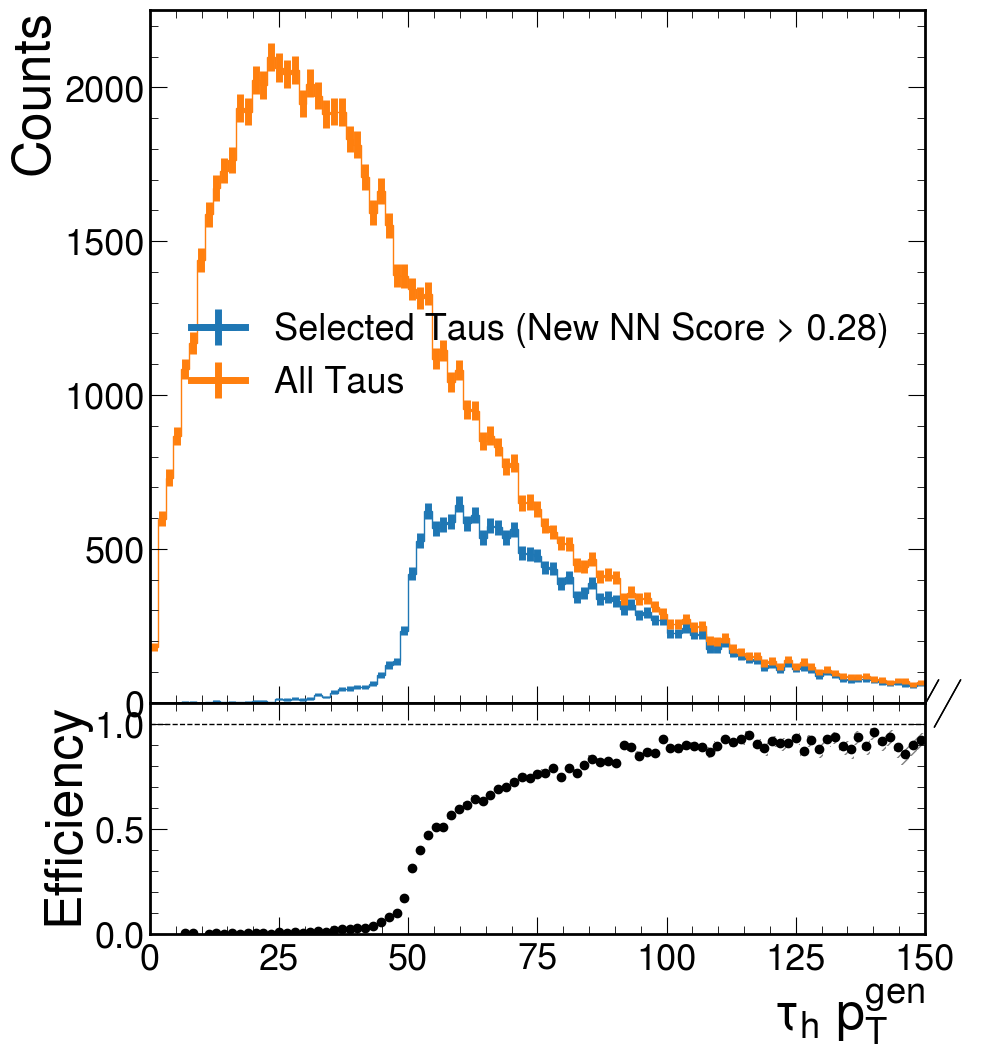

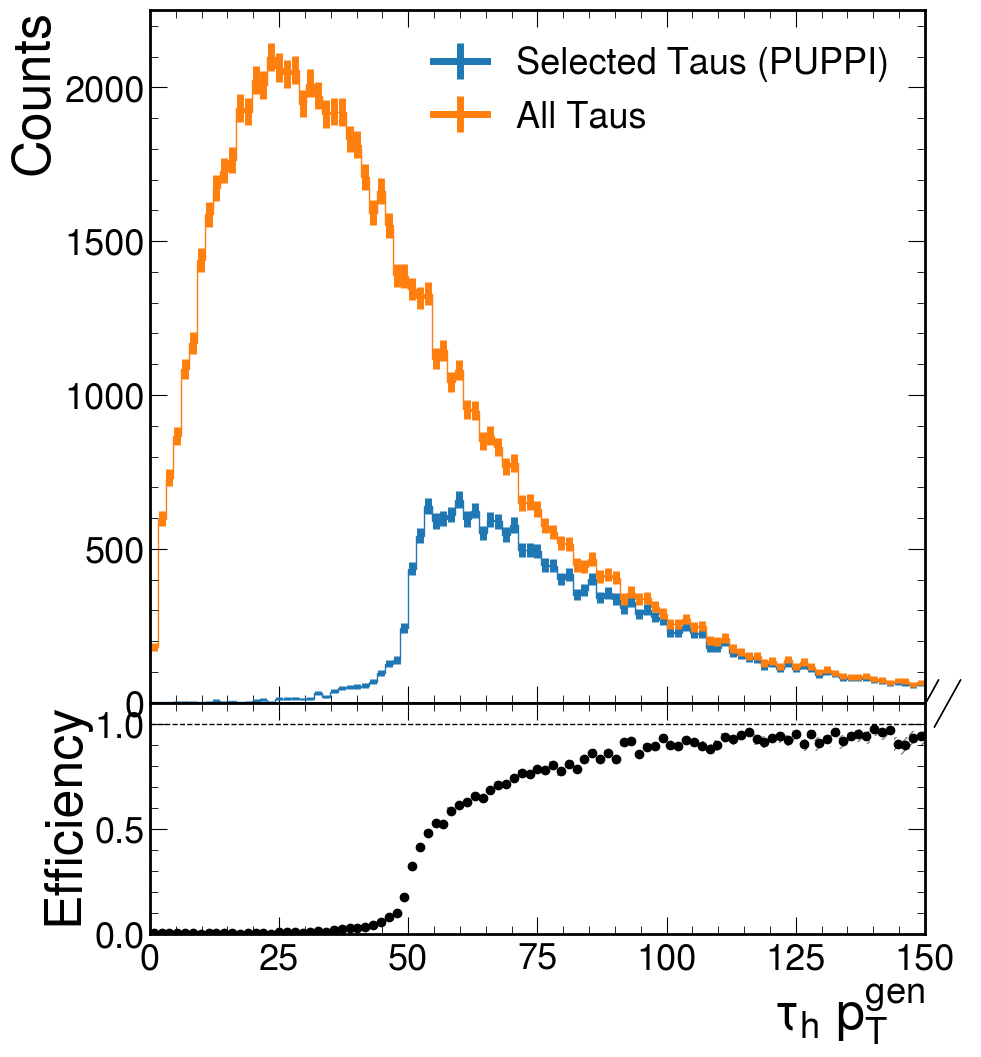

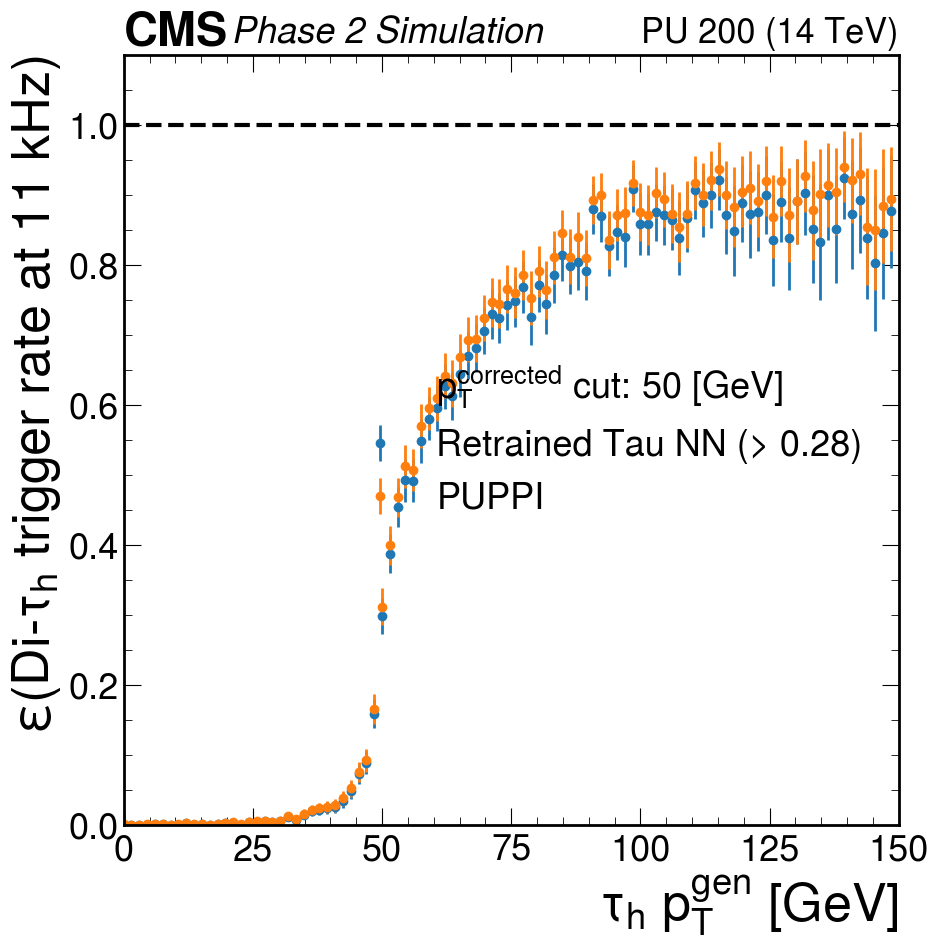

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 7.76884972e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 3.14562445e-03 2.86296513e-03 1.27621602e-04
 6.00453377e-03 4.80876817e-03 6.39138964e-03 4.74765534e-03
 6.33259330e-03 1.38159457e-02 9.26537710e-03 1.82941803e-02
 2.42914133e-02 2.59363589e-02 2.89310830e-02 3.09474441e-02
 4.04983924e-02 5.86284258e-02 8.57117114e-02 1.03252626e-01
 1.86313682e-01 3.47957459e-01 4.43866178e-01 5.16289427e-01
 5.56004016e-01 5.57820568e-01 6.28850169e-01 6.48398480e-01
 6.68355157e-01 7.01175576e-01 6.94985958e-01 7.28287174e-01
 7.44392235e-01 7.66494305e-01 7.74831462e-01 8.00301647e-01
 8.01564657e-01 8.21179570e-01 8.09395881e-01 8.52000217e-01
 8.15723972e-01 8.46341076e-01 8.28417411e-01 8.50368163e-01
 9.00167718e-01 8.65900517e-01 9.00918443e-01 8.66457538e-01
 9.31611798e-01 9.35270929e-01 8.77809921e-01 9.20969595e-01
 9.03257915e-01 9.475771

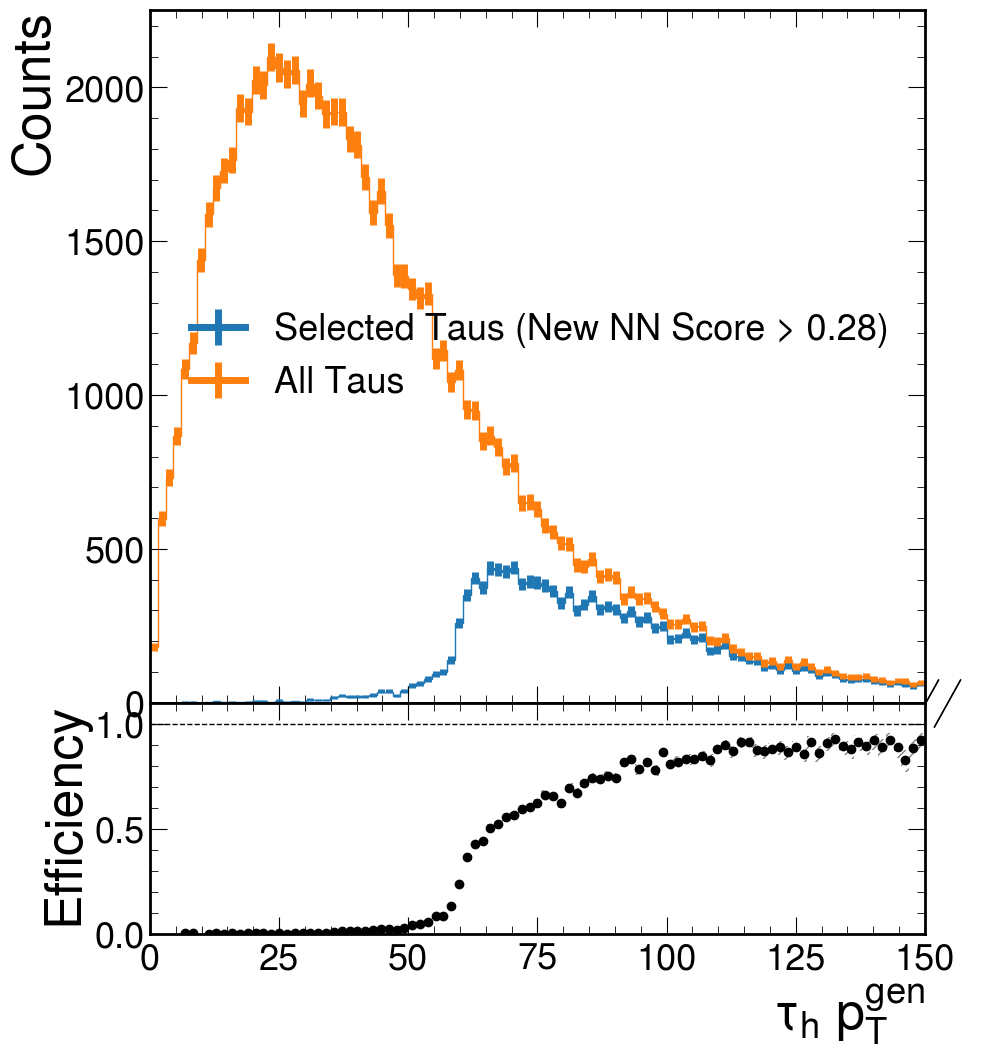

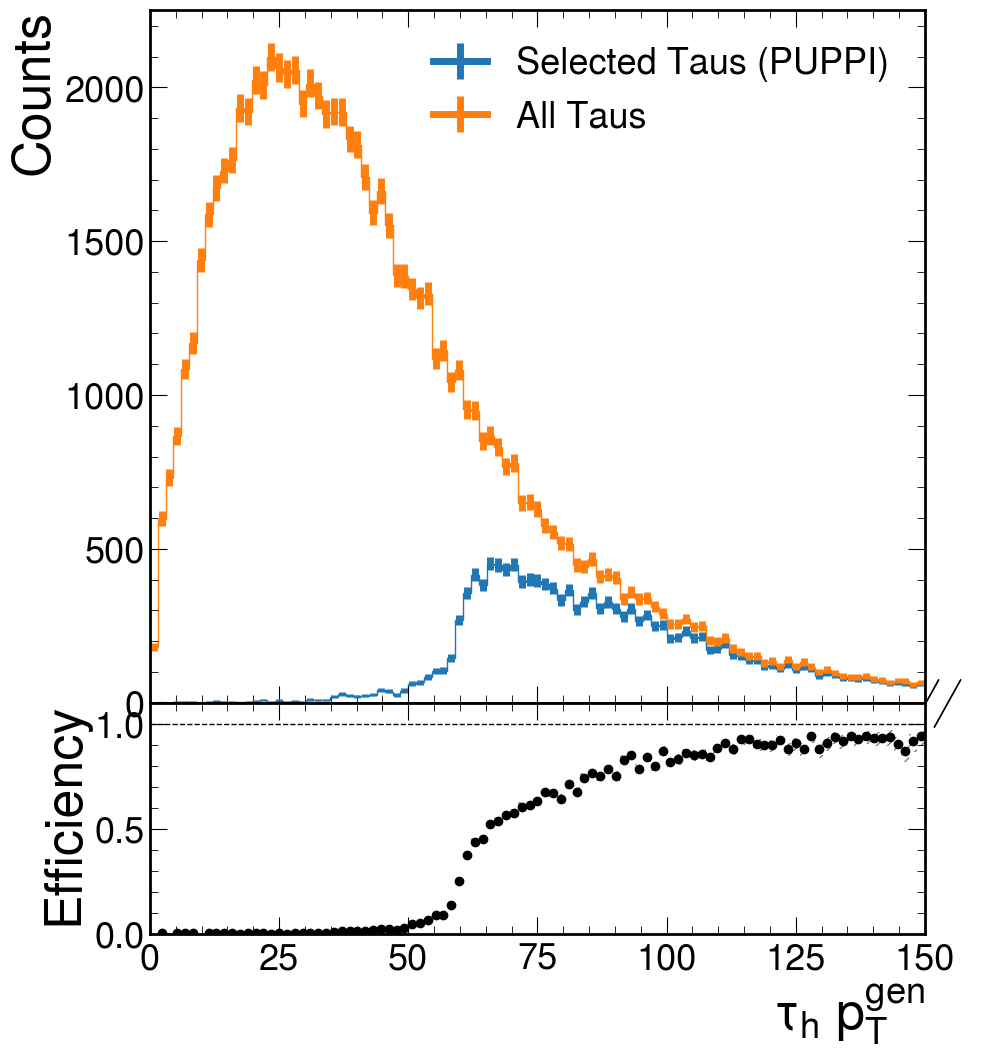

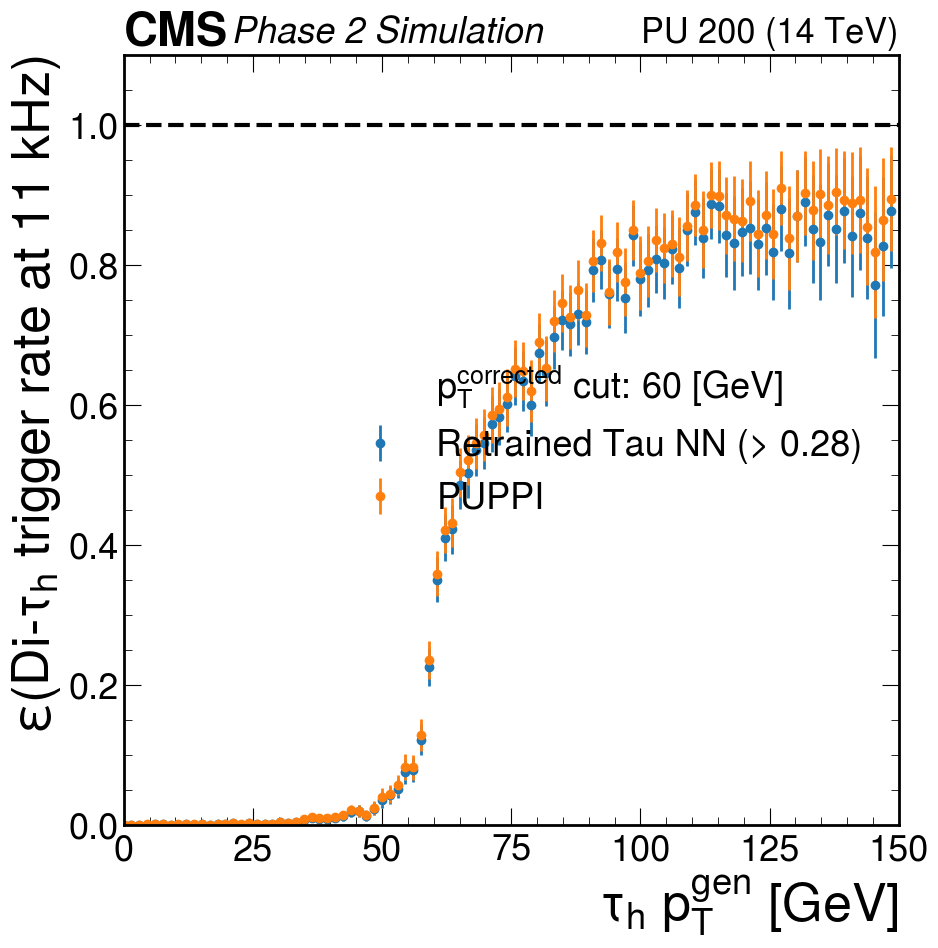

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 4.47530891e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 2.46792506e-03 2.86296513e-03 1.27621602e-04
 3.08988428e-03 4.93953397e-04 1.41133891e-03 4.87664975e-04
 4.62169005e-03 3.99501291e-03 4.06589107e-03 8.65757897e-03
 1.21434950e-02 1.05296505e-02 1.04766351e-02 1.18464616e-02
 1.49699361e-02 2.18374951e-02 2.31540614e-02 1.45897248e-02
 2.70468088e-02 4.14366802e-02 4.81786357e-02 5.85703240e-02
 8.46506554e-02 8.86666029e-02 1.39700050e-01 2.51969745e-01
 3.93196693e-01 4.59134416e-01 4.78745355e-01 5.49114383e-01
 5.58470229e-01 6.02357527e-01 5.98409666e-01 6.29004128e-01
 6.45053247e-01 6.63962345e-01 6.94171953e-01 7.03034832e-01
 6.74851428e-01 7.39517388e-01 7.19010152e-01 7.54689843e-01
 7.97401407e-01 7.75935274e-01 8.17500355e-01 7.85875856e-01
 8.38996467e-01 8.68894863e-01 8.05369830e-01 8.63791589e-01
 8.09340902e-01 8.779077

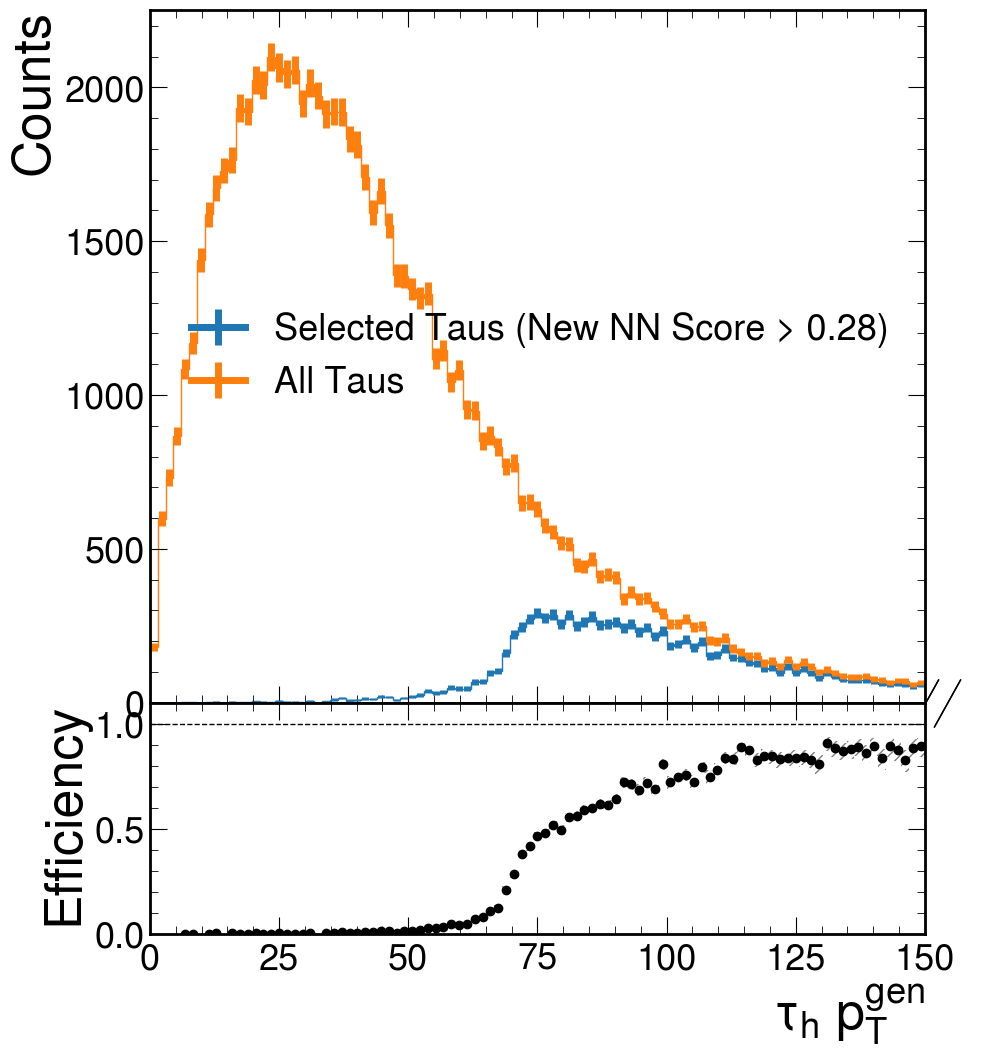

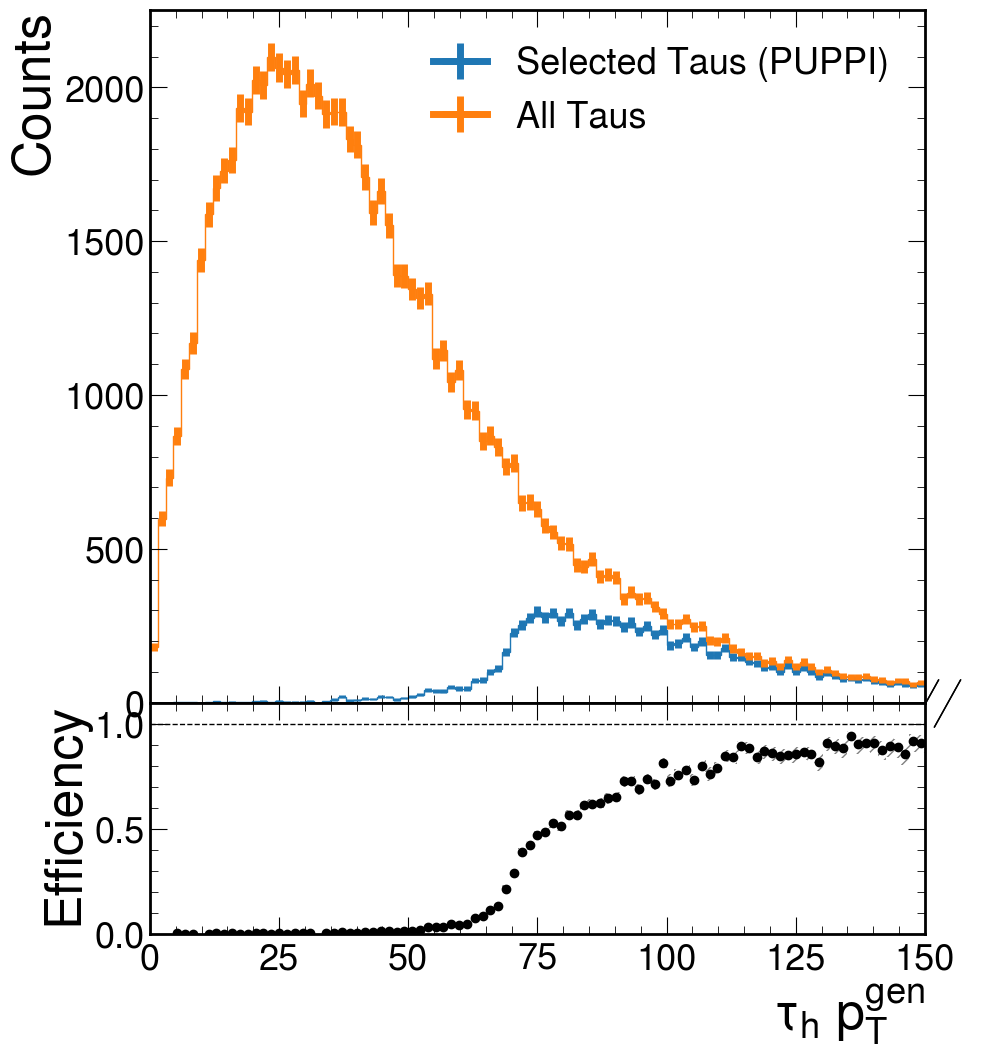

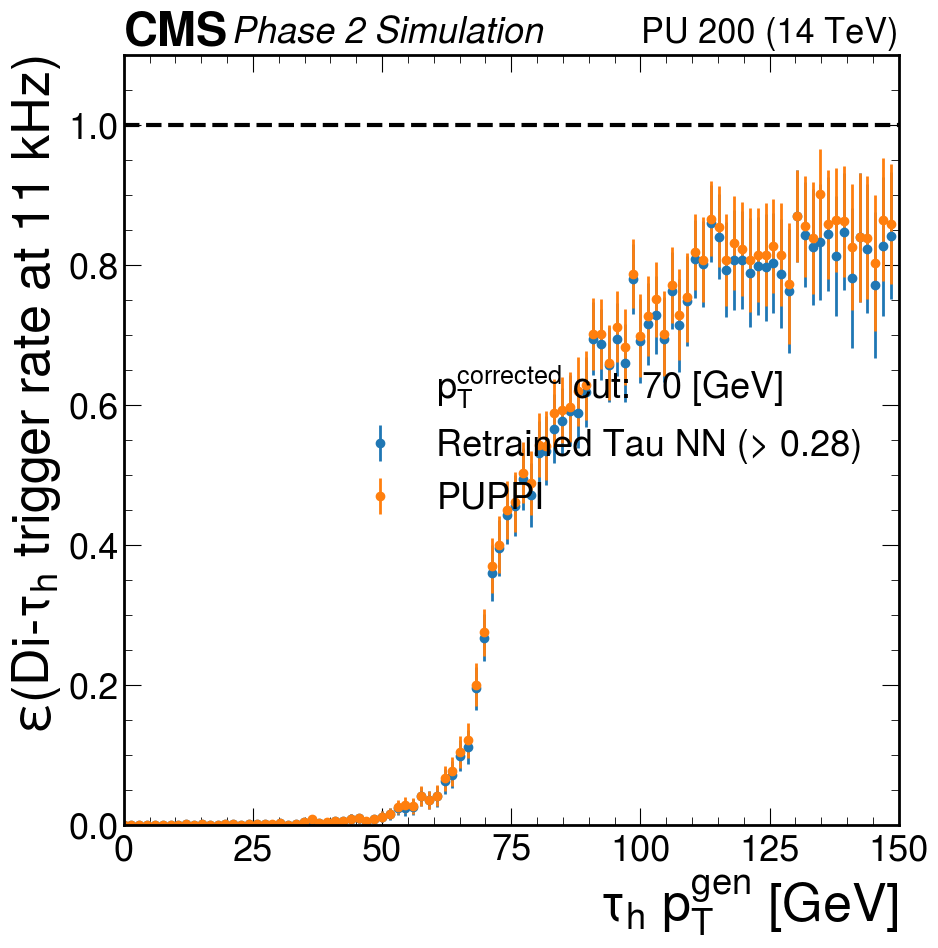

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 2.93362799e-03 0.00000000e+00 9.57377801e-04 1.85840687e-04
 1.66798111e-04 1.81210651e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 4.79147060e-04 1.18946118e-04
 2.42737710e-03 0.00000000e+00 1.39977371e-03 4.61740776e-03
 7.43544670e-03 2.98748917e-03 3.51959239e-03 6.79546647e-03
 5.77634986e-03 1.06703217e-02 1.06325668e-02 4.39743038e-03
 9.47419595e-03 1.35330665e-02 1.75021506e-02 2.65304924e-02
 2.67269492e-02 2.89280763e-02 4.63815278e-02 3.97127111e-02
 4.52751656e-02 6.96485811e-02 8.12992205e-02 1.11592109e-01
 1.23771958e-01 2.19316081e-01 2.93355494e-01 3.94547265e-01
 4.38085757e-01 4.89404156e-01 4.93394353e-01 5.48019672e-01
 5.29169135e-01 5.82418895e-01 5.95768833e-01 6.13098000e-01
 6.38355718e-01 6.41523770e-01 6.58602179e-01 6.76057882e-01
 7.35284392e-01 7.38673858e-01 6.98314937e-01 7.54502941e-01
 7.09882984e-01 8.135384

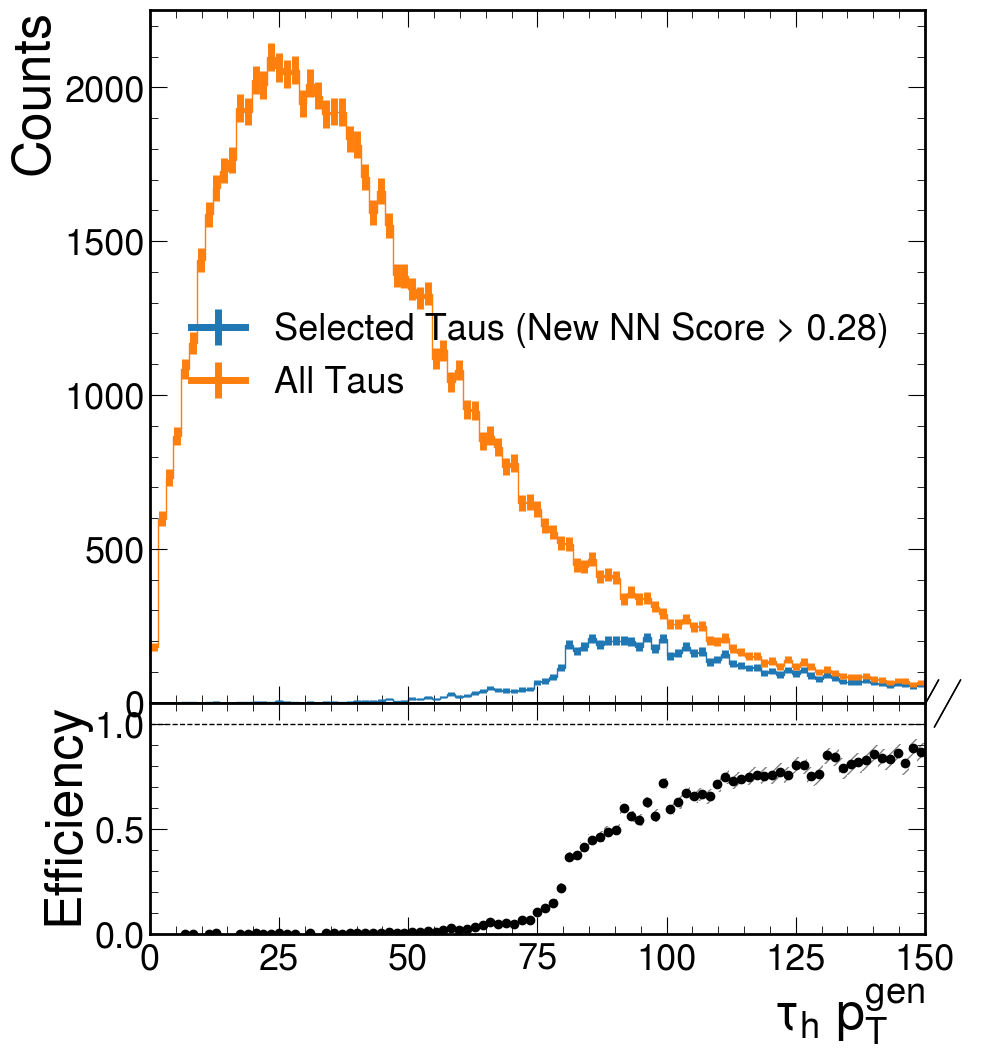

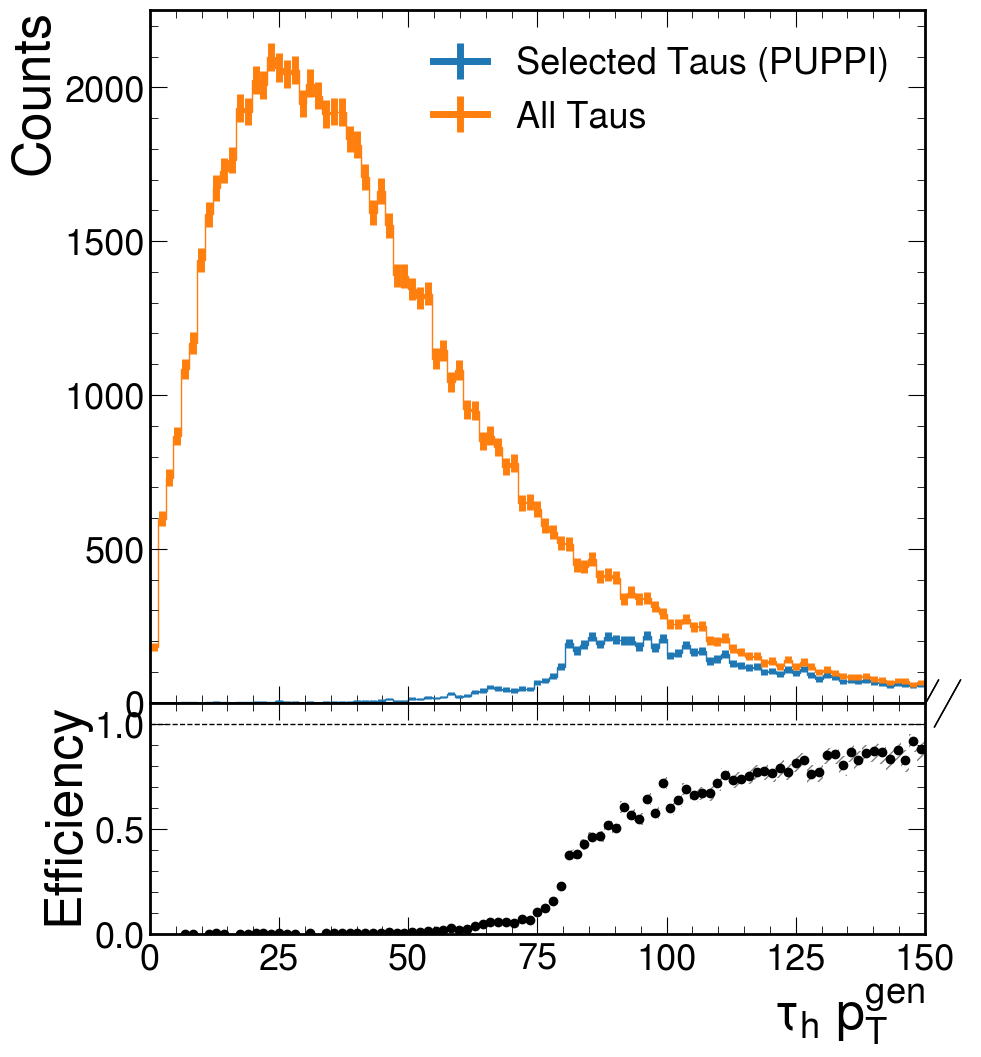

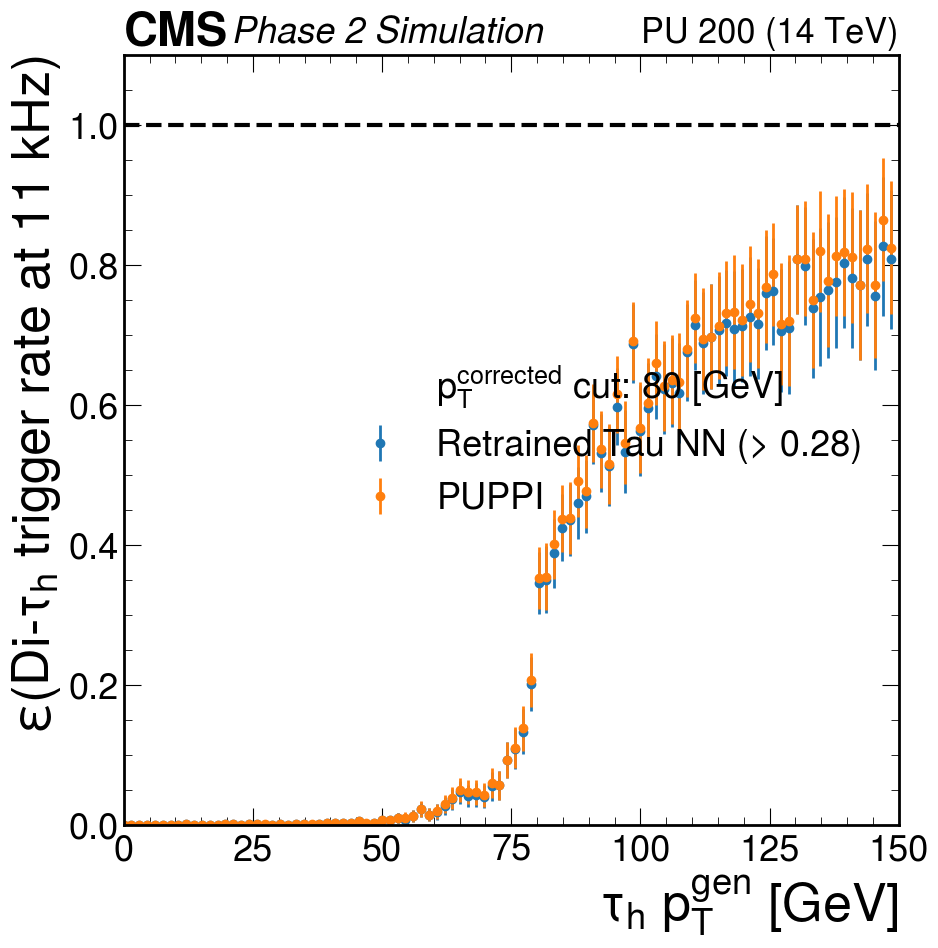

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 1.51930652e-03 0.00000000e+00 0.00000000e+00 1.85840687e-04
 1.66798111e-04 1.18787877e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 1.16869265e-04 0.00000000e+00
 9.16646781e-04 0.00000000e+00 9.17581132e-04 9.15781289e-04
 1.14899165e-04 4.78654787e-04 2.43515628e-03 2.60466705e-03
 2.12050807e-03 3.21001695e-03 5.95861872e-03 1.75256075e-03
 3.06869443e-03 8.20582927e-03 7.49547493e-03 1.10667176e-02
 7.82987802e-03 1.36995395e-02 2.50770658e-02 1.61154692e-02
 2.04730757e-02 3.00989224e-02 4.13802047e-02 5.24750636e-02
 4.52716160e-02 4.82476683e-02 4.37556686e-02 6.03766498e-02
 6.21882500e-02 1.02500500e-01 1.17070186e-01 1.47184715e-01
 2.26230821e-01 3.78889478e-01 3.89983417e-01 4.19858254e-01
 4.69753116e-01 4.72019558e-01 5.15477043e-01 5.13552566e-01
 6.04496029e-01 5.71339263e-01 5.45046649e-01 6.50032647e-01
 5.73394468e-01 7.166841

In [25]:
results = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_no_nn = gen_pT_list


In [26]:
print(gen_pT_list_no_nn)
print(gen_pT_list_nn)

[33.333333333333336, 48.484848484848484, 56.06060606060606, 65.15151515151516, 77.27272727272728, 84.84848484848484, 103.03030303030303, 115.15151515151516, 134.84848484848487, 146.96969696969697]
[21.21212121212121, 30.303030303030305, 36.36363636363636, 45.45454545454545, 54.54545454545455, 63.63636363636363, 80.30303030303031, 92.42424242424244, 109.0909090909091, 118.18181818181819]


In [29]:
def plot_95th(gen_pT_no_nn, gen_pT_nn, threshold_list):
    a, b = np.polyfit(threshold_list, gen_pT_nn, 1)
    c, d = np.polyfit(threshold_list, gen_pT_no_nn, 1)
    fig = plt.figure()
    plt.plot(threshold_list, [a*i + b for i in threshold_list], "--", linewidth = 1)
    plt.plot(threshold_list, gen_pT_nn, "o-", fillstyle='none', linewidth = 1, label = "Merged NN Corrected pT (y = " + str(round(a, 2)) + "x" + " + " + str(round(b, 2)) + ")", color = 'C0')
    plt.plot(threshold_list, [c*i + d for i in threshold_list], "--", linewidth = 1, color = 'r')
    plt.plot(threshold_list, gen_pT_no_nn, "o-", fillstyle='none', linewidth = 1, label = "PUPPI Reco pT (y = " + str(round(c, 2)) + "x" + " + " + str(round(d, 2)) + ")", color = 'r')
    #plt.xlim([20,85])
    #plt.xlim([20,85])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$p_T$ Cut Threshold [GeV]", fontsize = 25)
    plt.ylabel(r"$95\%$ Efficiency Point [GeV]", fontsize = 25)
    plt.legend(loc = 'upper left', fontsize = 18.5)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

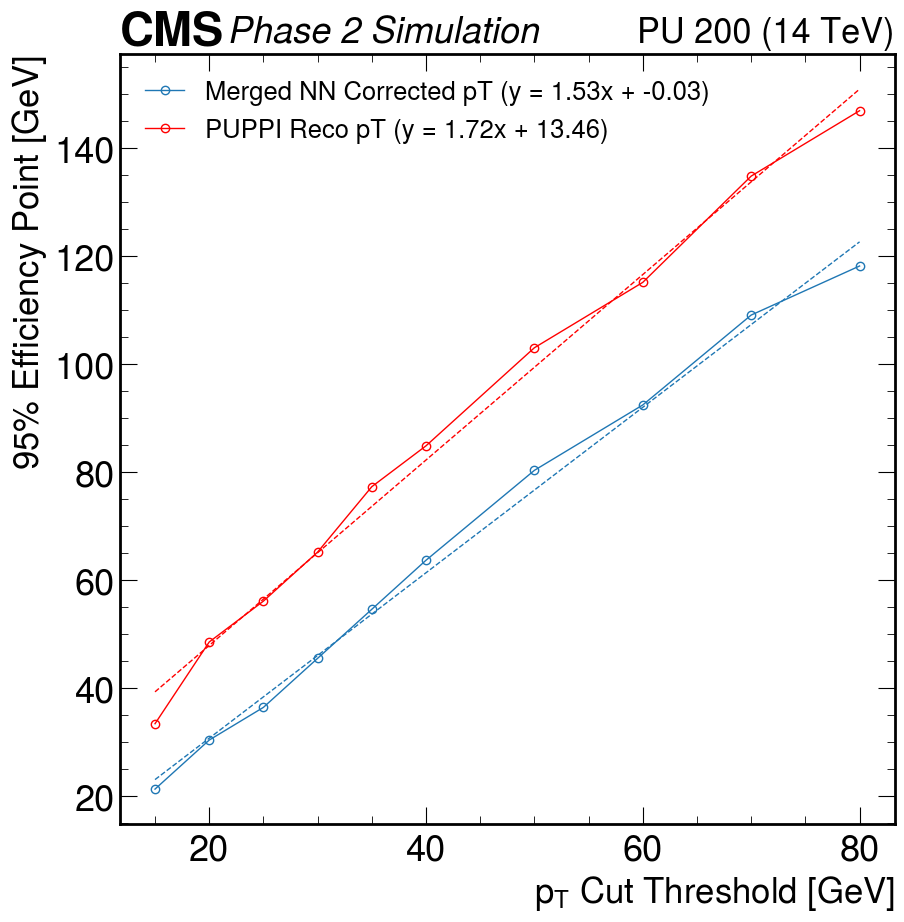

In [30]:

plot_95th(gen_pT_list_no_nn, gen_pT_list_nn, threshold_list)

# maybe make points 